In [6]:
import dill as pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from test_utils import extract_labels, get_optimizer, create_dirs
import os 
import math

import random
import numpy as np

import sys
sys.path.append('/Users/matsumoton/Git/digen')
from digen import Benchmark

SyntaxError: '(' was never closed (base.py, line 112)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import makedirs
from matplotlib.lines import Line2D


def get_files_name(directory_name, inputname, i, evpop, evgen):
    cx_name = f"{directory_name}{inputname}_run_{i}_pop{evpop}_gen{evgen}_crossover.csv"
    mut_name = f"{directory_name}{inputname}_run_{i}_pop{evpop}_gen{evgen}_mutation.csv"
    return cx_name, mut_name


def determine_better(row):
    if row.offspring <= row.parent1 and row.offspring <= row.parent2:
        return 'worse'
    if row.offspring <= row.parent1 or row.offspring <= row.parent2:
        return 'better than one'
    return 'better than two'


def count_improvement(cx_dfs, mut_dfs):
    cx_counters = [{'worse': 0, 'better than one': 0, 'better than two': 0} for _ in range(len(cx_dfs))]
    for cx_c, cx_df in zip(cx_counters, cx_dfs):
        for row in cx_df.itertuples(index=False):
            offspring_better = determine_better(row)
            cx_c[offspring_better] += 1

    mut_counters = [{'worse': 0, 'better': 0} for _ in range(len(mut_dfs))]
    for mut_c, mut_df in zip(mut_counters, mut_dfs):
        for row in mut_df.itertuples(index=False):
            if row.offspring <= row.parent:
                mut_c['worse'] += 1
            else:
                mut_c['better'] += 1

    return cx_counters, mut_counters


def compute_p_each_generation(cx_dfs, mut_dfs, max_gen):
    cx_ps = [[] for _ in range(1, max_gen)]
    mut_ps = [[] for _ in range(1, max_gen)]
    for g in range(1, max_gen):
        for cx_df in cx_dfs:
            tmp_df = cx_df.loc[cx_df['gen'] == g]
            if tmp_df.shape[0] != 0:
                n_increment = 0
                for row in tmp_df.itertuples(index=False):
                    offspring_better = determine_better(row)
                    if offspring_better != 'worse':
                        n_increment += 1
                p = n_increment / tmp_df.shape[0]
                cx_ps[g - 1].append(p * 100)
        for mut_df in mut_dfs:
            tmp_df = mut_df.loc[mut_df['gen'] == g]
            if tmp_df.shape[0] != 0:
                n_increment = 0
                for row in tmp_df.itertuples(index=False):
                    n_increment += 1 if row.offspring >= row.parent else 0
                p = n_increment / tmp_df.shape[0]
                mut_ps[g - 1].append(p * 100)
    return cx_ps, mut_ps


def compute_aggregate_metrics(counters):
    keys = [k for k in counters[0]]
    aggregate = {k: [] for k in keys}
    for cx_c in counters:
        for k in keys:
            aggregate[k].append(cx_c[k])
    aggregate_metrics = {k: {'mean': np.mean(aggregate[k]),
                             'std': np.std(aggregate[k]),
                             'median': np.median(aggregate[k])}
                         for k in aggregate}
    return aggregate_metrics


def aggregate_metrics(cx_counters, mut_counters):
    cx_metrics = compute_aggregate_metrics(cx_counters)
    mut_metrics = compute_aggregate_metrics(mut_counters)
    return cx_metrics, mut_metrics


def plot_improvements(c_cx, c_mut, title, save_directory, filename):
    plt.figure(figsize=(8, 8))
    plt.bar([1, 2, 3],
            [c_cx['worse']['mean'], c_cx['better than one']['mean'], c_cx['better than two']['mean']],
            alpha=0.9)
    # plot medians
    for x, v in zip([1, 2, 3],
                    [c_cx['worse']['median'], c_cx['better than one']['median'], c_cx['better than two']['median']]):
        plt.plot([x - 0.35, x + 0.35], [v, v], lw=2.5, color='orange', alpha=0.9, zorder=11)
    # plot stds
    for x, m, std in zip([1, 2, 3],
                         [c_cx['worse']['mean'], c_cx['better than one']['mean'], c_cx['better than two']['mean']],
                         [c_cx['worse']['std'], c_cx['better than one']['std'], c_cx['better than two']['std']]):
        plt.plot([x - 0.1, x + 0.1], [m - std, m - std], lw=1.5, ls='-', color='black', alpha=0.8, zorder=10)
        plt.plot([x - 0.1, x + 0.1], [m + std, m + std], lw=1.5, ls='-', color='black', alpha=0.8, zorder=10)
        plt.plot([x, x], [m - std, m + std], ls='-', lw=1.5, color='black', alpha=0.8, zorder=10)
    plt.xticks([1, 2, 3],
               ["No improvement", "Improved one parent", "Improved both parents"],
               rotation=30, fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(f"{title} - Crossover", fontsize=26)
    plt.legend(handles=[Line2D([0], [0], lw=2.5, label='Mean'),
                        Line2D([0], [0], color='orange', lw=2.5, label='Median'),
                        Line2D([0], [0], color='black', lw=1.5, label='Standard Deviation')],
               fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{save_directory}/images/pdf/{filename}_cx.pdf")
    plt.savefig(f"{save_directory}/images/png/{filename}_cx.png")

    plt.figure(figsize=(8, 8))
    plt.bar([1, 2],
            [c_mut['worse']['mean'], c_mut['better']['mean']],
            alpha=0.9)
    # plot medians
    for x, v in zip([1, 2], [c_mut['worse']['median'], c_mut['better']['median']]):
        plt.plot([x - 0.35, x + 0.35], [v, v], lw=2.5, color='orange', alpha=0.9, zorder=11)
    # plot stds
    for x, m, std in zip([1, 2],
                         [c_mut['worse']['mean'], c_mut['better']['mean']],
                         [c_mut['worse']['std'], c_mut['better']['std']]):
        plt.plot([x - 0.1, x + 0.1], [m - std, m - std], lw=1.5, ls='-', color='black', alpha=0.8, zorder=10)
        plt.plot([x - 0.1, x + 0.1], [m + std, m + std], lw=1.5, ls='-', color='black', alpha=0.8, zorder=10)
        plt.plot([x, x], [m - std, m + std], ls='-', lw=1.5, color='black', alpha=0.8, zorder=10)
    plt.xticks([1, 2], ["No improvement", "Improved"],
               rotation=30, fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(f"{title} - Mutation", fontsize=26)
    plt.legend(handles=[Line2D([0], [0], lw=2.5, label='Mean'),
                        Line2D([0], [0], color='orange', lw=2.5, label='Median'),
                        Line2D([0], [0], color='black', lw=1.5, label='Standard Deviation')],
               fontsize=18)
    plt.tight_layout()
    plt.savefig(f"{save_directory}/images/pdf/{filename}_mut.pdf")
    plt.savefig(f"{save_directory}/images/png/{filename}_mut.png")


def percentage_metrics(ps):
    means = []
    stds = []
    for gen_p in ps:
        means.append(np.mean(gen_p))
        stds.append(np.std(gen_p))
    return means, stds


def plot_percentage_improvement_vs_generation(cx_p_improvement, mut_p_improvement, max_gen,
                                              title, save_directory, filename):
    cx_mean, cx_std = percentage_metrics(cx_p_improvement)
    mut_mean, mut_std = percentage_metrics(mut_p_improvement)
    plt.figure(figsize=(8, 8))
    plt.plot([i for i in range(1, max_gen)], cx_mean, color='dimgrey', lw=2.5, label="Crossover")
    plt.plot([i for i in range(1, max_gen)], mut_mean, color='darkgreen', lw=2.5, label="Mutation")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=18)
    plt.xlabel("Generation", fontsize=20)
    plt.ylabel("Improvement percentage", fontsize=20)
    plt.xlim(1, max_gen - 1)
    plt.ylim(0)
    plt.title(f"{title}", fontsize=30)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.savefig(f"{save_directory}/images/pdf/{filename}_percentage.pdf")
    plt.savefig(f"{save_directory}/images/png/{filename}_percentage.png")


In [4]:
fitness_df = pd.read_csv('/Users/matsumoton/Git//test_fitness.csv', sep=',')
top_values = fitness_df.groupby('generation')["score"].nlargest(1)
print(top_values)

generation     
0           24     0.85125
1           59     0.84375
2           85     0.84500
3           99     0.86625
4           143    0.88375
5           157    0.86375
Name: score, dtype: float64


In [4]:
import argparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os import makedirs
from scipy.stats import wilcoxon
from statannot import add_stat_annotation


def get_file_name(directory_name, inputname, i, evpop, evgen):
    df_name = f"{directory_name}{inputname}_run_{i}_evolution_pop{evpop}_gen{evgen}.csv"
    return df_name


def extract_bests(ev_dfs, nev_dfs):
    # extract bests of each generation of evolutions
    max_gen = max(ev_dfs[0]['generation'])
    bests_ev = [[] for _ in range(max_gen + 1)]
    for df in ev_dfs:
        for gen in range(max_gen + 1):
            gen_scores = df.loc[df['generation'] == gen]['score']
            bests_ev[gen].append(max(gen_scores))
    bests_ev = np.array(bests_ev)
    # extract bests of each random sampling
    bests_nev = []
    for df in nev_dfs:
        bests_nev.append(max(df['score']))
    bests_nev = np.array(bests_nev)
    return bests_ev, bests_nev


def compute_medians_bests(bests_ev, bests_nev):
    # median for evolution
    medians_ev = np.median(bests_ev, axis=1)
    # median for no evolution dfs
    median_nev = np.median(bests_nev)
    return medians_ev, median_nev


def plot_boxplots(last_gen_bests, random_bests, score, configname, title, save_directory, filename):
    df_ev_last_gen = pd.DataFrame({'score': last_gen_bests})
    df_ev_last_gen['type'] = configname
    df_nev = pd.DataFrame({'score': random_bests})
    df_nev['type'] = 'Random sampling'
    df = pd.concat((df_ev_last_gen, df_nev))

    _, pvalue = wilcoxon(last_gen_bests, random_bests,
                         zero_method='wilcox', correction=False,
                         alternative='two-sided', mode='auto')
    print(f"Wilcoxon Two-sided pvalue: {pvalue}")

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.despine(offset=10, trim=False)
    sns.boxplot(x='type', y='score', data=df, ax=ax, showmeans=False, dodge=False)
    add_stat_annotation(ax, data=df, x='type', y='score', perform_stat_test=False,
                        box_pairs=[(configname, 'Random sampling')],
                        pvalues=[pvalue],
                        pvalue_thresholds=[[1e-3, '**'], [1e-2, '*'],
                                           [0.05, '*'], [1, 'ns']],
                        test=None, text_format='star', loc='outside',
                        line_height=0.02, linewidth=2.5, fontsize=24, verbose=0)
    ax.set_xlabel('')
    ax.set_ylabel(f"{score}", fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=14)
    plt.suptitle(f"{title}", fontsize=30)
    plt.tight_layout()
    plt.savefig(f"{save_directory}/images/pdf/{filename}_distribution.pdf")
    plt.savefig(f"{save_directory}/images/png/{filename}_distribution.png", bbox_inches='tight')


def wrap_compute_to_plot(best_medians, FE_per_gen):
    def compute_to_plot(medians, FE):
        to_plot = []
        xs = []
        x = 0
        for m in medians:
            to_plot.append(m)
            xs.append(x)
            to_plot.append(m)
            x += FE
            xs.append(x)
        return to_plot, xs

    to_plot, xs = compute_to_plot(best_medians, FE_per_gen)
    return to_plot, xs


def plot_convergence(ev_best_medians, nev_best_median, FE_per_gen, score, configname, title, save_directory, filename):
    to_plot_nev = [nev_best_median, nev_best_median]
    to_plot_ev, xs = wrap_compute_to_plot(ev_best_medians, FE_per_gen)

    plt.figure(figsize=(8, 8))
    plt.plot([xs[0], xs[-1]], to_plot_nev, color='orange', lw=2.5, label='Random sampling')
    plt.plot(xs, to_plot_ev, color='blue', lw=2.5, label=configname)
    plt.xlabel("Pipeline evaluation", fontsize=20)
    plt.ylabel(f"{score}", fontsize=20)
    plt.title(f"{title}", fontsize=30)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, xs[-1])
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.savefig(f"{save_directory}/images/pdf/{filename}_converegence.pdf")
    plt.savefig(f"{save_directory}/images/png/{filename}_convergence.png")



In [63]:
from os.path import exists

directoryevs = ["/Users/matsumoton/Git/results_pop40_gen15_baseline/gen_fitnesses/",
    "/Users/matsumoton/Git/results_pop40_gen15_gaussian_integral/gen_fitnesses/",
    "/Users/matsumoton/Git/results_pop40_gen15_gaussian_integral_v2/gen_fitnesses/",
    "/Users/matsumoton/Git/results_pop40_gen15_gi_crossover/gen_fitnesses/"]
directoryev = directoryevs[3]
ev_dfs = []
nev_dfs = []

score = 'Accuracy'

for j in range(1,41):
#for j in range(9,10):

    ev_dfs = []
    nev_dfs = []
    inputname = "digen" + str(j)
    configname = inputname + "config"
    title = inputname
    filename = inputname
    file_exists = exists(f"{directoryev}{inputname}_run_0_evolution_pop40_gen15.csv")
    if not file_exists:
        continue
    for i in range(10):
        ev_df_name = f"{directoryev}{inputname}_run_{i}_evolution_pop40_gen15.csv"
        fitness_df = pd.read_csv(ev_df_name, sep=',')
        #top_values = fitness_df.groupby('generation')["score"].nlargest(1)
        top_values = fitness_df.groupby('generation')["score"].agg('max')

        #print(top_values)
        ev_dfs.append(top_values)
        
    ev_dfs = pd.concat(ev_dfs).to_frame()
    #ev_dfs["generation"] = ev_dfs.index
    ev_dfs = ev_dfs.groupby("generation")["score"].agg('mean')
    #print(ev_dfs)  
    #try:
        #makedirs(f"{directoryev}images/pdf/")
        #makedirs(f"{directoryev}images/png/")
    #except:
        #pass

    #ev_bests, nev_bests = extract_bests(ev_dfs, nev_dfs)
    #ev_best_medians, nev_best_median = compute_medians_bests(ev_bests, nev_bests)

    #last_gen_bests = [np.max(c) for c in ev_bests.T]
    #random_bests = [x for x in nev_bests]
    #plot_boxplots(last_gen_bests, random_bests, score, configname, title, directoryev, filename)

    #FE_per_gen = 10

    #plot_convergence(ev_best_medians, nev_best_median, FE_per_gen, score, configname, title, directoryev, filename)
    ev_dfs.to_csv(f"{directoryev}{j}_mean.csv")
#print(ev_dfs)
#ev_dfs.to_csv('top_fitness.csv')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#directoryevs = ["/Users/matsumoton/Git/results_pop40_gen15_baseline/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gaussian_integral/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gaussian_integral_v2/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gi_crossover/gen_fitnesses/"]

directoryevs = ["baseline","gaussian_integral","gaussian_integral_v2","gi_crossover"]
directoryevs = ["baseline","gi_crossover"]

directoryevs = ["baseline","gaussian_integral_v2"]
directoryevs = ["baseline","gi_crossover"]

for i in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
    print(i)
    ev = []
    for directoryev in directoryevs:
        ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen15_{directoryev}/gen_fitnesses/{i}_median.csv"
        #print(ev_df_name)
        fitness_df = pd.read_csv(ev_df_name, sep=',')
        #print(fitness_df)
        fitness_df["type"] = directoryev
        
        ev.append(fitness_df)
    frame_df = pd.concat(ev)
    frame_df = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]
    #print(frame_df)
    for directoryev in directoryevs:
        plt.plot(frame_df.loc[frame_df['type']==directoryev]["generation"],frame_df.loc[frame_df['type']==directoryev]["score"],label=directoryev)
    plt.legend()
    plt.show()
 

    
    

In [5]:
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import statistics

plt.rcParams["figure.figsize"] = (30,16)

#directoryevs = ["/Users/matsumoton/Git/results_pop40_gen15_baseline/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gaussian_integral/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gaussian_integral_v2/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gi_crossover/gen_fitnesses/"]

directoryevs = ["baseline","gaussian_integral","gaussian_integral_v2","gi_crossover","crossover_only","crossover_only_v2"]
#directoryevs = ["baseline","gi_crossover"]

directoryevs = ["baseline","gaussian_integral_v2"]
directoryevs = ["baseline","gi_crossover"]
directoryevs = ["baseline","gi_crossover","crossover_only_v1","crossover_only_v2","crossover_only_v3","crossover_only_v4","crossover_only_v5"]
#directoryevs = ["baseline","crossover_only_v1","crossover_only_v4","crossover_only_v2","crossover_only_v3","crossover_only_v5","crossover_only_v6","crossover_only_v7","crossover_only_v8","crossover_only_v9"]
#directoryevs = ["baseline","crossover_only_v1","crossover_only_v4","crossover_only_v2","crossover_only_v3","crossover_only_v5","crossover_only_v8","crossover_only_v9"]
#directoryevs = ["baseline","crossover_only_v1","crossover_only_v3","crossover_only_v5"]
directoryevs = ["baseline","gi_crossover", "crossover_only_v1","crossover_only_v8","crossover_only_v9"]
directoryevs = ["baseline","gi_crossover","crossover_only_v1","crossover_only_v8","gi_crossover_with_v8","mut_v1_crossover_v8","mut_v2_crossover_v8"]

directoryevs = ["baseline","gi_crossover","crossover_only_v8","gi_crossover_with_v8","mut_v1_crossover_v8","mut_v2_crossover_v8"]
#directoryevs = ["baseline","gi_crossover","gaussian_integral","gaussian_integral_v2","gi_crossover_with_v8"]
#directoryevs = ["baseline","baseline_2","baseline_3","gaussian_integral_v2"]
#directoryevs = ["baseline","baseline_2","baseline_3","lexicase_v1","lexicase_v2","nsga3_1"]
#directoryevs = ["baseline","baseline_2","lexicase_v1","lexicase_v2","lexicase_gi_crossover_1","lexicase_gi_crossover_2"]
#directoryevs = ["baseline","baseline_2","baseline_3"]
directoryevs = ["baseline","gaussian_integral","gaussian_integral_v2"]
directoryevs = ["baseline","crossover_only_v1","crossover_only_v4","crossover_only_v2","crossover_only_v3","crossover_only_v5","crossover_only_v8","crossover_only_v9"]
directoryevs = ["baseline_pareto","lexicase_pareto","lexicase_gi_crossover_pareto"]
directoryevs = ["baseline","baseline_2","baseline_3"]
directoryevs = ["baseline","gi_crossover"]
directoryevs = ["baseline_pareto","lexicase_pareto","lexicase_gi_crossover_pareto"]
#directoryevs = ["baseline","gi_crossover","crossover_only_v8","gi_crossover_with_v8","mut_v1_crossover_v8","mut_v2_crossover_v8"]
#directoryevs = ["baseline","lexicase_v1","epsilon_lexicase_1"]
upper_quantile_only = True
create_dirs("/Users/matsumoton/Git/meta_pop50_gen20_run15/gen_fitnesses")
for j in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
    print(j)
    ev = []
    for directoryev in directoryevs:
        temp_ev = []
        for i in range(15):
            ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen15_{directoryev}/gen_fitnesses/digen{j}_run_{i}_evolution_pop40_gen15.csv"
            if not exists(ev_df_name):
                continue
            fitness_df = pd.read_csv(ev_df_name, sep=',')
            fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
            if upper_quantile_only:
                high_quantile= []
                for g in range(0,15):
                    upper_quantile = np.quantile(fitness_df.loc[fitness_df['generation']==g,'score'],0.9)
                    high_quantile.append(fitness_df.loc[(fitness_df['generation']==g) & (fitness_df['score'] >= upper_quantile)])
                fitness_df = pd.concat(high_quantile)
                
            temp_ev.append(fitness_df)

        temp_ev = pd.concat(temp_ev)
        temp_ev["type"] = directoryev
        ev.append(temp_ev)
    frame_df = pd.concat(ev)
    frame_df = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]

    
    #median normalized
#    for i in range(0,15):
#        median_gen = statistics.median(frame_df.loc[(frame_df['type']=='baseline')&(frame_df['generation']==i)]['score'])
#        frame_df.loc[frame_df['generation']==i,'score']=frame_df.loc[frame_df['generation']==i]['score'].div(median_gen)
    '''
    high_quantile= []
    for i in range(0,15):
        for directoryev in directoryevs:
            upper_quantile = np.quantile(frame_df.loc[frame_df['generation']==i,'score'],0.9)
        
        high_quantile.append(frame_df.loc[(frame_df['generation']==i) & (frame_df['score'] >= upper_quantile)])
    frame_df = pd.concat(high_quantile)
    '''
    for directoryev in directoryevs:
        seaborn.violinplot(x="generation",y="score",hue="type",data=frame_df, label = "type" if i == 0 else "")
        #ax = sns.boxplot(x="generation",y="score",hue="type",data=frame_df)
        #ax = sns.swarmplot(x="generation",y="score",hue="type",data=frame_df,color=".25")
    plt.savefig(f"/Users/matsumoton/Git/meta_pop40_gen15/gen_fitnesses/digen{j}_pop40_gen15.png")
    plt.show()



NameError: name 'create_dirs' is not defined

In [31]:
import math
def crossover_sigmoid_threshold(generation):
    if generation % 2 == 1:
        return 0.2
    return 0.8
print(crossover_sigmoid_threshold(2))

0.9


In [30]:
#get generation speed

from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import statistics

plt.rcParams["figure.figsize"] = (30,16)

#directoryevs = ["/Users/matsumoton/Git/results_pop40_gen15_baseline/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gaussian_integral/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gaussian_integral_v2/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gi_crossover/gen_fitnesses/"]

directoryevs = ["baseline","gaussian_integral","gaussian_integral_v2","gi_crossover","crossover_only","crossover_only_v2"]
#directoryevs = ["baseline","gi_crossover"]

directoryevs = ["baseline","gaussian_integral","gaussian_integral_v2"]
directoryevs = ["baseline","crossover_only_v1","crossover_only_v4","crossover_only_v2","crossover_only_v3","crossover_only_v5","crossover_only_v8","crossover_only_v9"]
directoryevs = ["baseline_pareto","lexicase_pareto","lexicase_gi_crossover_pareto"]
directoryevs = ["baseline","baseline_2","baseline_3"]
directoryevs = ["baseline","gi_crossover"]
directoryevs = ["lexicase_pareto","lexicase_gi_crossover_pareto"]
#directoryevs = ["baseline","gi_crossover","crossover_only_v8","gi_crossover_with_v8","mut_v1_crossover_v8","mut_v2_crossover_v8"]
#directoryevs = ["baseline","lexicase_v1","epsilon_lexicase_1"]
#directoryevs = ["lexicase_v1","lexicase_v2","epsilon_lexicase_1","epsilon_lexicase_2"]
upper_quantile_only = False
for j in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
    print('digen'+str(j))
    ev = []
    temp_ev = []
    for i in range(15):
        ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen15_baseline_pareto/gen_fitnesses/digen{j}_run_{i}_evolution_pop40_gen15.csv"
        if not exists(ev_df_name):
            continue
        fitness_df = pd.read_csv(ev_df_name, sep=',')
        fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
        temp_ev.append(fitness_df)

    temp_ev = pd.concat(temp_ev)
    median_gen10_score = np.quantile(temp_ev.loc[temp_ev['generation']==14,'score'],0.5)
    for directoryev in directoryevs:
        temp_ev = []
        for i in range(15):
            ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen15_{directoryev}/gen_fitnesses/digen{j}_run_{i}_evolution_pop40_gen15.csv"
            if not exists(ev_df_name):
                continue
            fitness_df = pd.read_csv(ev_df_name, sep=',')
            fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
            temp_ev.append(fitness_df)

        temp_ev = pd.concat(temp_ev)
        medians = temp_ev.groupby("generation")["score"].median()
        for index, value in medians.items():
            #print(f"Index : {index}, Value : {value}")
            if value > median_gen10_score:
                ev.append(index)
                break
        if index == 14:
            ev.append(index)
    
    df = pd.DataFrame(ev)
    df["type"] = directoryevs
    print(df)
    #median normalized
#    for i in range(0,15):
#        median_gen = statistics.median(frame_df.loc[(frame_df['type']=='baseline')&(frame_df['generation']==i)]['score'])
#        frame_df.loc[frame_df['generation']==i,'score']=frame_df.loc[frame_df['generation']==i]['score'].div(median_gen)
    '''
    high_quantile= []
    for i in range(0,15):
        for directoryev in directoryevs:
            upper_quantile = np.quantile(frame_df.loc[frame_df['generation']==i,'score'],0.9)
        
        high_quantile.append(frame_df.loc[(frame_df['generation']==i) & (frame_df['score'] >= upper_quantile)])
    frame_df = pd.concat(high_quantile)
    '''




digen2
    0                          type
0  13               lexicase_pareto
1   8  lexicase_gi_crossover_pareto
digen4
   0                          type
0  6               lexicase_pareto
1  4  lexicase_gi_crossover_pareto
digen7
    0                          type
0  13               lexicase_pareto
1   6  lexicase_gi_crossover_pareto
digen14
    0                          type
0  14               lexicase_pareto
1   9  lexicase_gi_crossover_pareto
digen23
   0                          type
0  7               lexicase_pareto
1  4  lexicase_gi_crossover_pareto
digen24
    0                          type
0  14               lexicase_pareto
1   8  lexicase_gi_crossover_pareto
digen25
    0                          type
0  11               lexicase_pareto
1   6  lexicase_gi_crossover_pareto
digen27
    0                          type
0  14               lexicase_pareto
1   9  lexicase_gi_crossover_pareto
digen28
    0                          type
0  11               lexicase_pareto
1

digen2


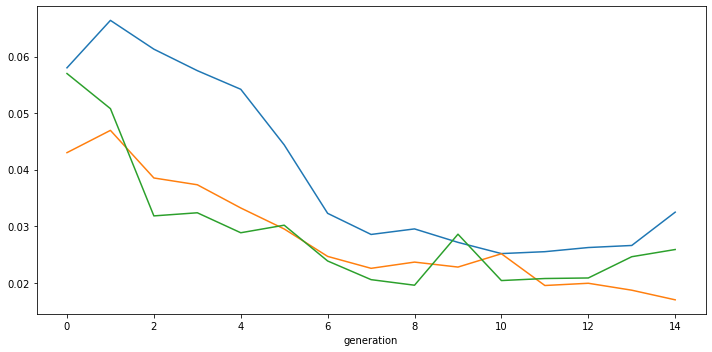

digen4


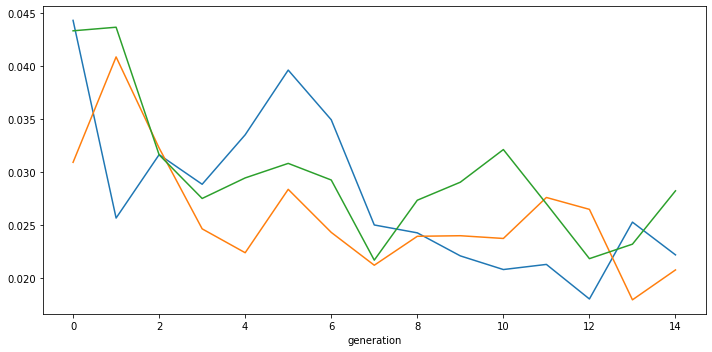

digen7


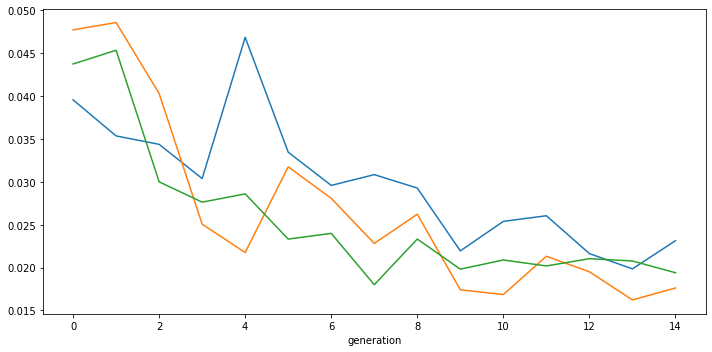

digen14


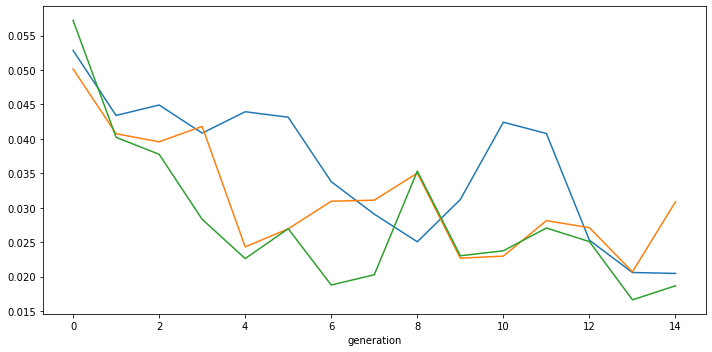

digen23


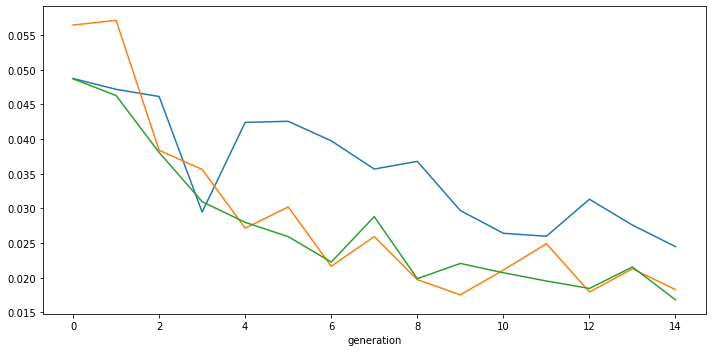

digen24


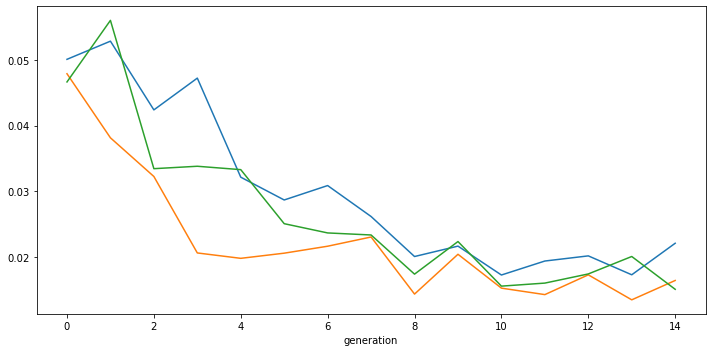

digen25


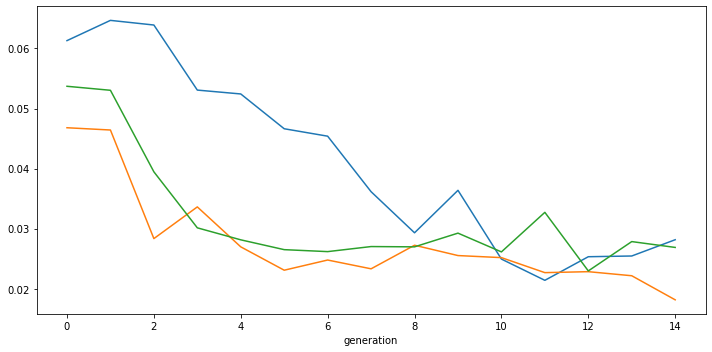

digen27


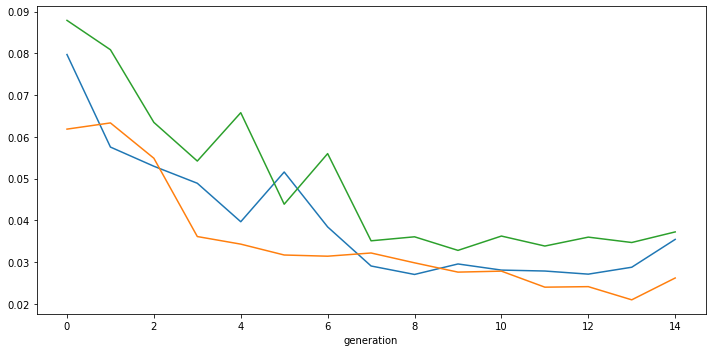

digen28


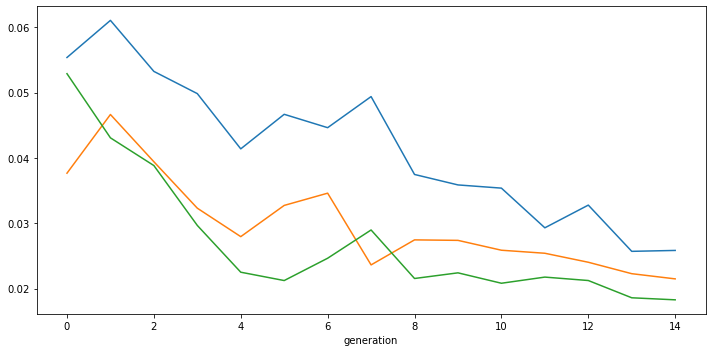

digen30


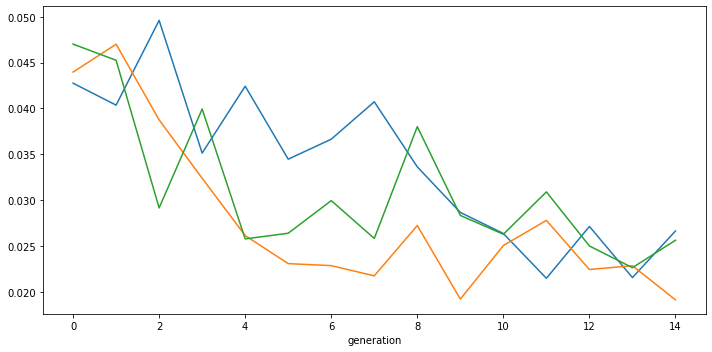

digen32


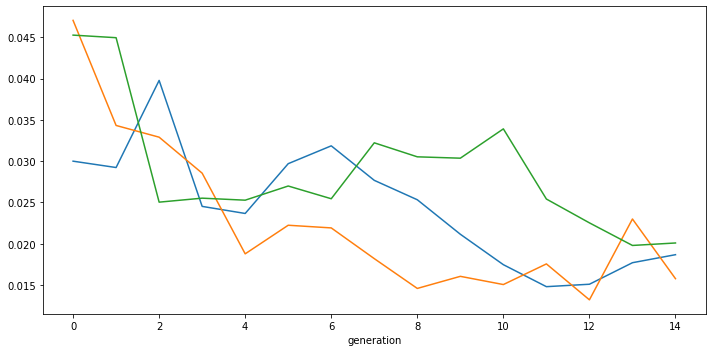

digen35


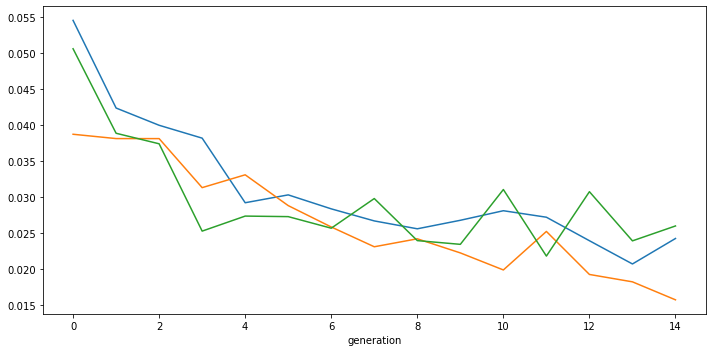

digen40


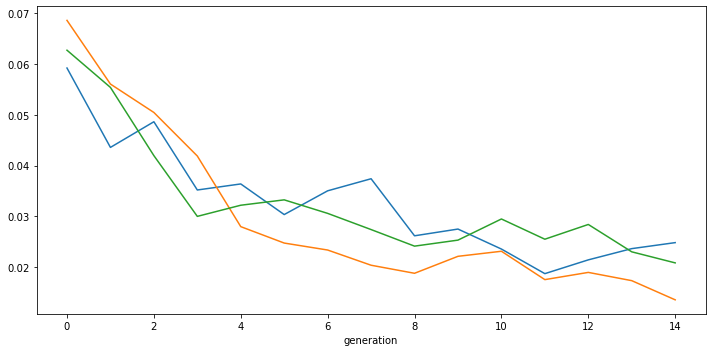

In [42]:
#analyze pareto quality 


from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import statistics

plt.rcParams["figure.figsize"] = (10,5)

directoryevs = ["baseline_pareto","lexicase_pareto","lexicase_gi_crossover_pareto"]
upper_quantile_only = False
for j in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
    print('digen'+str(j))
    ev = []
    for directoryev in directoryevs:
        temp_ev = []
        for i in range(15):
            ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen15_{directoryev}/pareto_fitnesses/digen{j}_run_{i}_evolution_pop40_gen15.csv"
            if not exists(ev_df_name):
                continue
            fitness_df = pd.read_csv(ev_df_name, sep=',')
            fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
            temp_ev.append(fitness_df)

        temp_ev = pd.concat(temp_ev)
        temp_ev["score_diff"] = abs(temp_ev["cv_score"]-temp_ev["holdout_score"])

        
        #print(directoryev)
        #print(temp_ev.groupby("generation")["score_diff"].mean())
        temp_ev = temp_ev.groupby("generation")["score_diff"].mean()
        temp_ev.plot()
        #ev.append(temp_ev)
    #frame_df = pd.concat(ev)
    plt.savefig(f"/Users/matsumoton/Git/meta_pop40_gen15/gen_fitnesses/digen{j}_pop40_gen15_pareto_diff.png")
    plt.show()





In [ ]:


from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import statistics

plt.rcParams["figure.figsize"] = (30,16)

#directoryevs = ["/Users/matsumoton/Git/results_pop40_gen15_baseline/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gaussian_integral/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gaussian_integral_v2/gen_fitnesses/",
#    "/Users/matsumoton/Git/results_pop40_gen15_gi_crossover/gen_fitnesses/"]

directoryevs = ["baseline","gaussian_integral","gaussian_integral_v2","gi_crossover","crossover_only","crossover_only_v2"]
#directoryevs = ["baseline","gi_crossover"]

#directoryevs = ["baseline","gaussian_integral_v2"]
directoryevs = ["baseline","gi_crossover"]
directoryevs = ["baseline","gi_crossover","crossover_only_v1","crossover_only_v2","crossover_only_v3","crossover_only_v4","crossover_only_v5"]
directoryevs = ["baseline","crossover_only_v1","crossover_only_v4","crossover_only_v2","crossover_only_v3","crossover_only_v5","crossover_only_v6","crossover_only_v7","crossover_only_v8","crossover_only_v9"]
#directoryevs = ["baseline","crossover_only_v1","crossover_only_v4","crossover_only_v2","crossover_only_v3","crossover_only_v5","crossover_only_v8","crossover_only_v9"]
#directoryevs = ["baseline","crossover_only_v1","crossover_only_v3","crossover_only_v5"]
#directoryevs = ["baseline","gi_crossover", "crossover_only_v1","crossover_only_v8","crossover_only_v9"]
#directoryevs = ["baseline","gaussian_integral_v2","gi_crossover","crossover_only_v8","gi_crossover_with_v8","mut_v1_crossover_v8"]
directoryevs = ["baseline","gi_crossover","crossover_only_v8","gi_crossover_with_v8","mut_v1_crossover_v8","mut_v2_crossover_v8"]

for j in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
    print(j)
    ev = []
    for directoryev in directoryevs:
        temp_ev = []
        for i in range(10):
            ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen15_{directoryev}/gen_fitnesses/digen{j}_run_{i}_evolution_pop40_gen15.csv"
            fitness_df = pd.read_csv(ev_df_name, sep=',')
            temp_ev.append(fitness_df)

        temp_ev = pd.concat(temp_ev)
        temp_ev["type"] = directoryev
        ev.append(temp_ev)
    frame_df = pd.concat(ev)
    frame_df = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]

    
    #median normalized
#    for i in range(0,15):
#        median_gen = statistics.median(frame_df.loc[(frame_df['type']=='baseline')&(frame_df['generation']==i)]['score'])
#        frame_df.loc[frame_df['generation']==i,'score']=frame_df.loc[frame_df['generation']==i]['score'].div(median_gen)

    for directoryev in directoryevs:
        #seaborn.violinplot(x="generation",y="score",hue="type",data=frame_df, label = "type" if i == 0 else "")
        #plt.show()
        ax = sns.boxplot(x="generation",y="score",hue="type",data=frame_df)
        #plt.show()
        #ax = sns.swarmplot(x="generation",y="score",hue="type",data=frame_df,color=".25")

    plt.show()



1


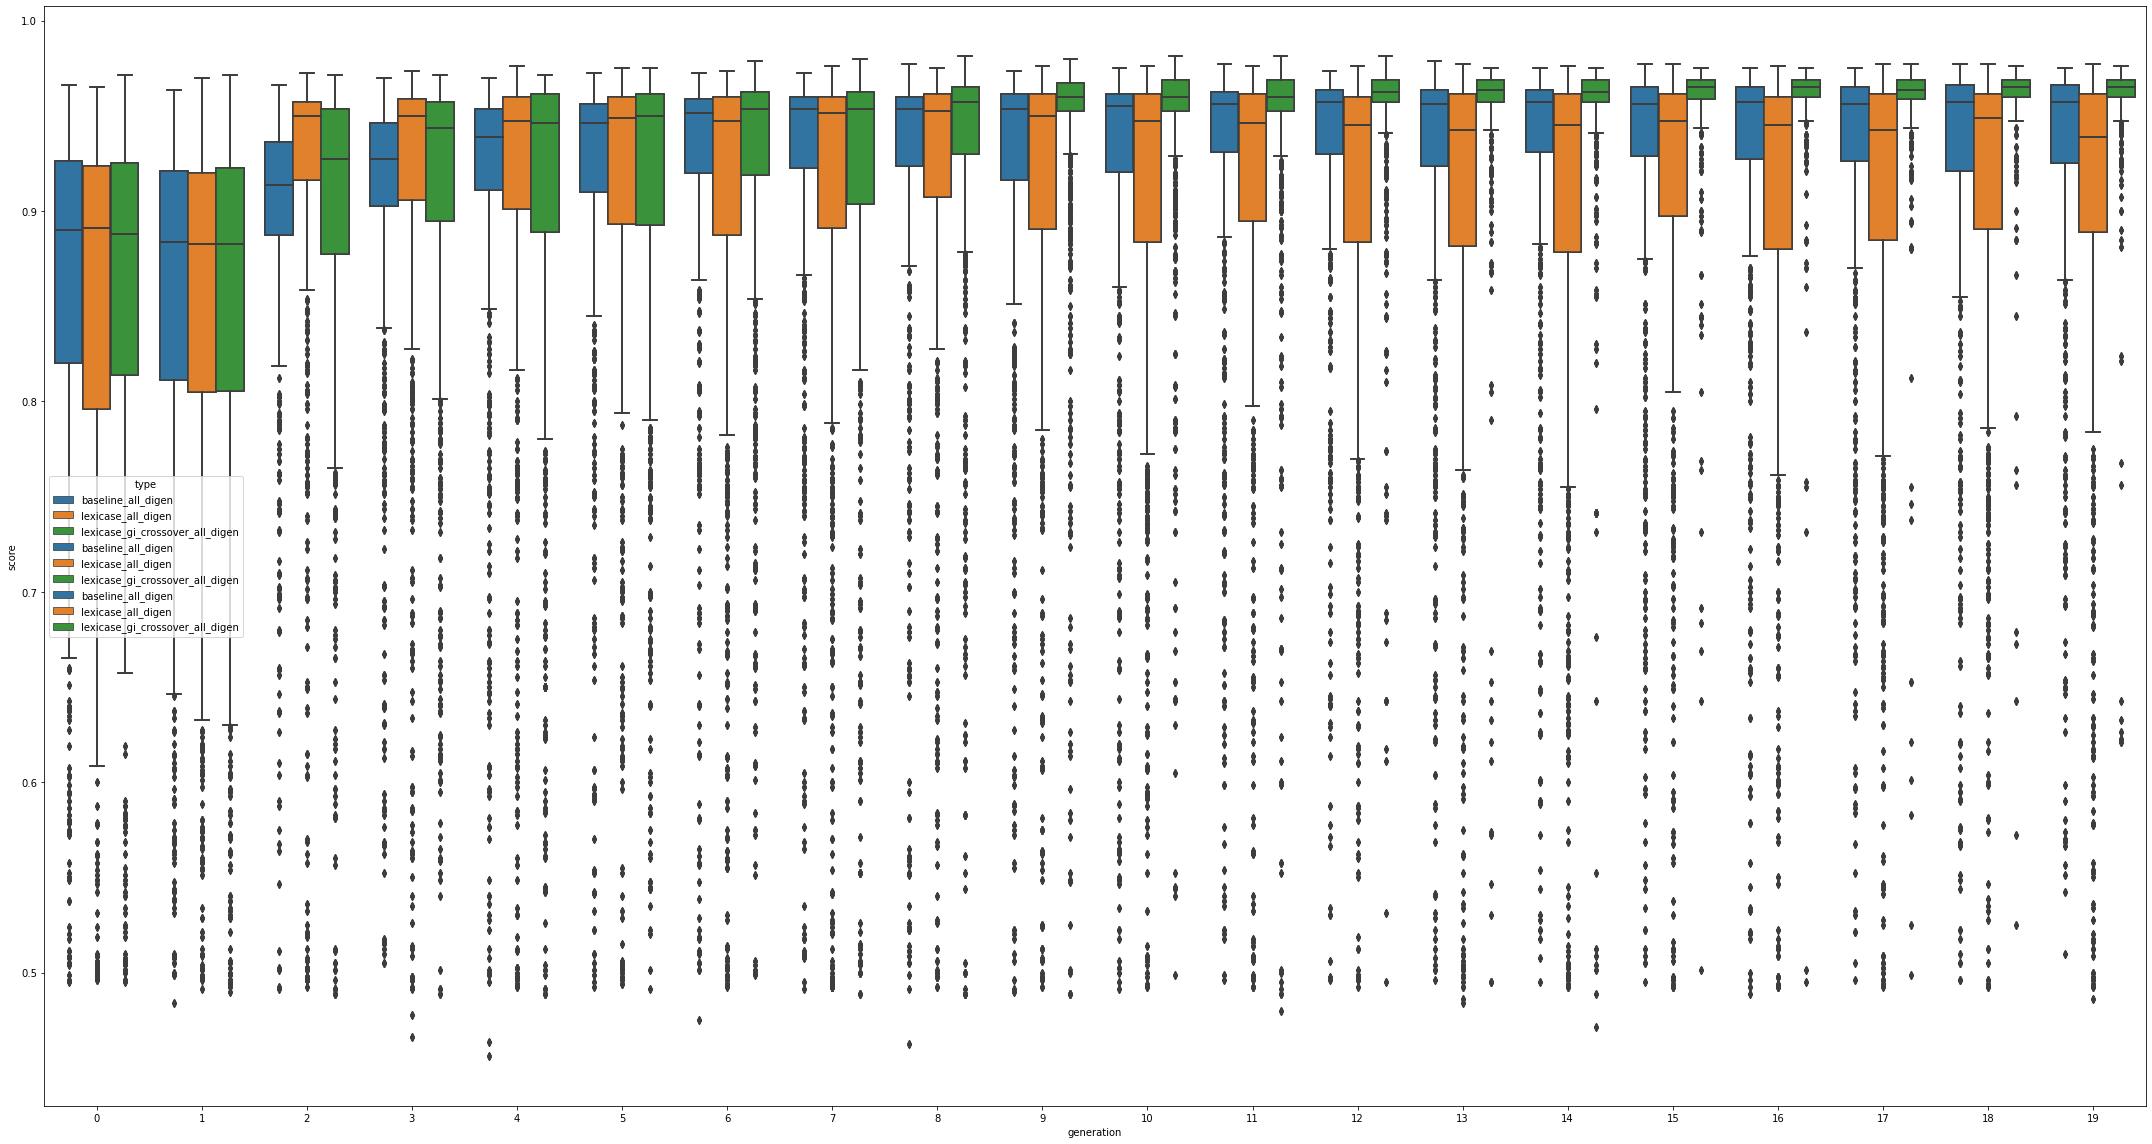

2


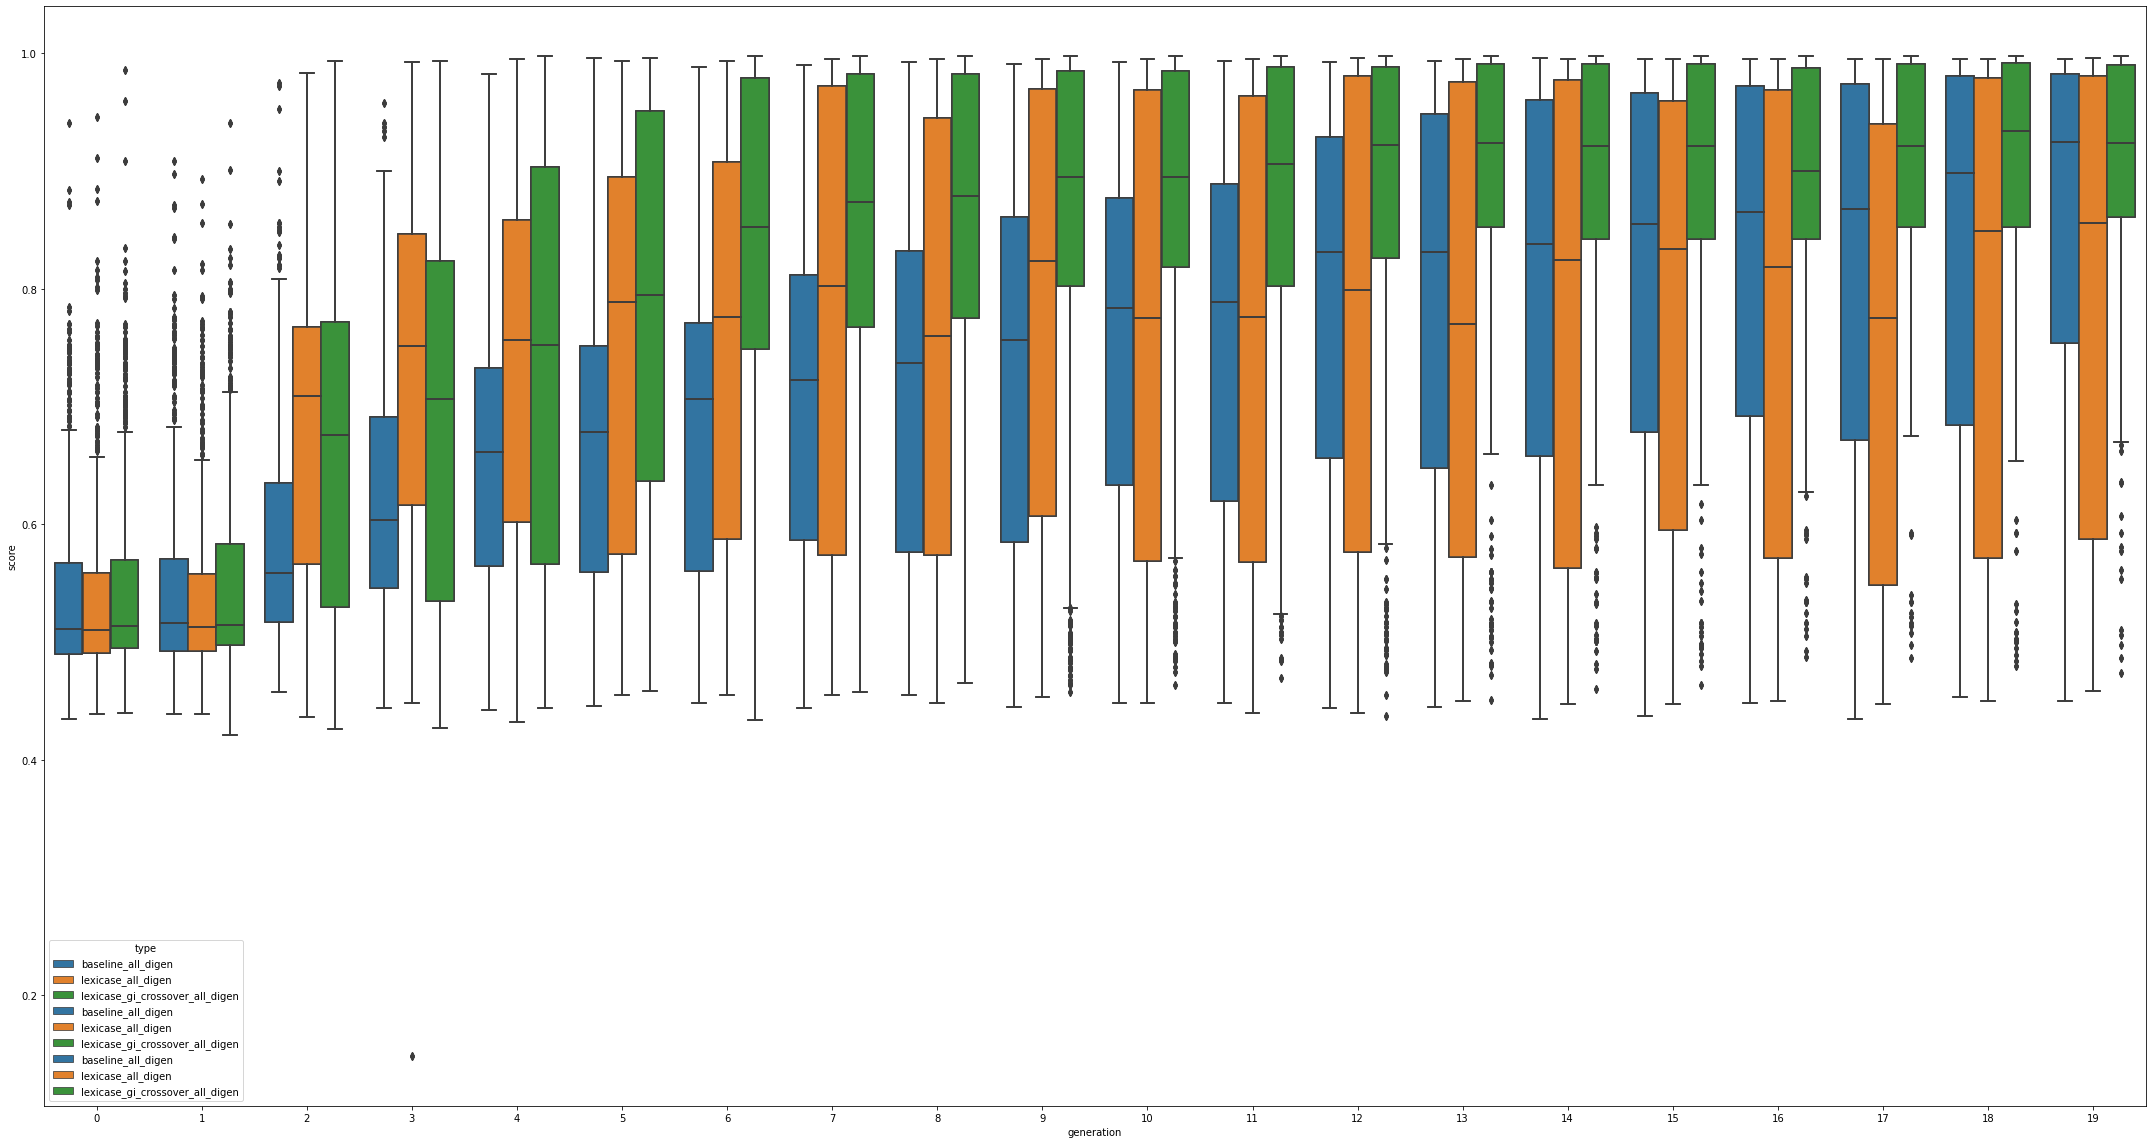

3


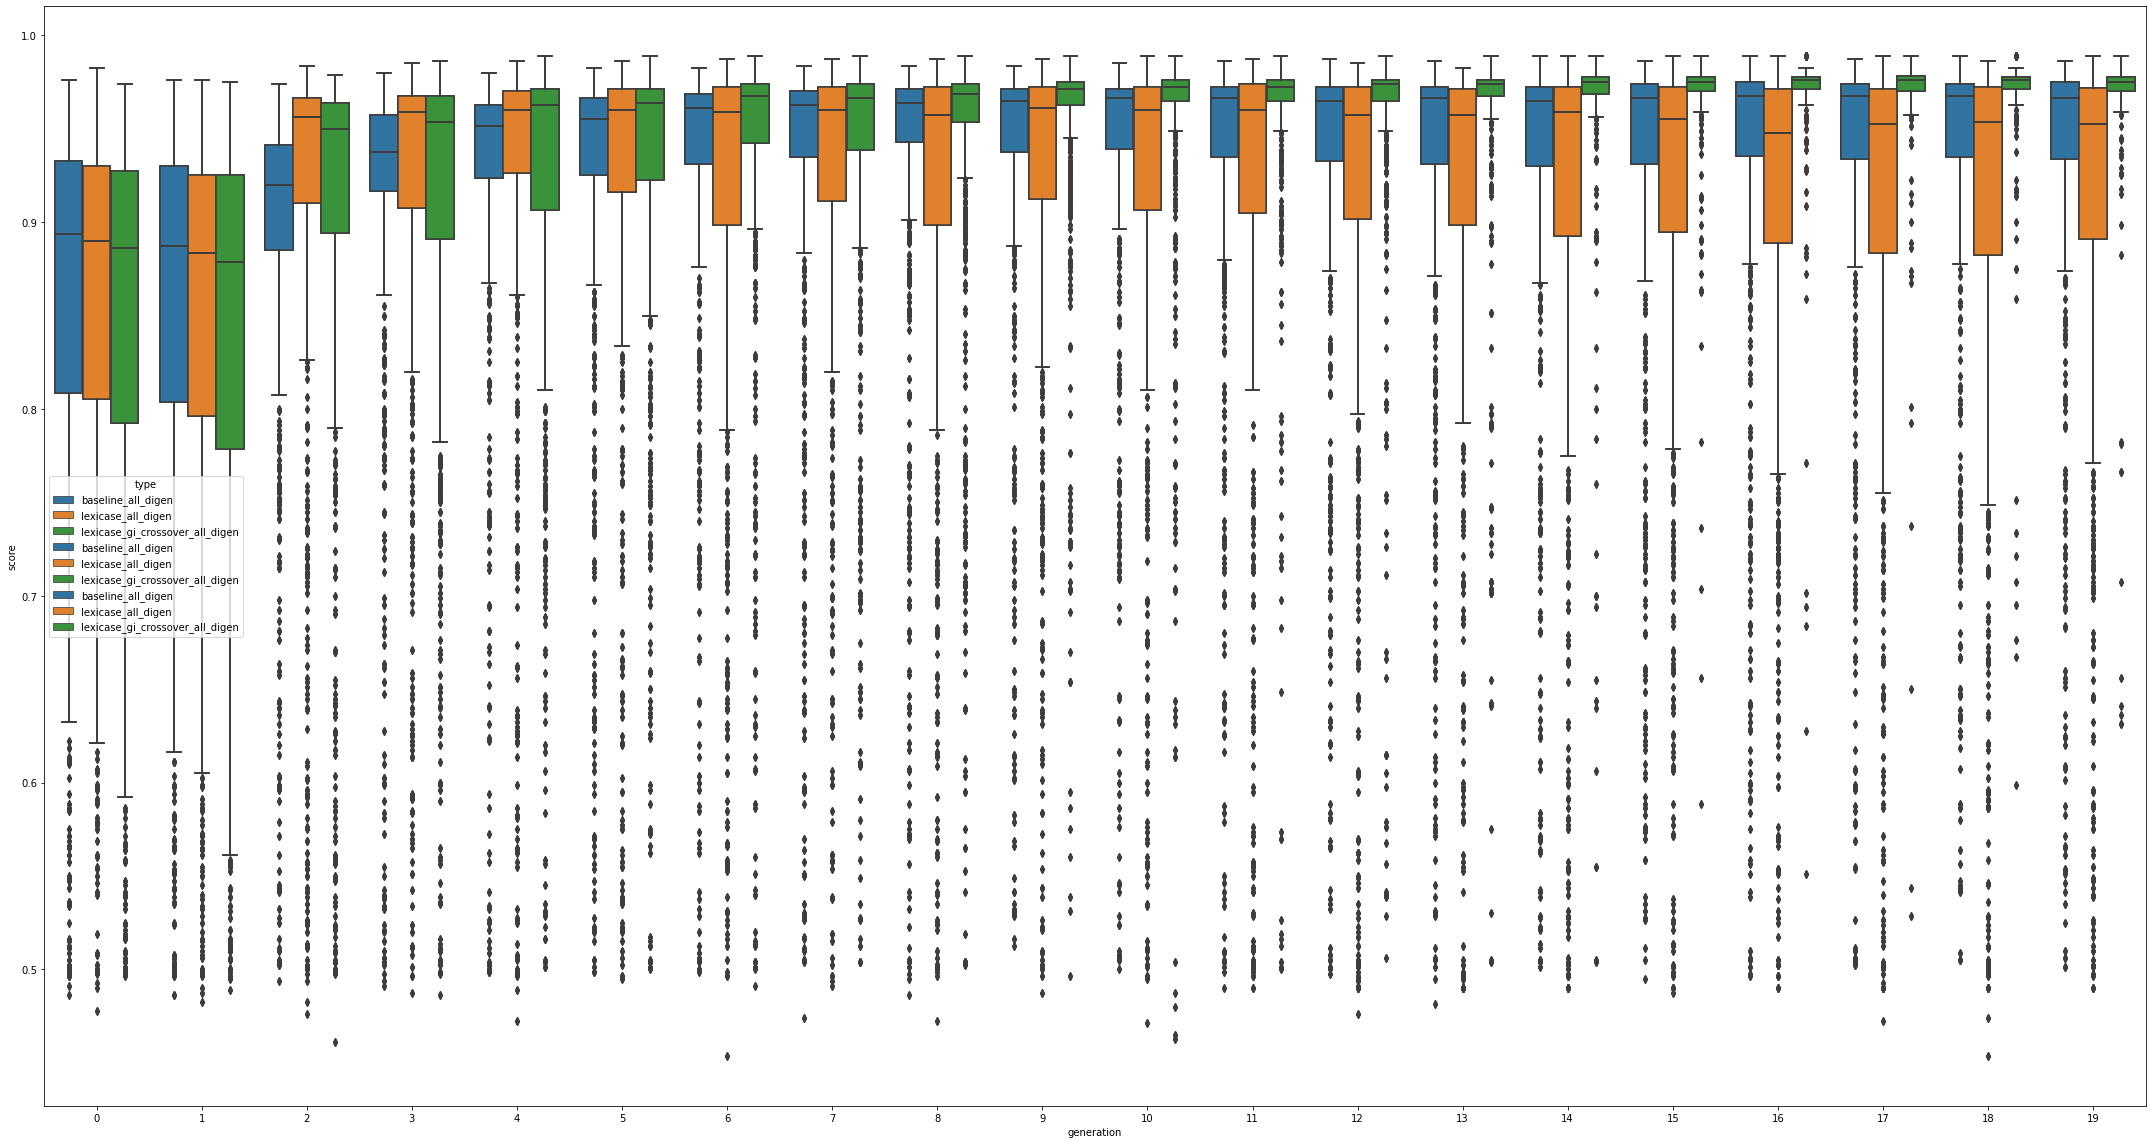

4


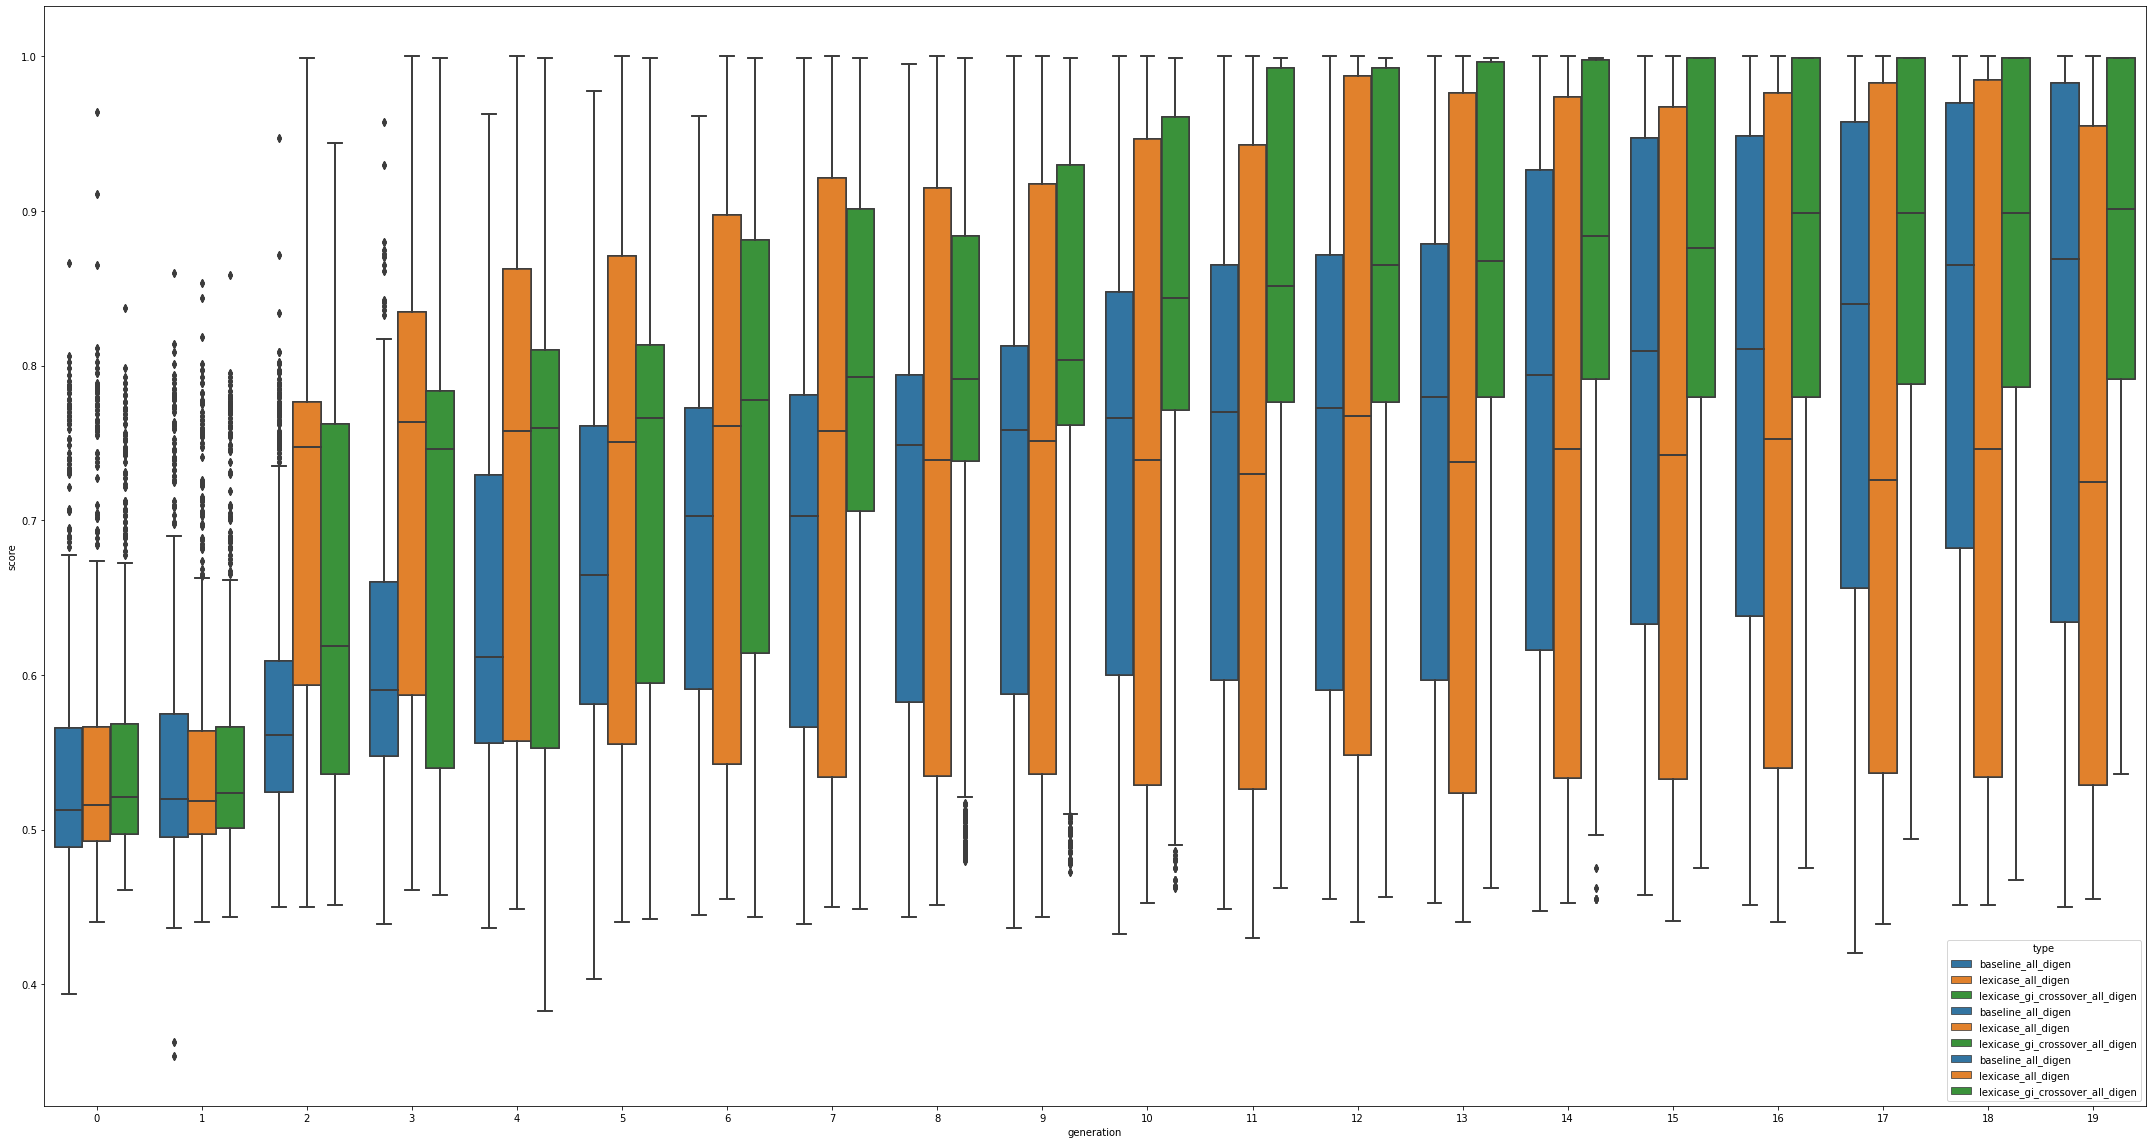

5


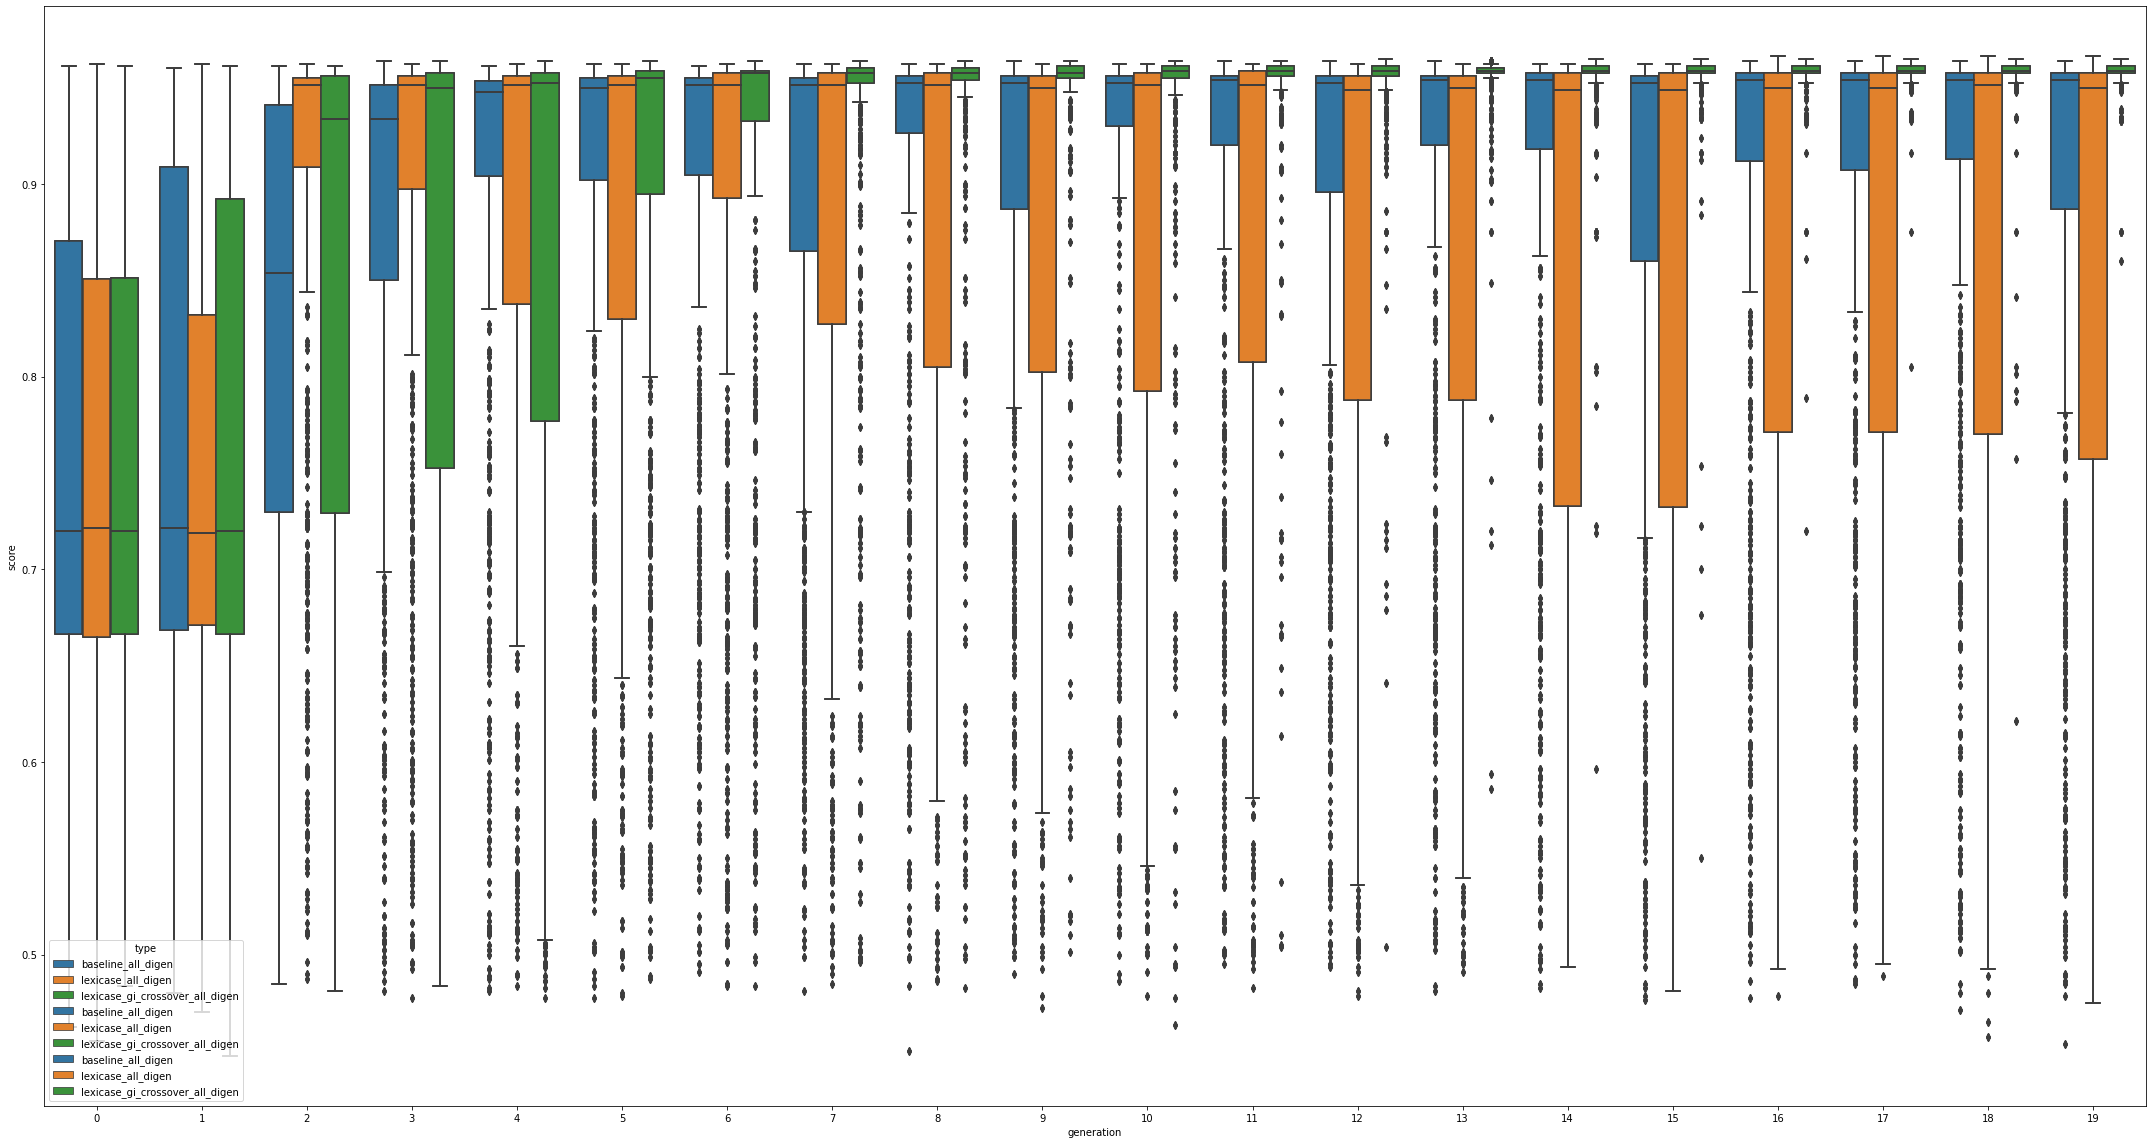

6


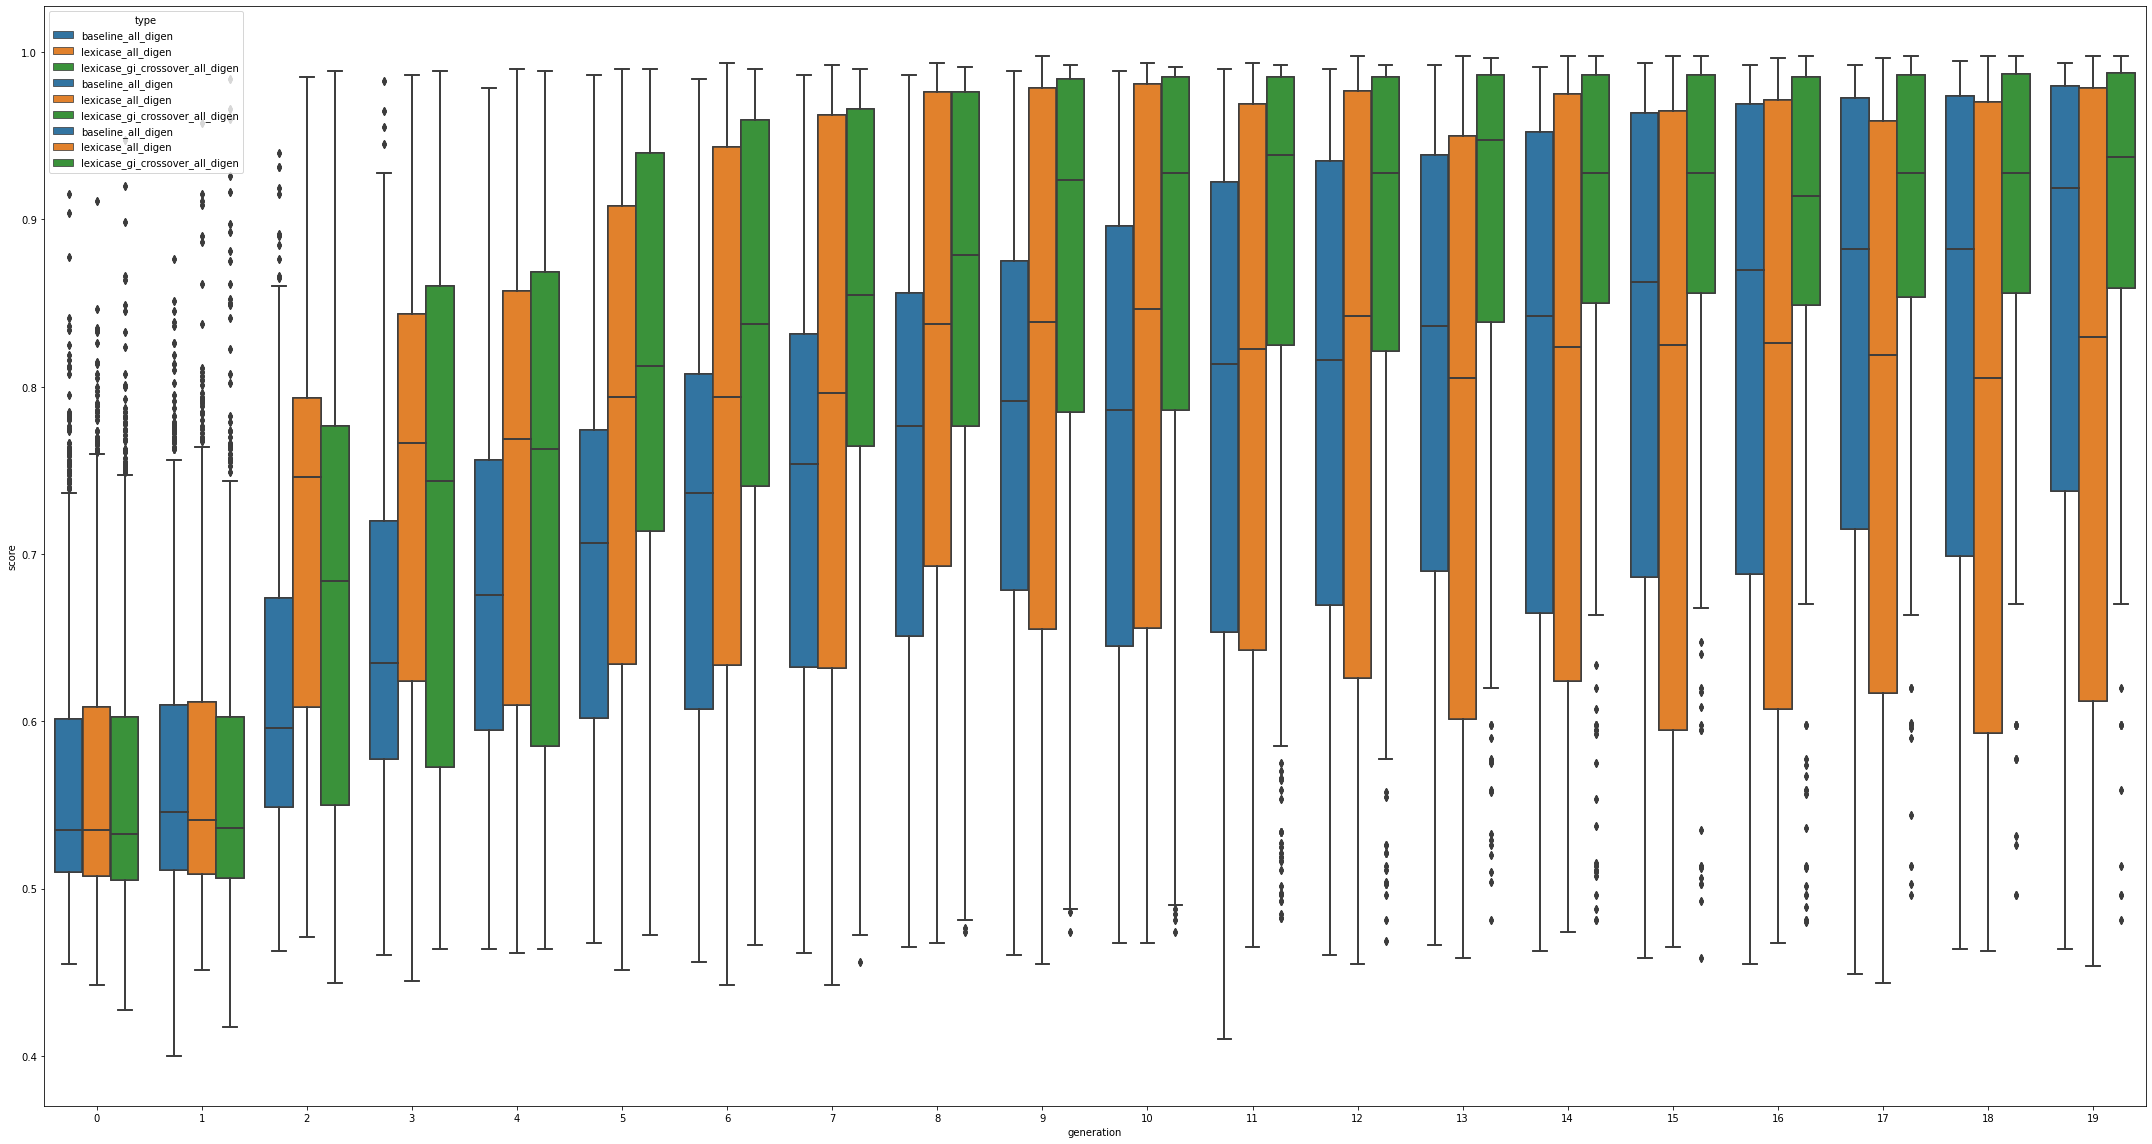

7


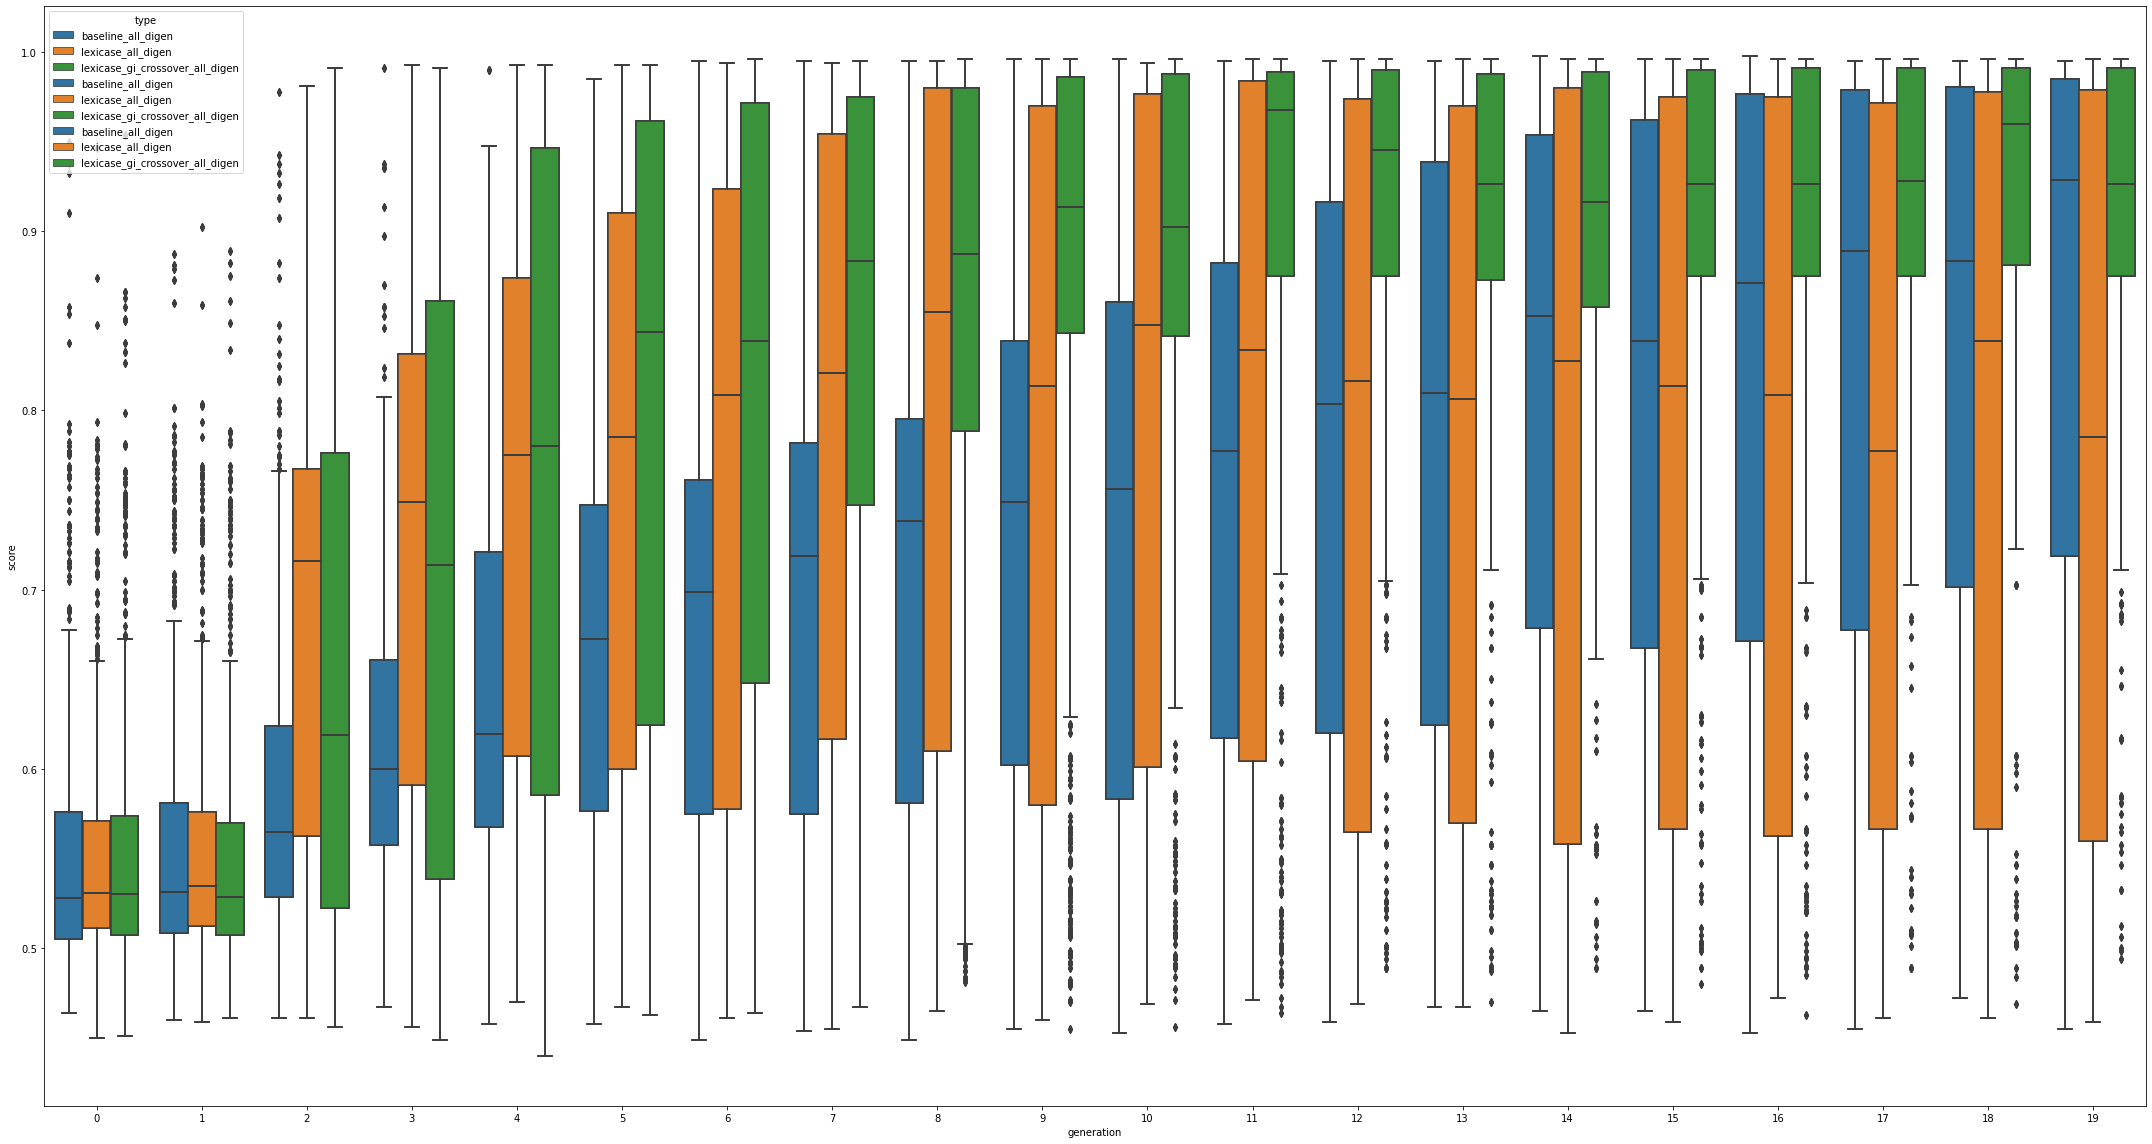

8


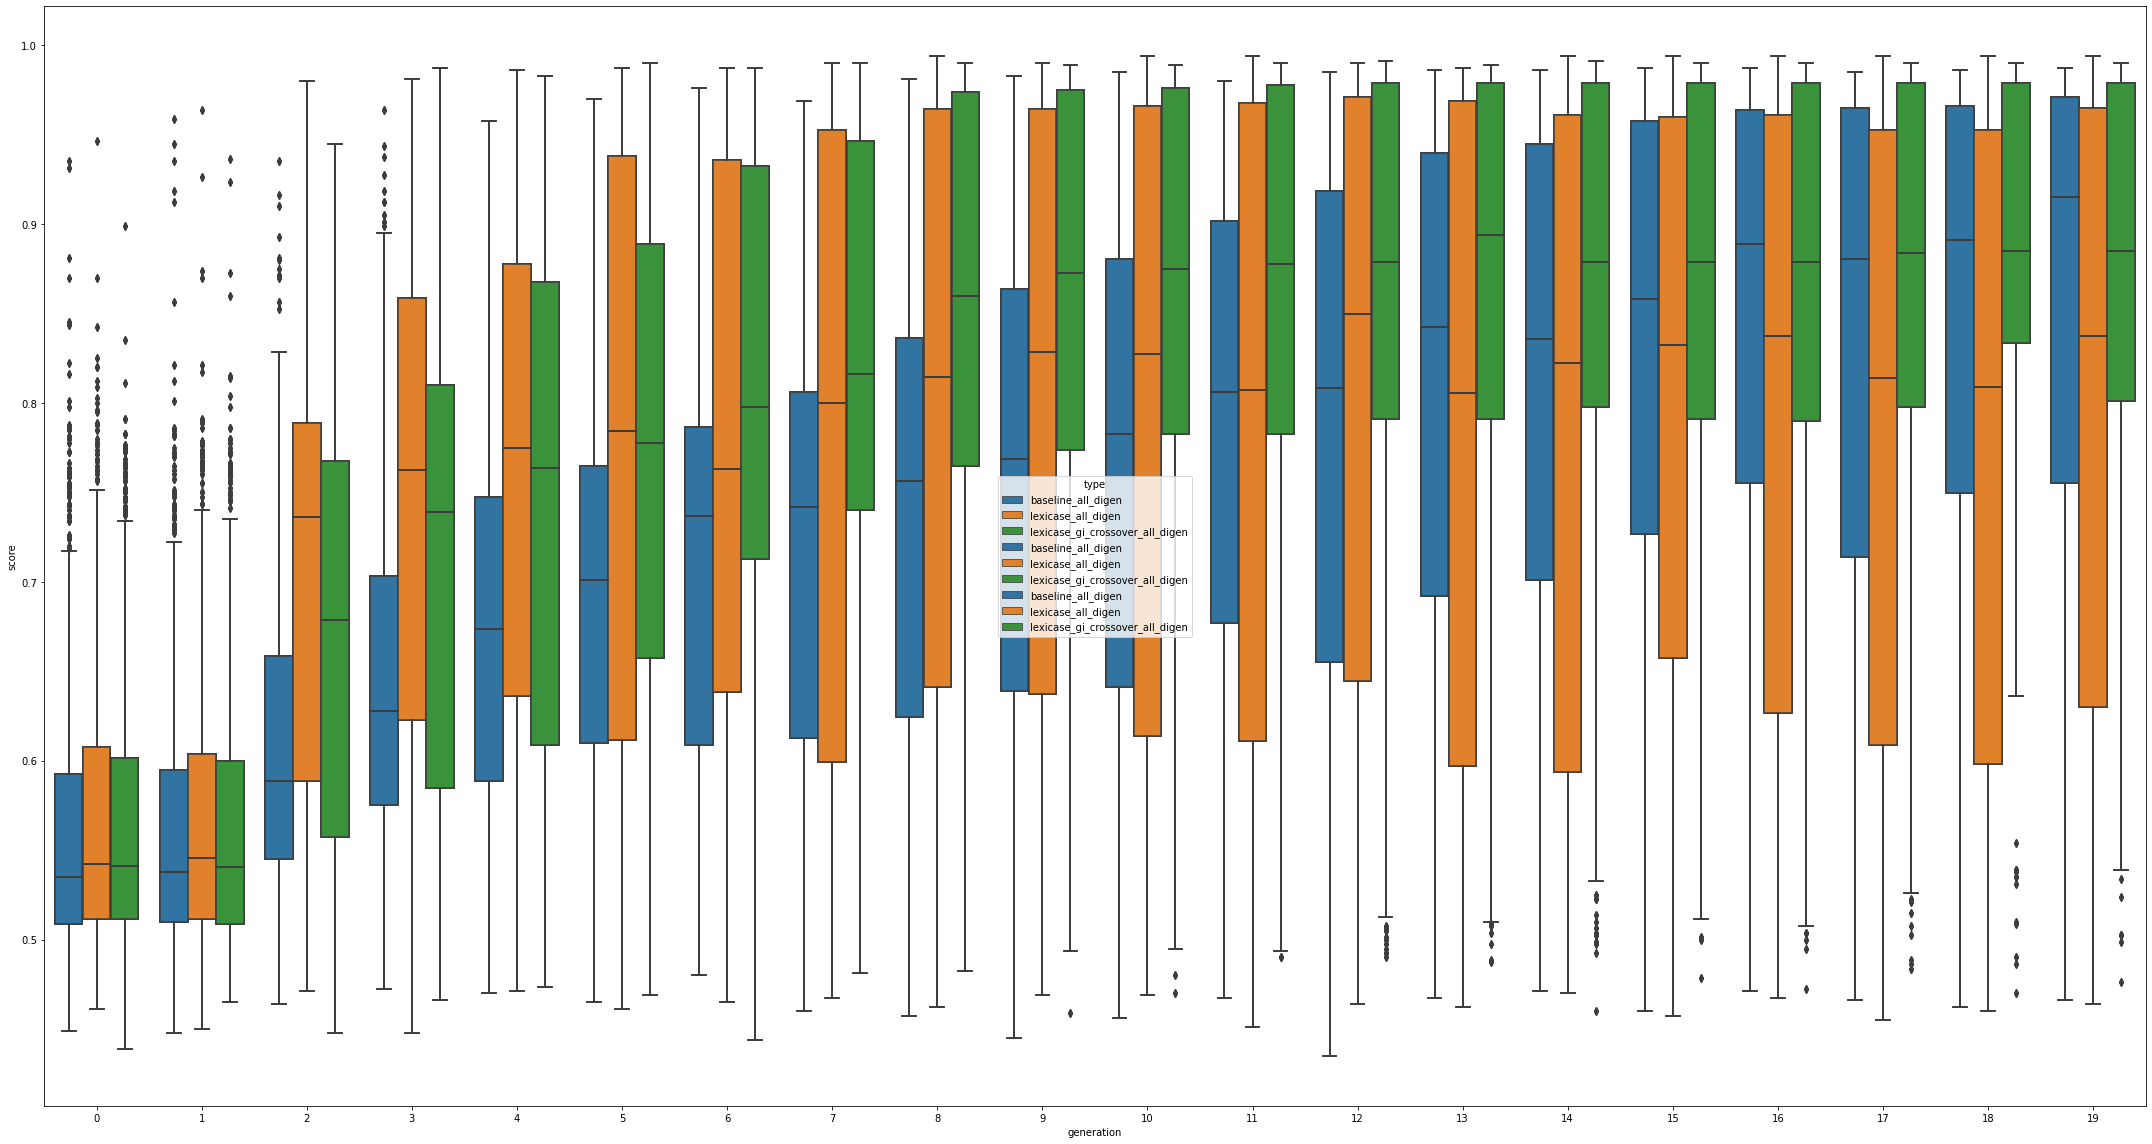

9


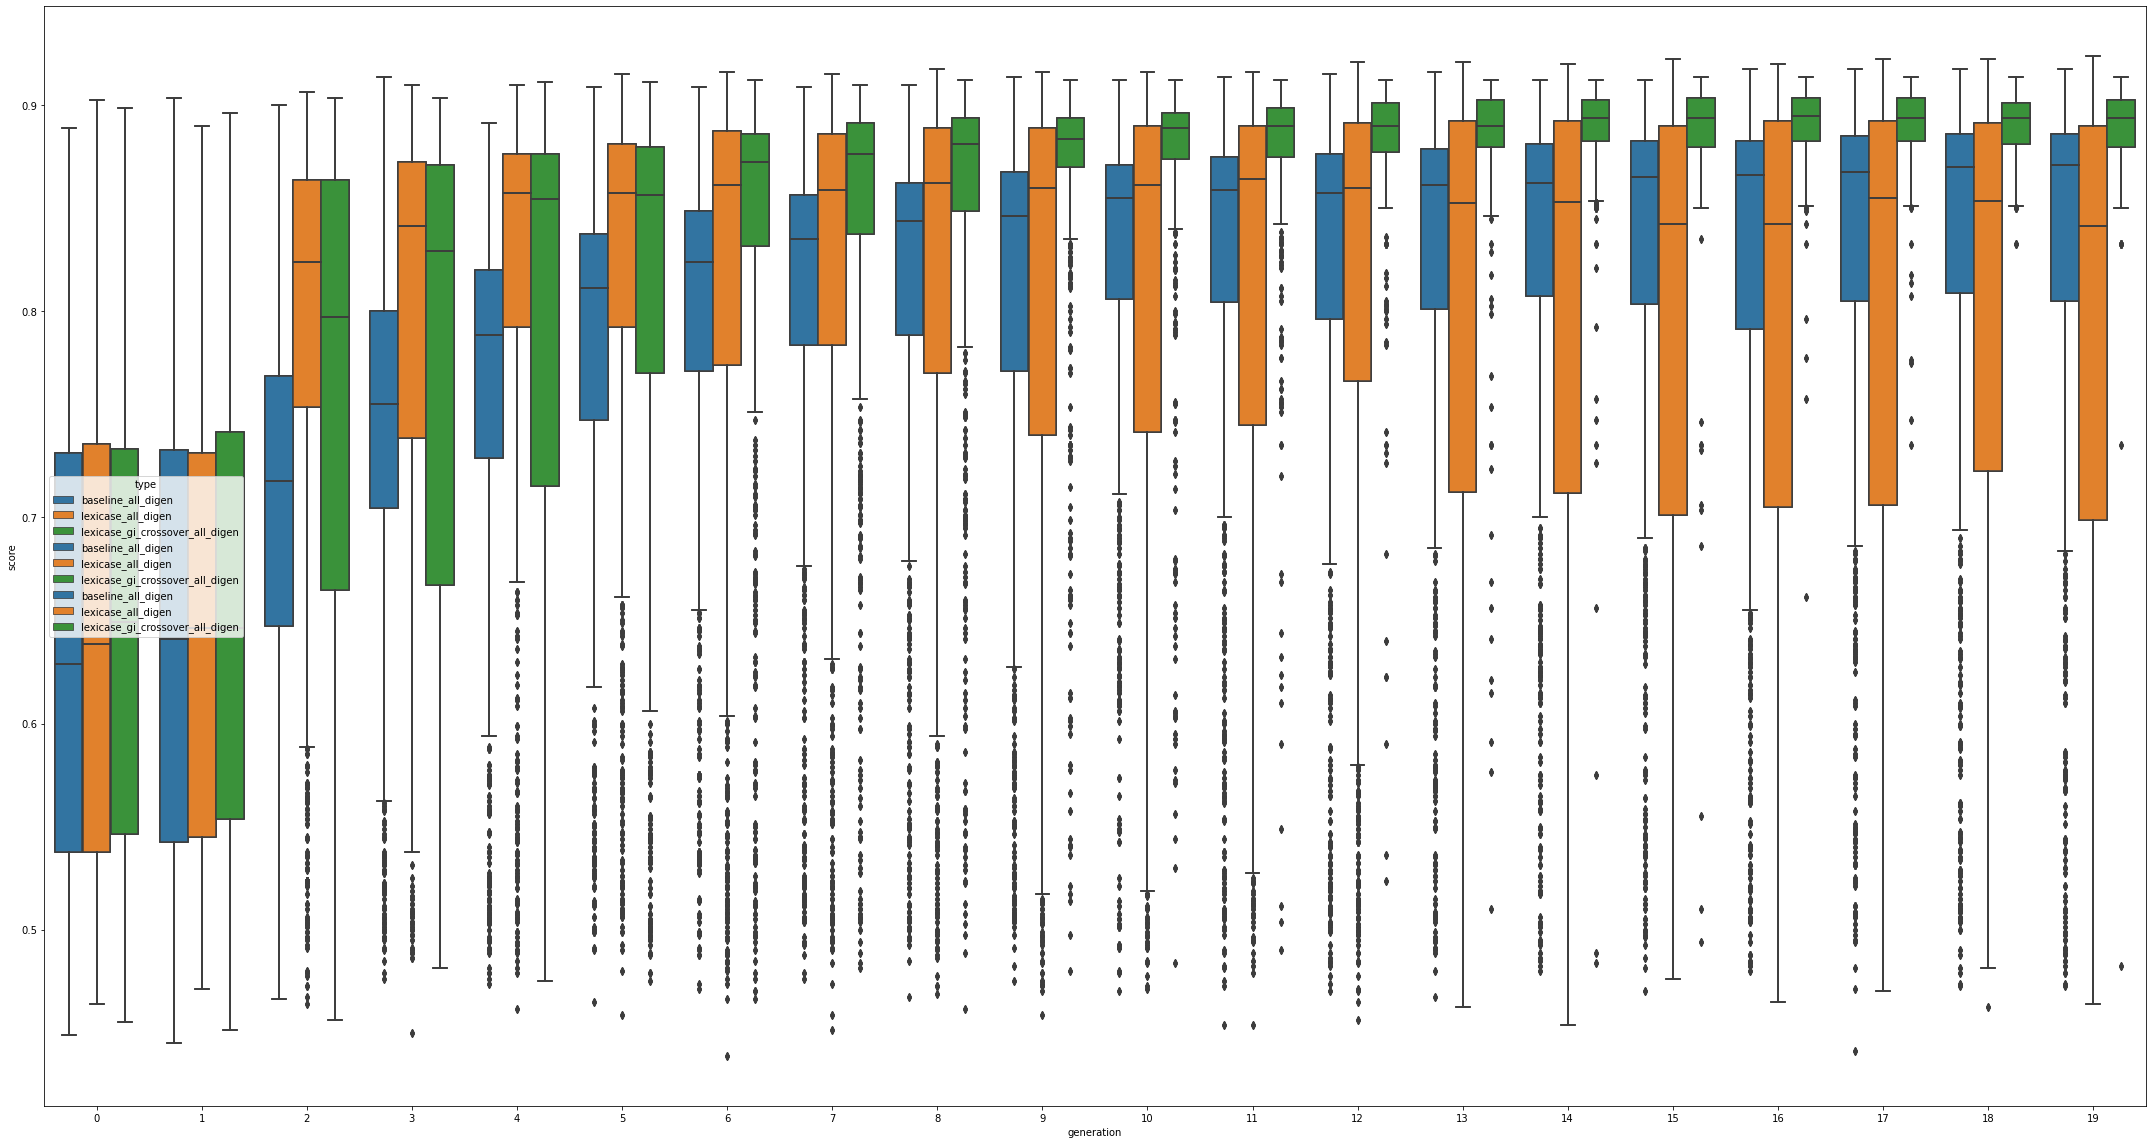

10


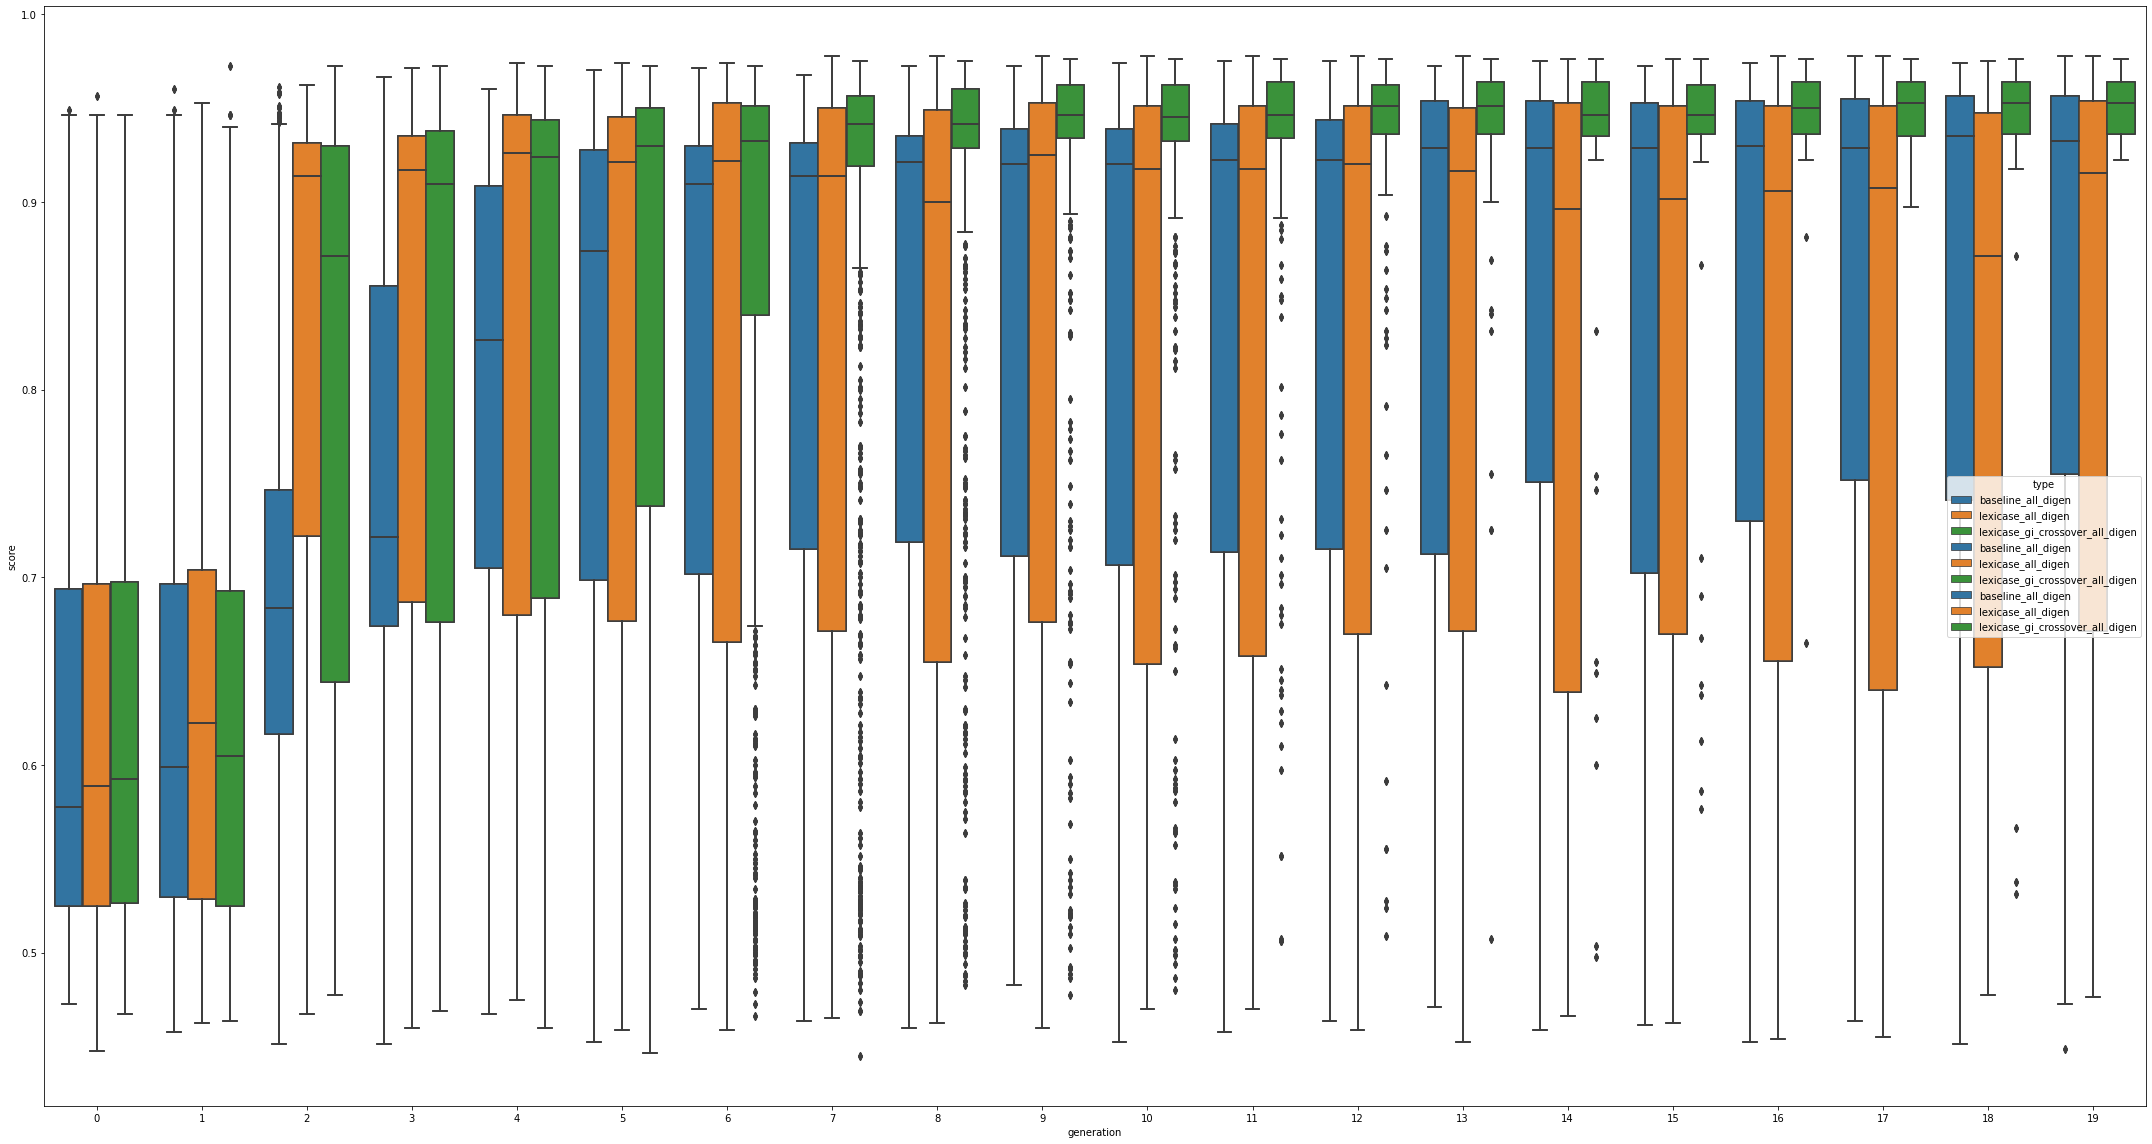

11


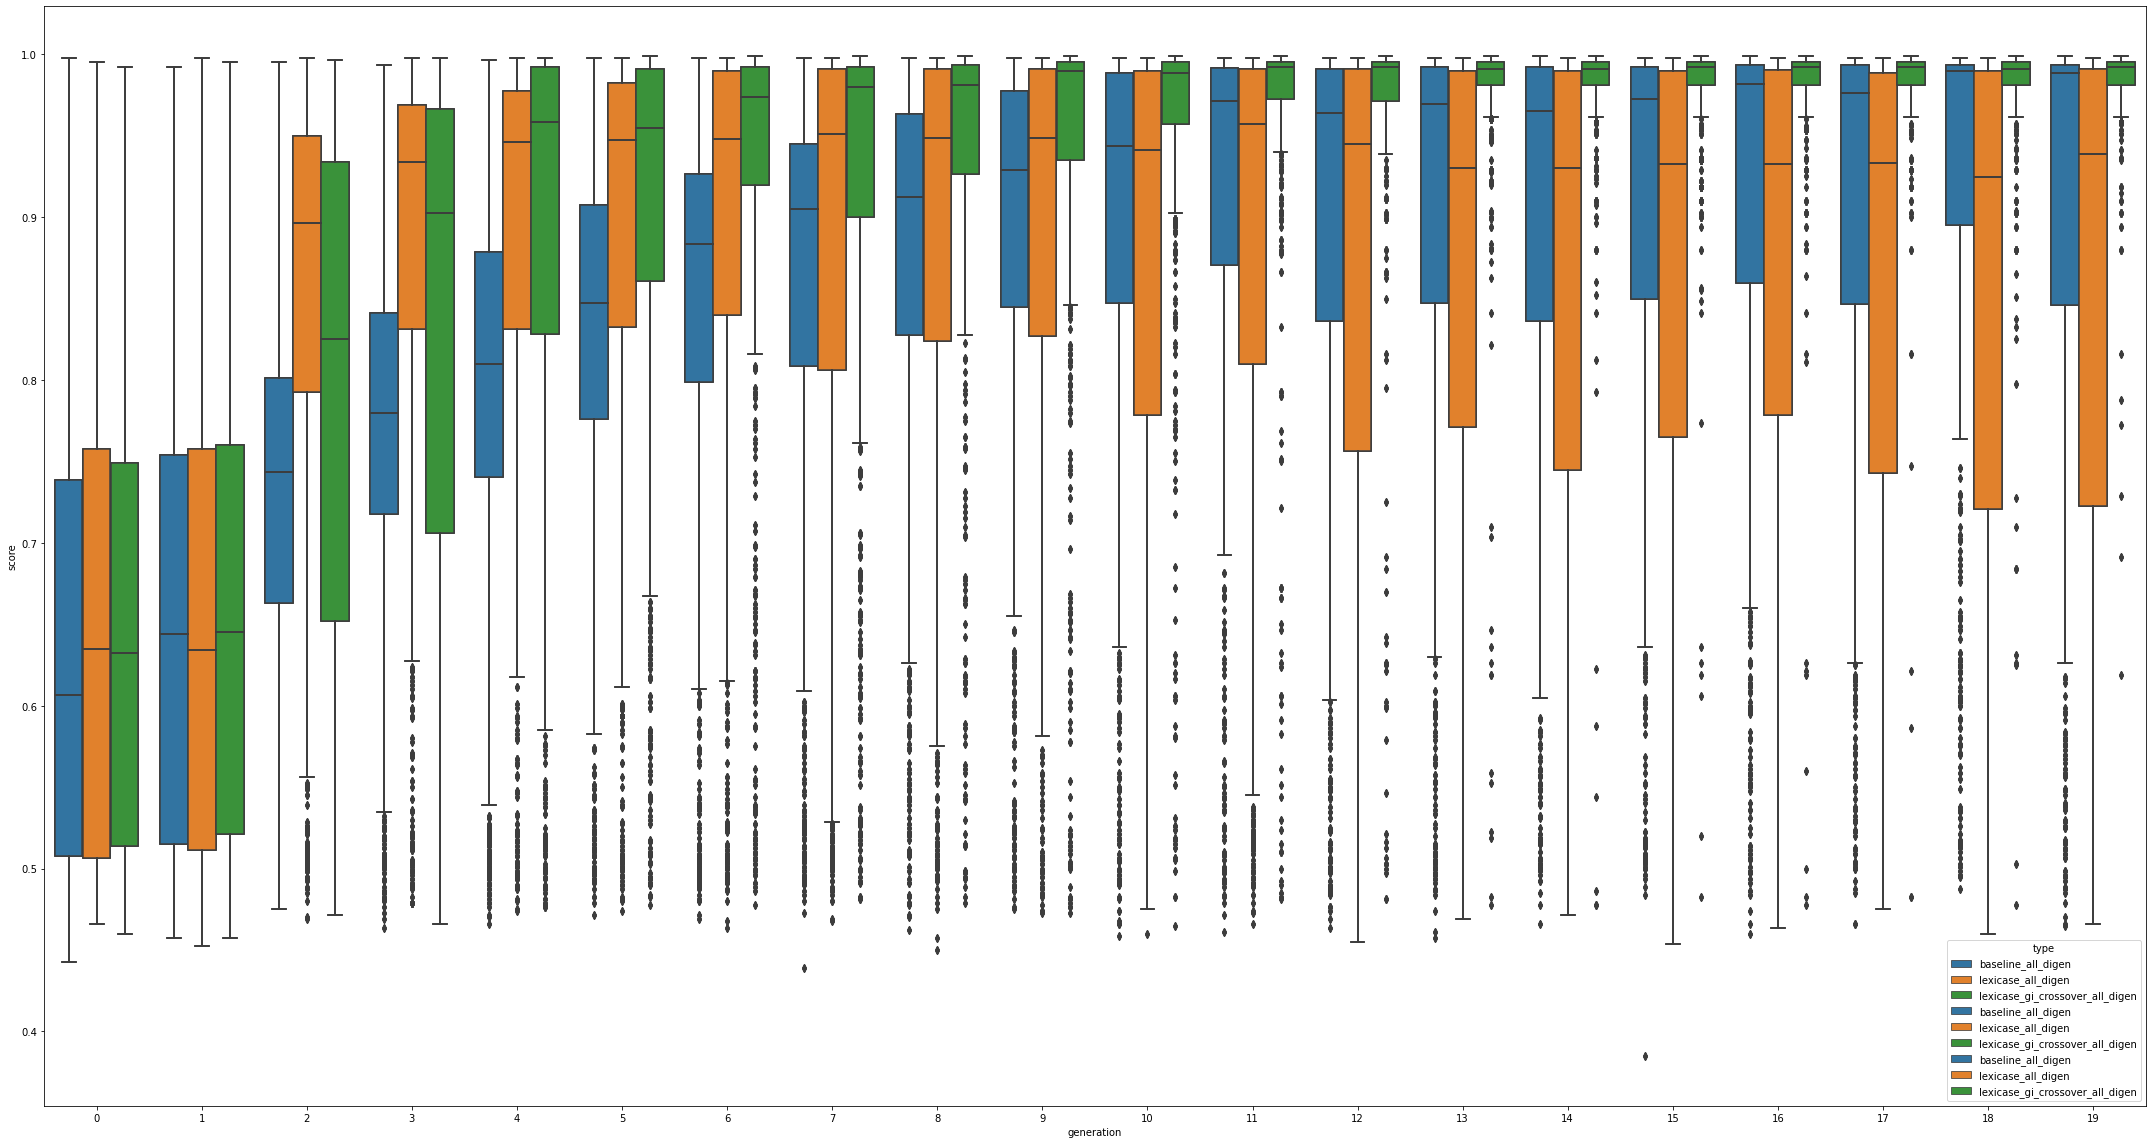

12


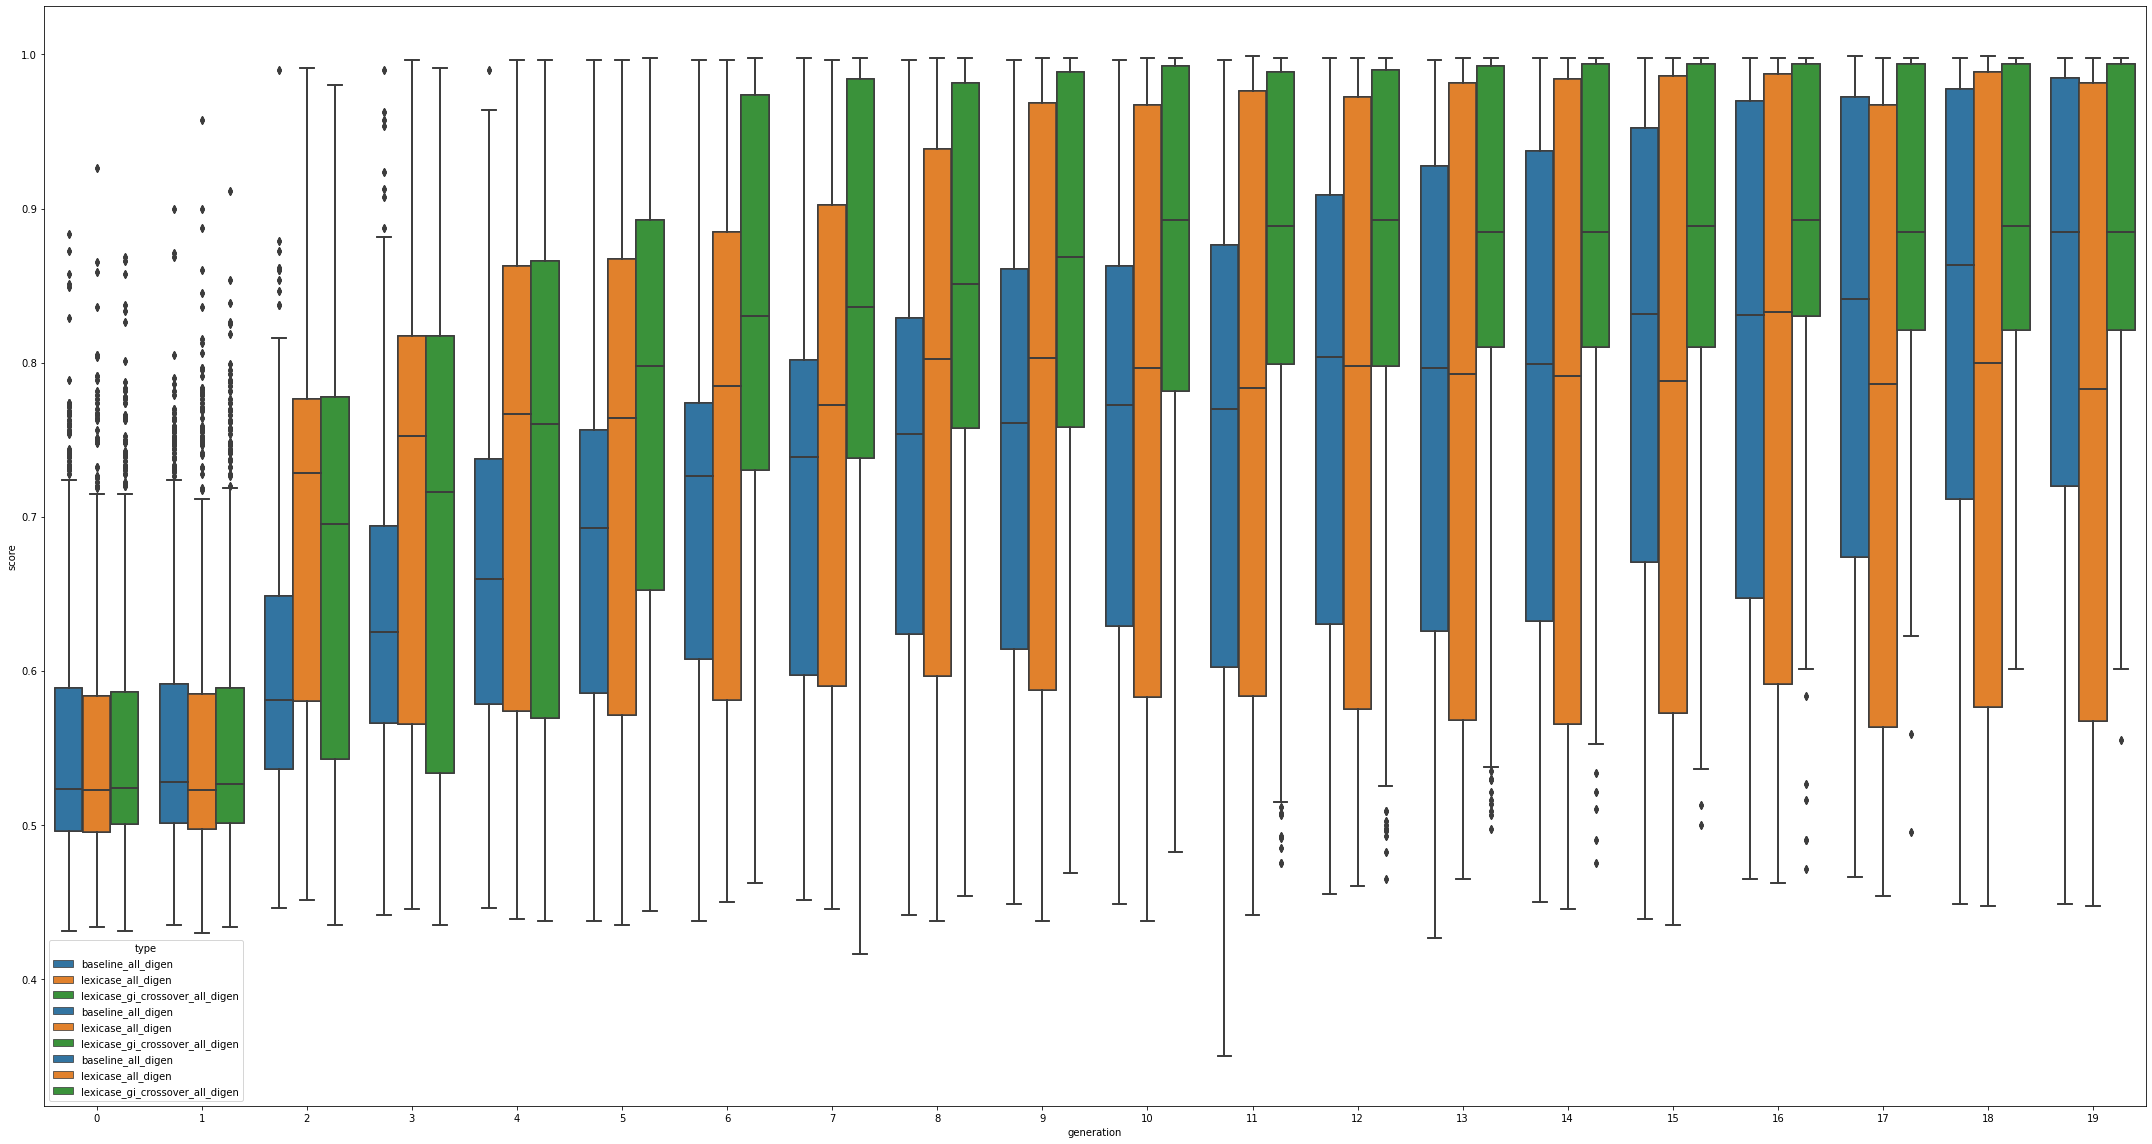

13


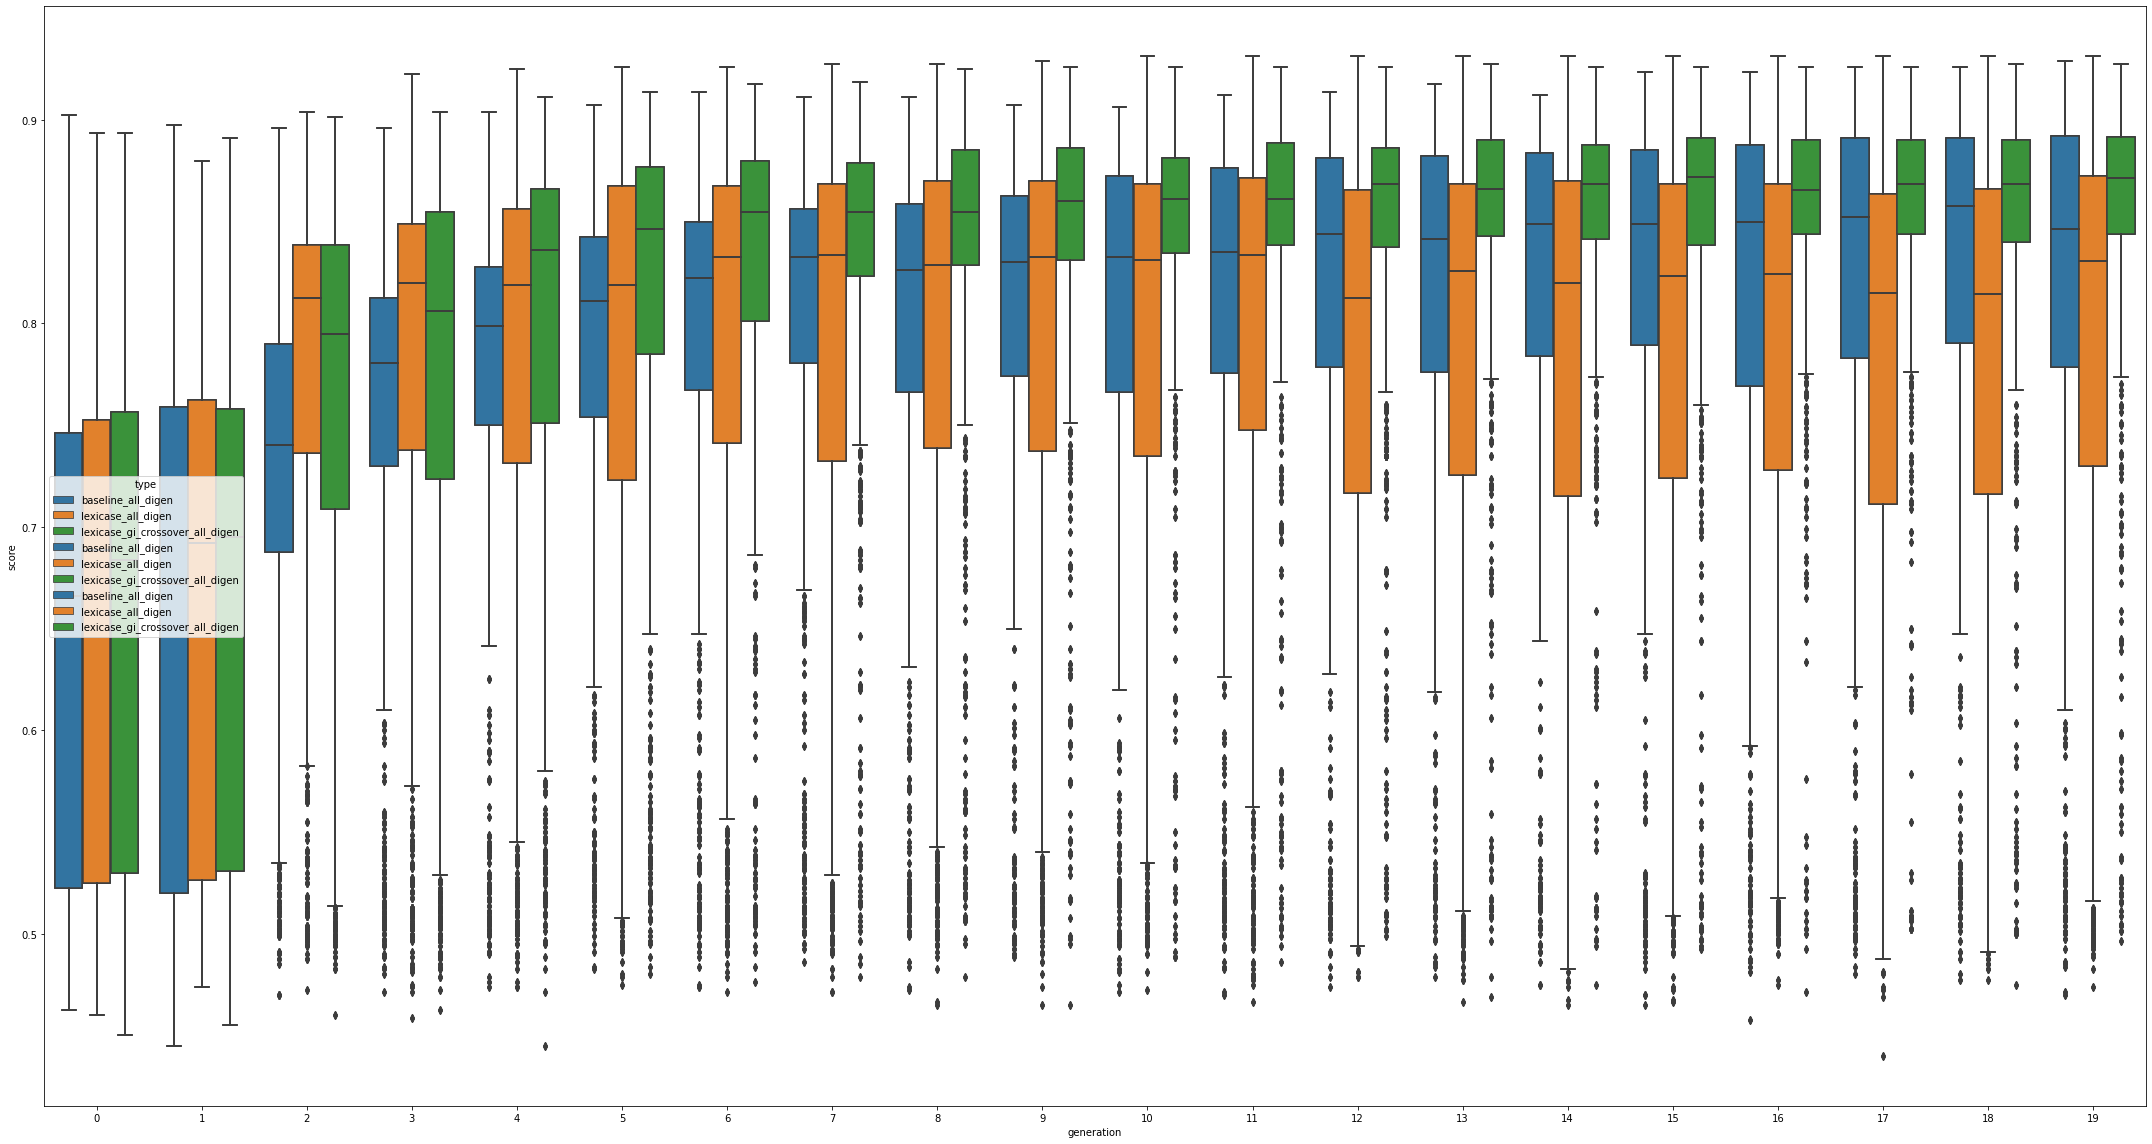

14


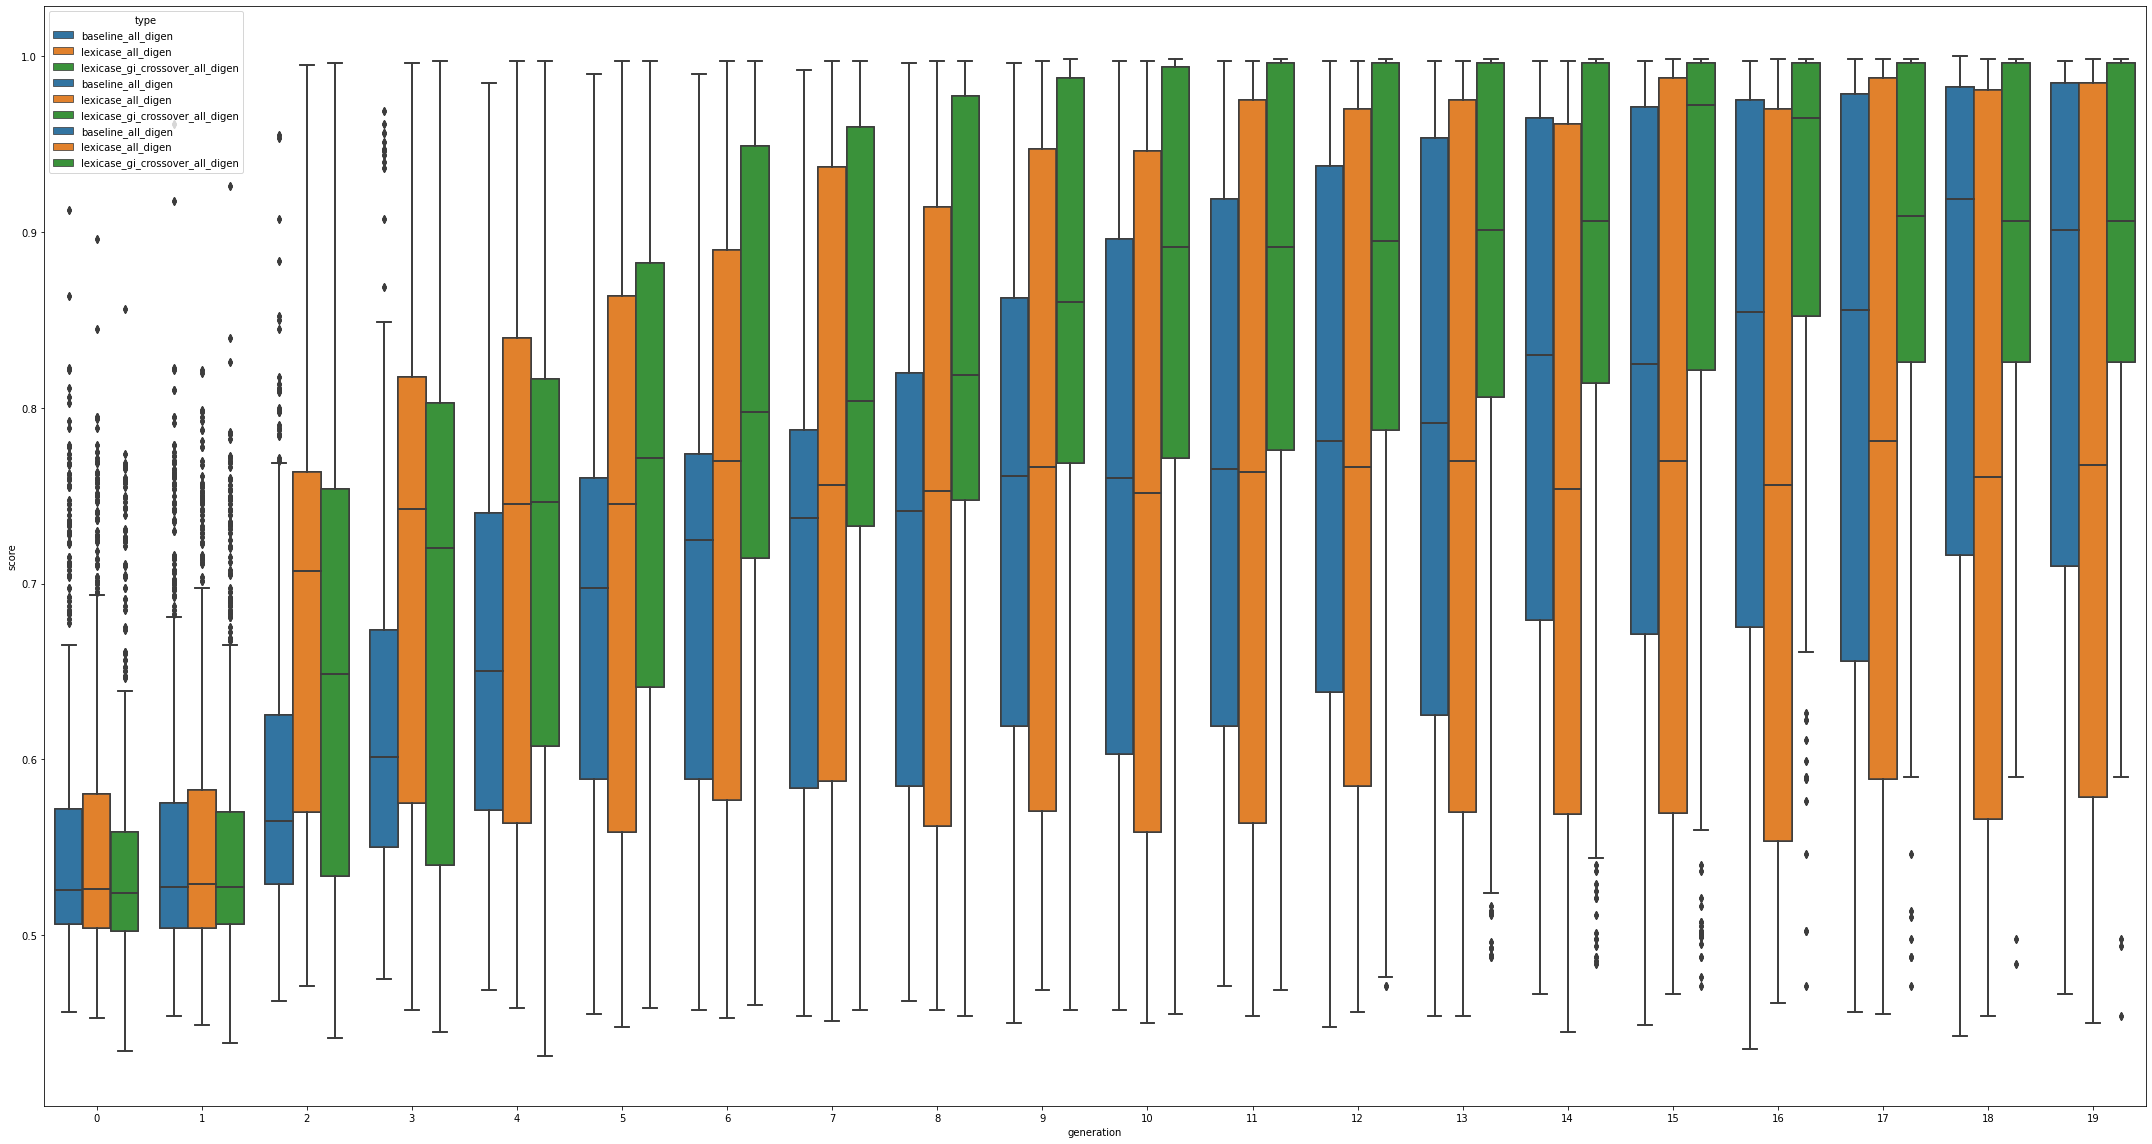

15


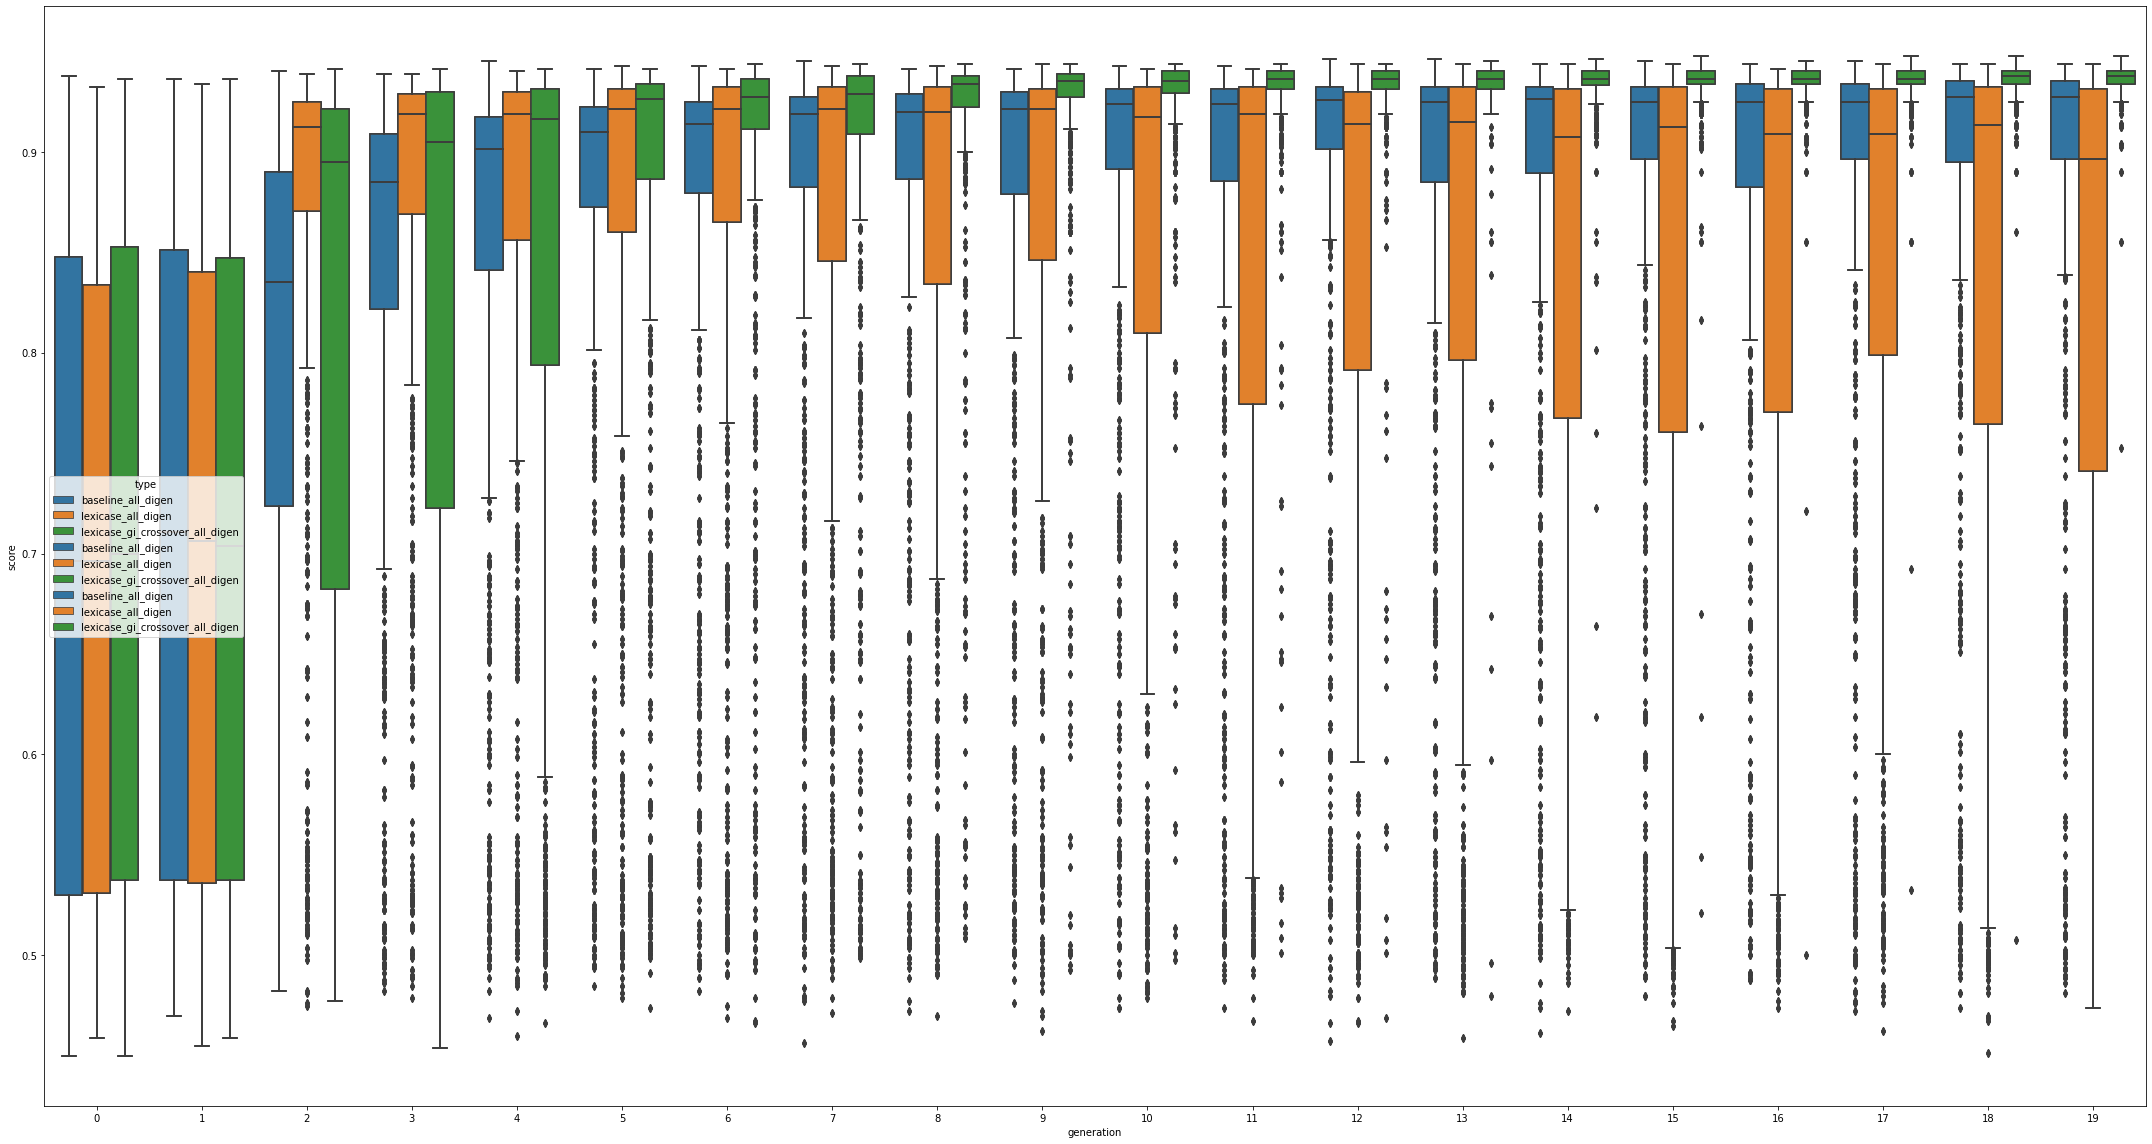

16


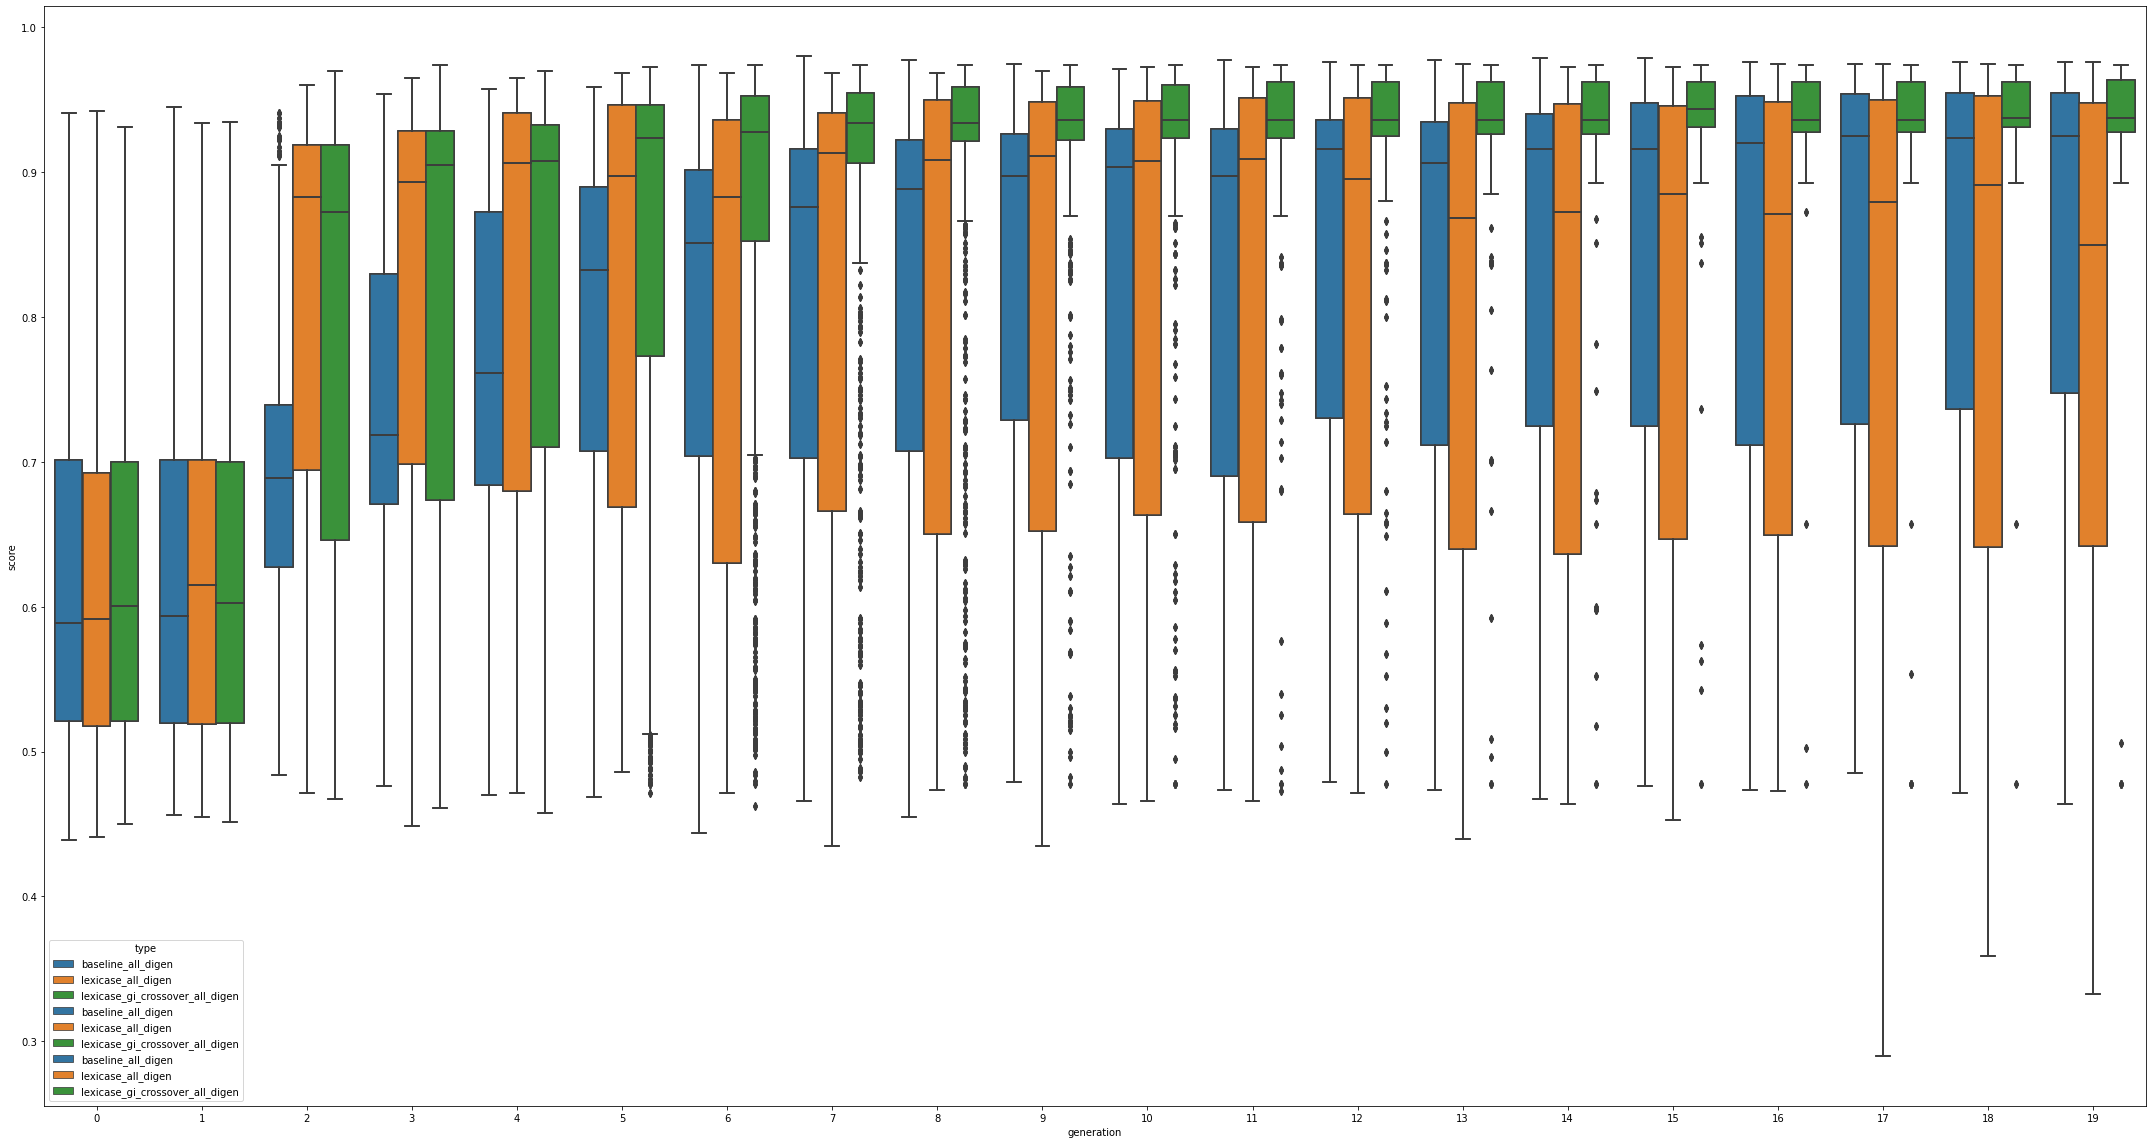

17


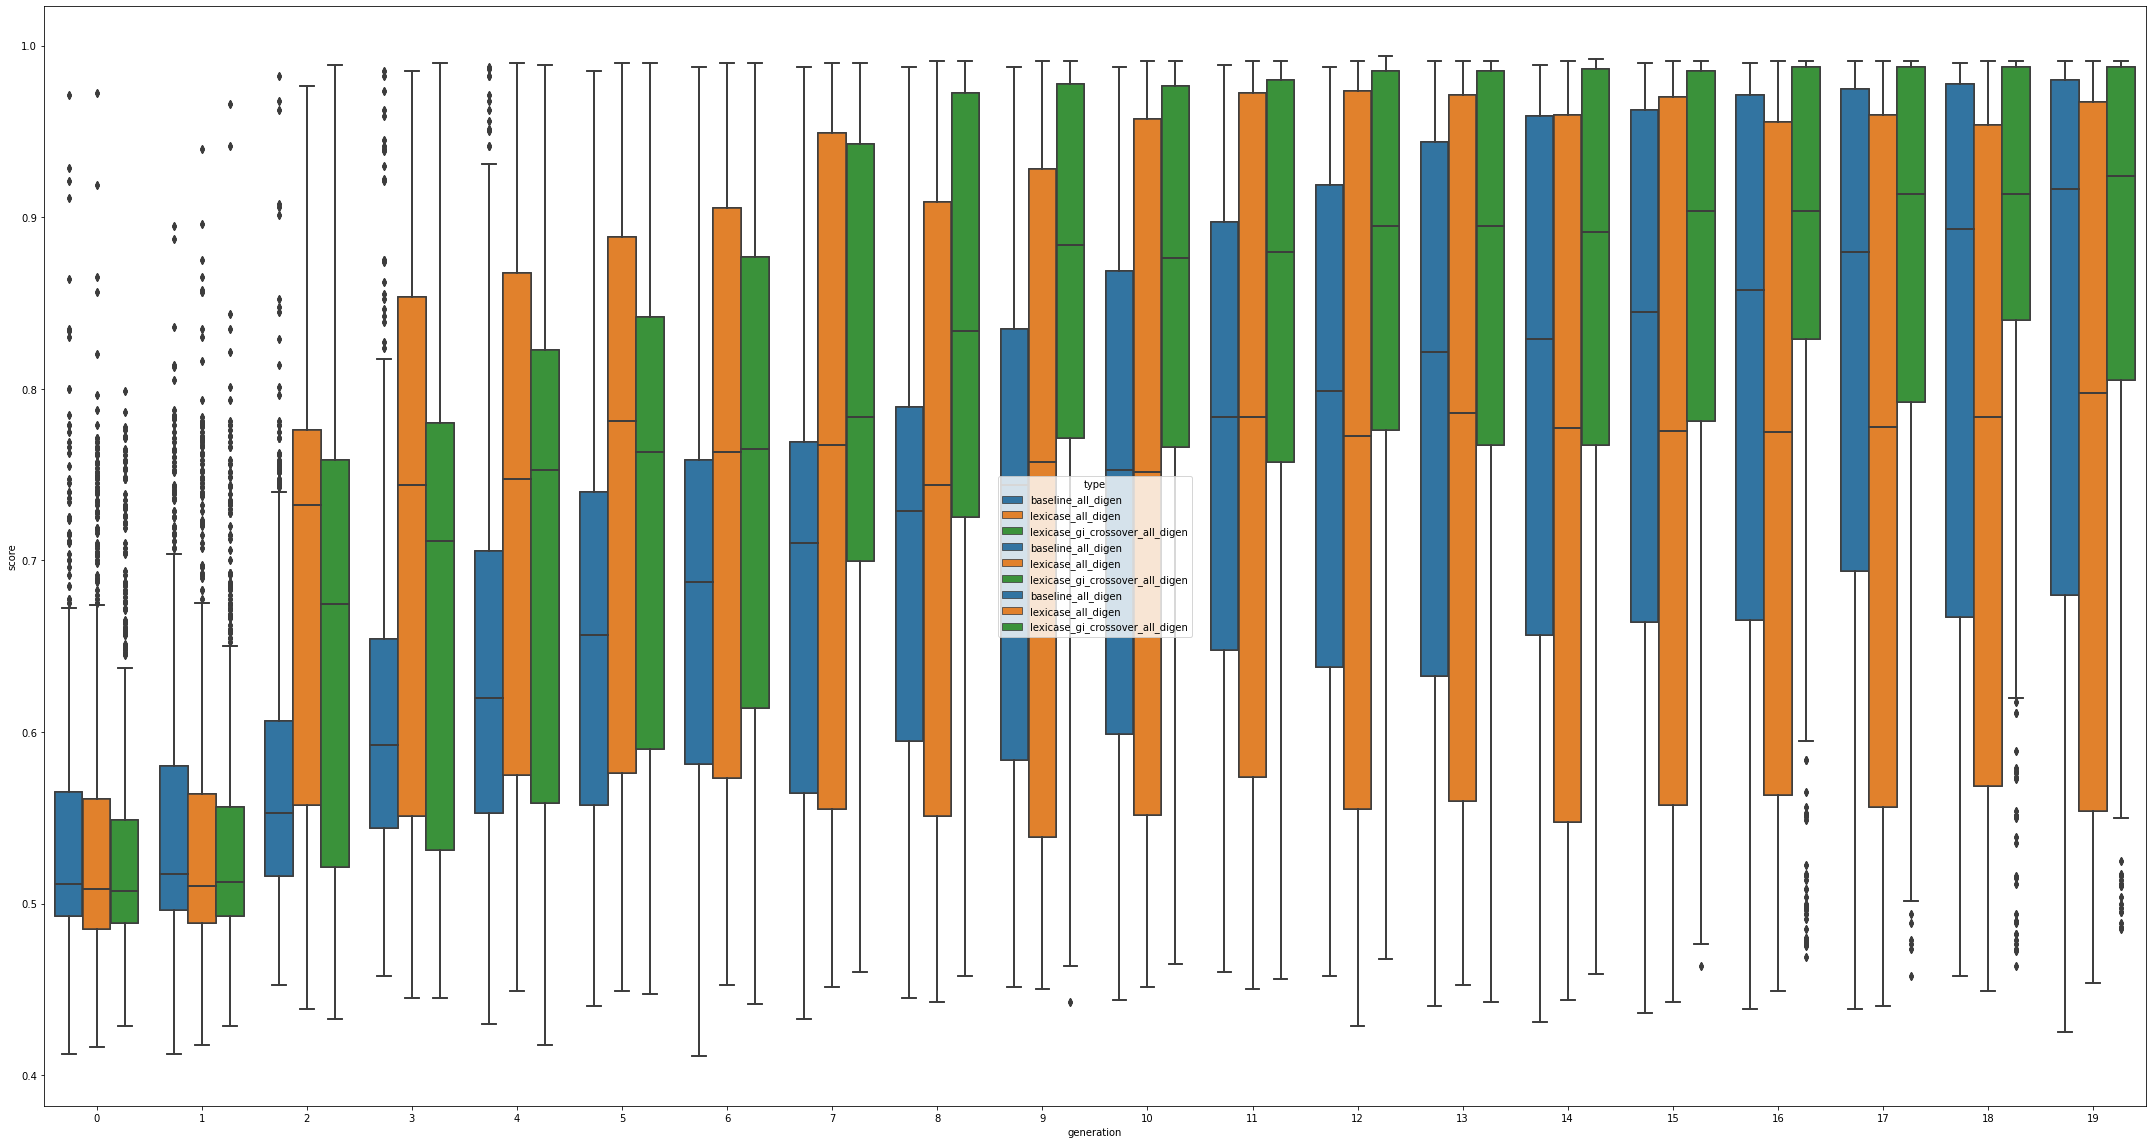

18


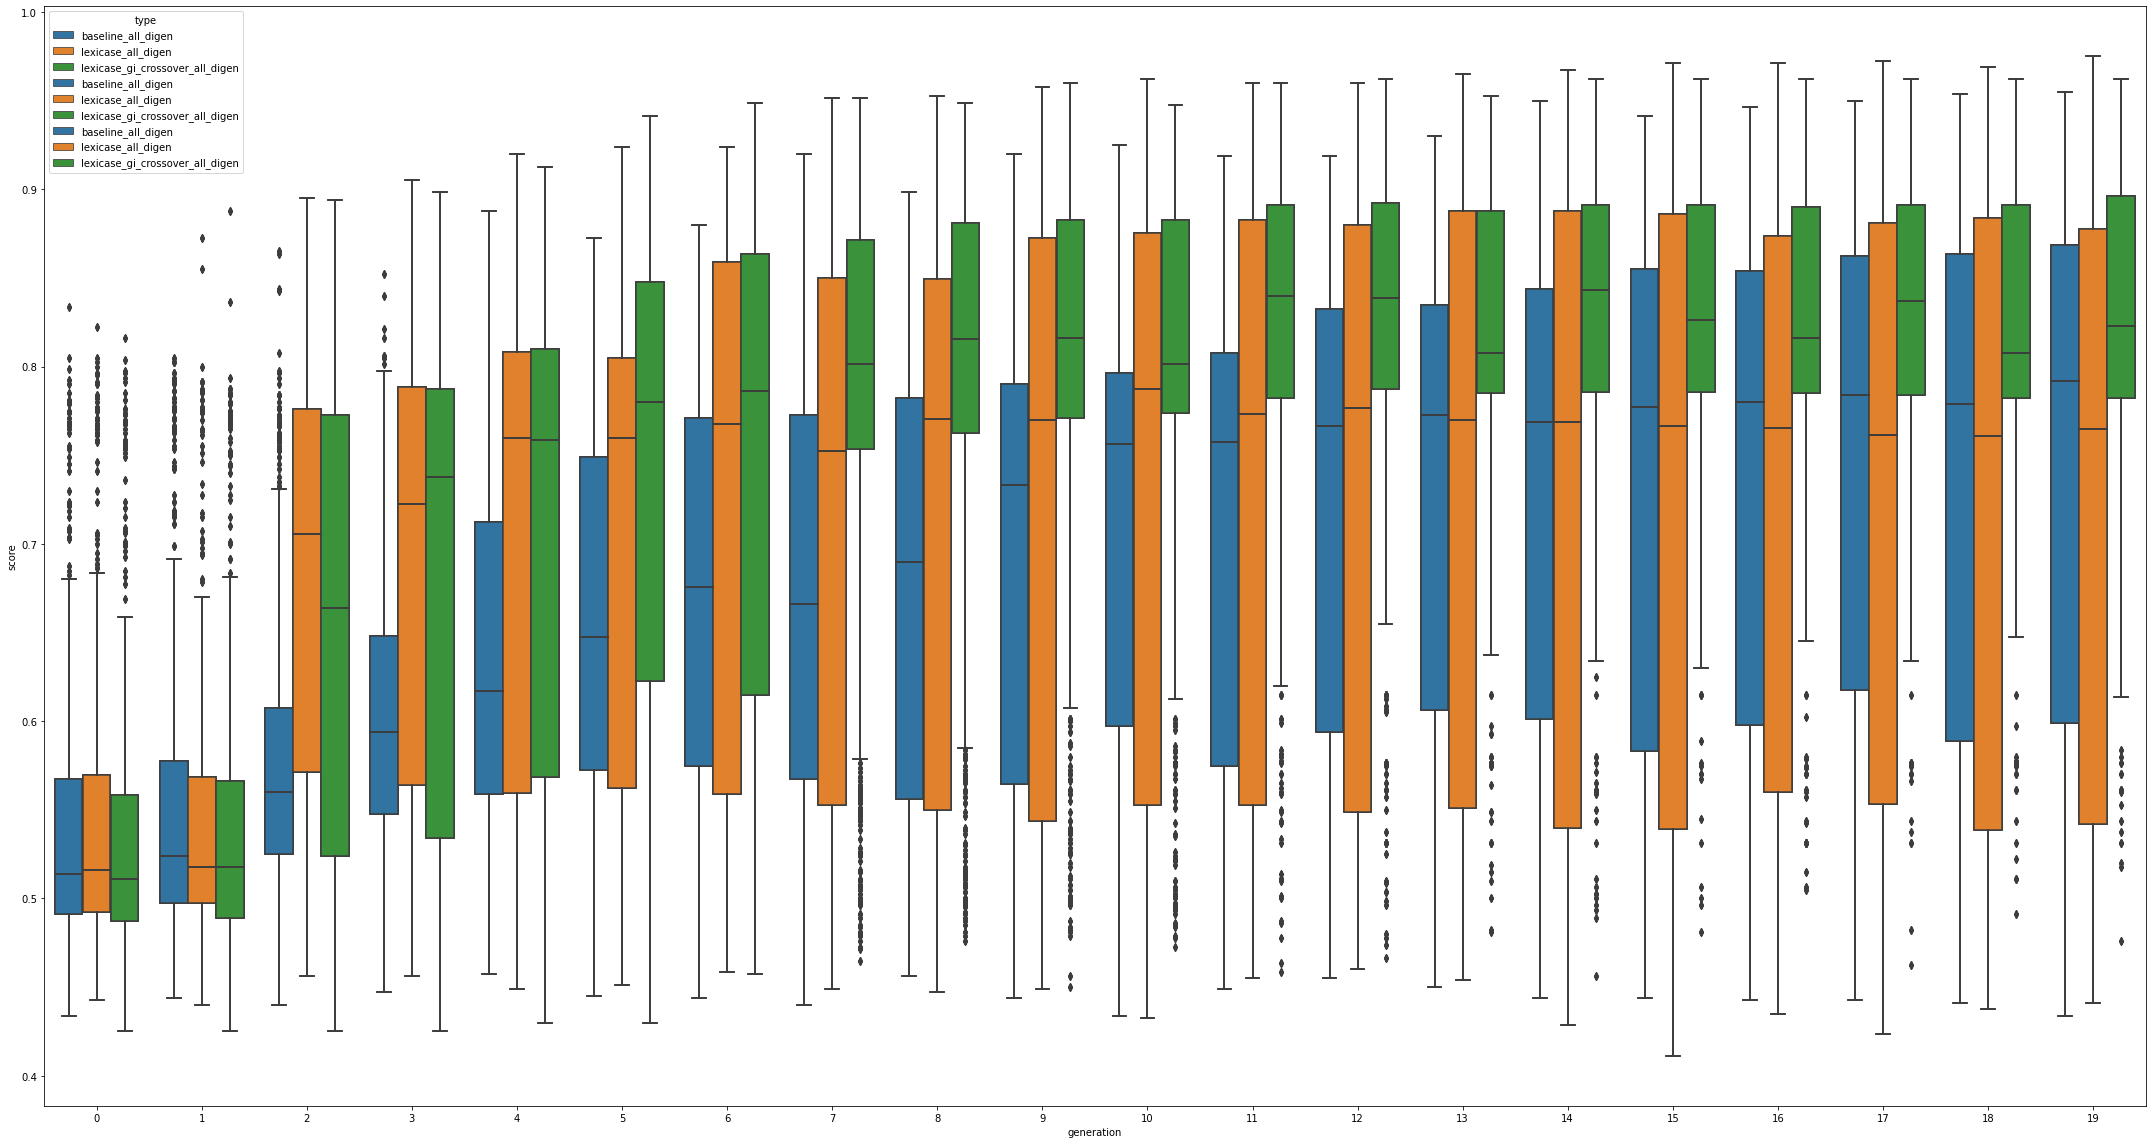

19


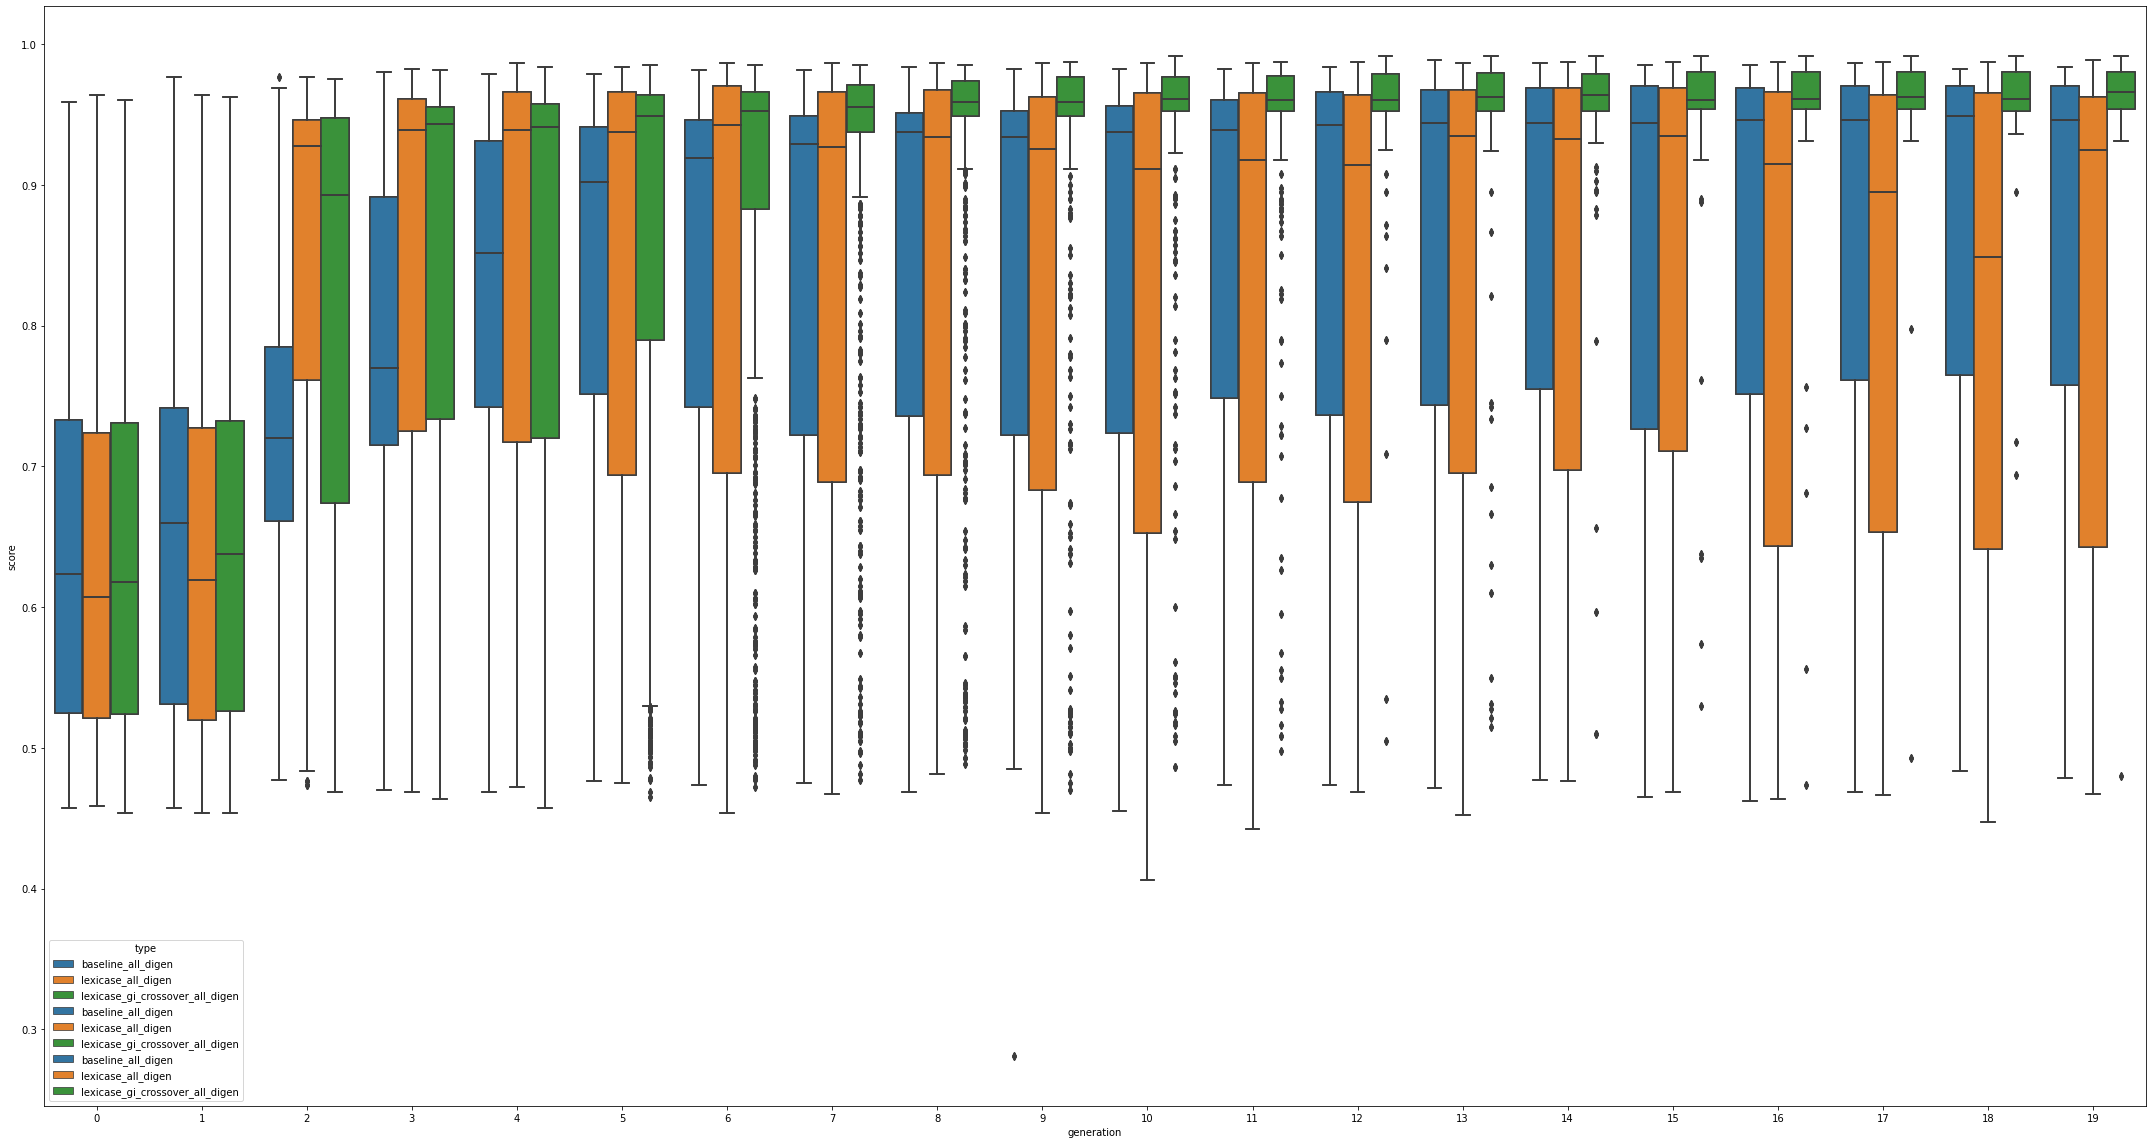

20


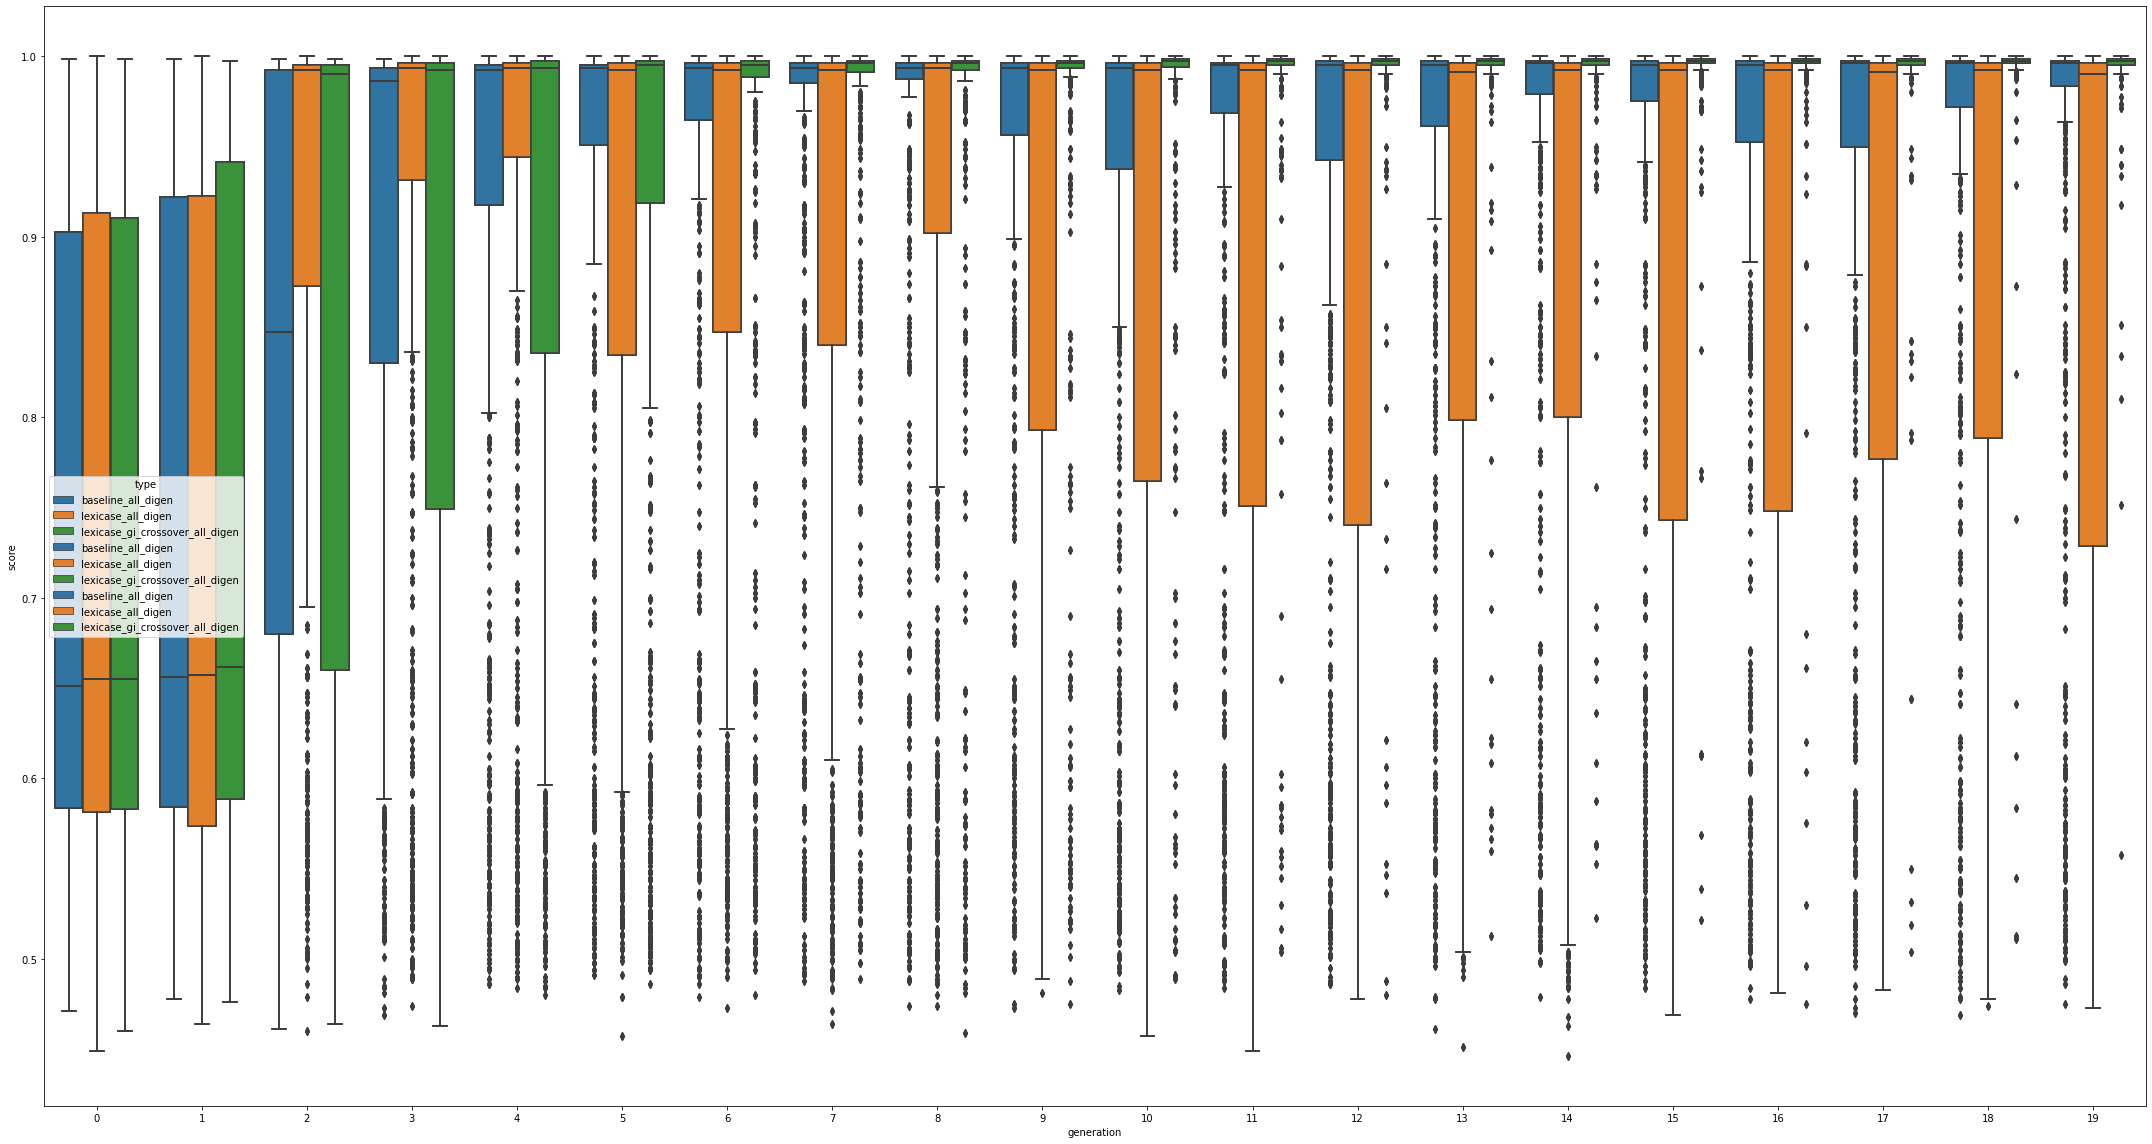

21


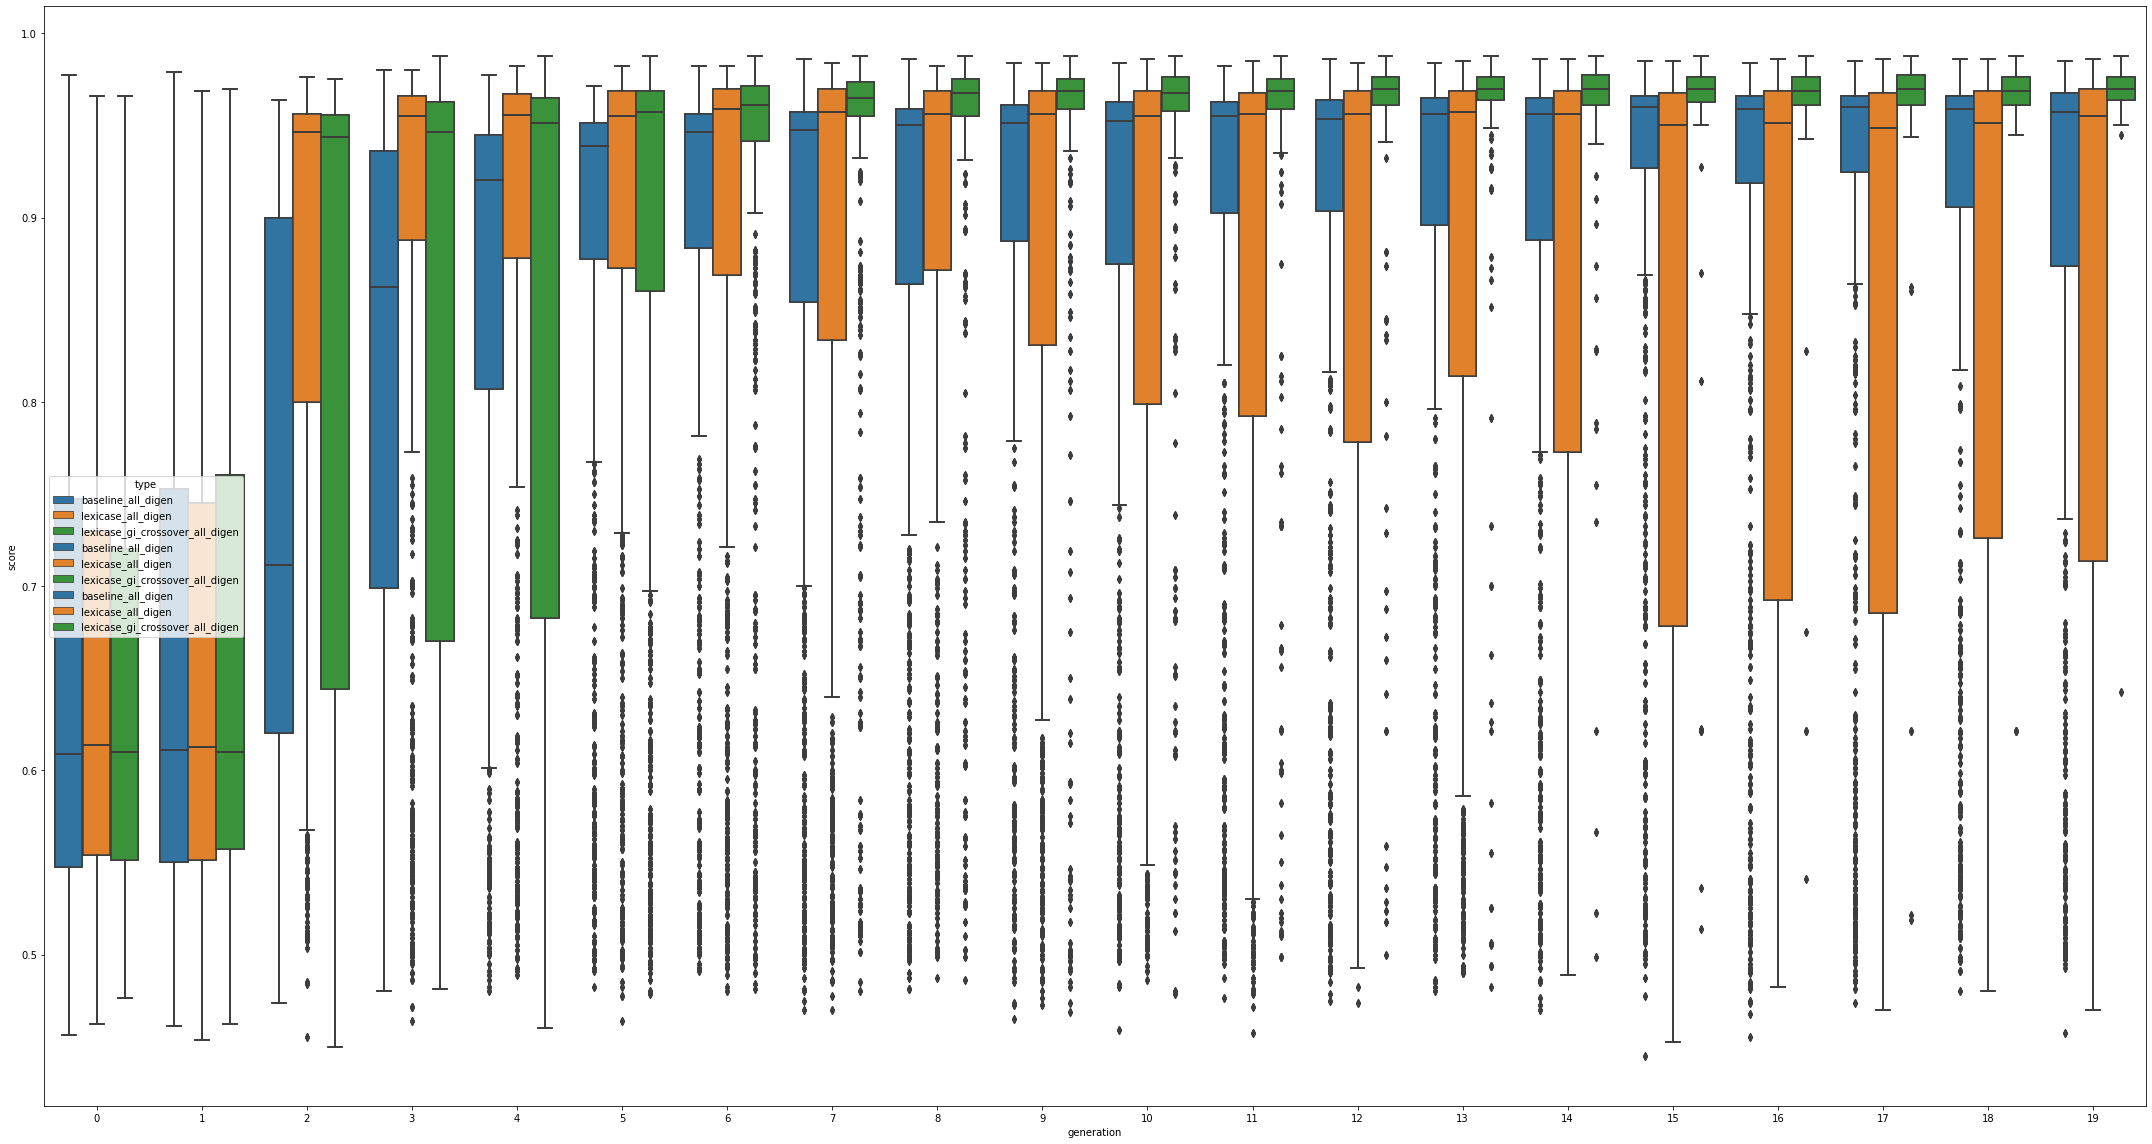

22


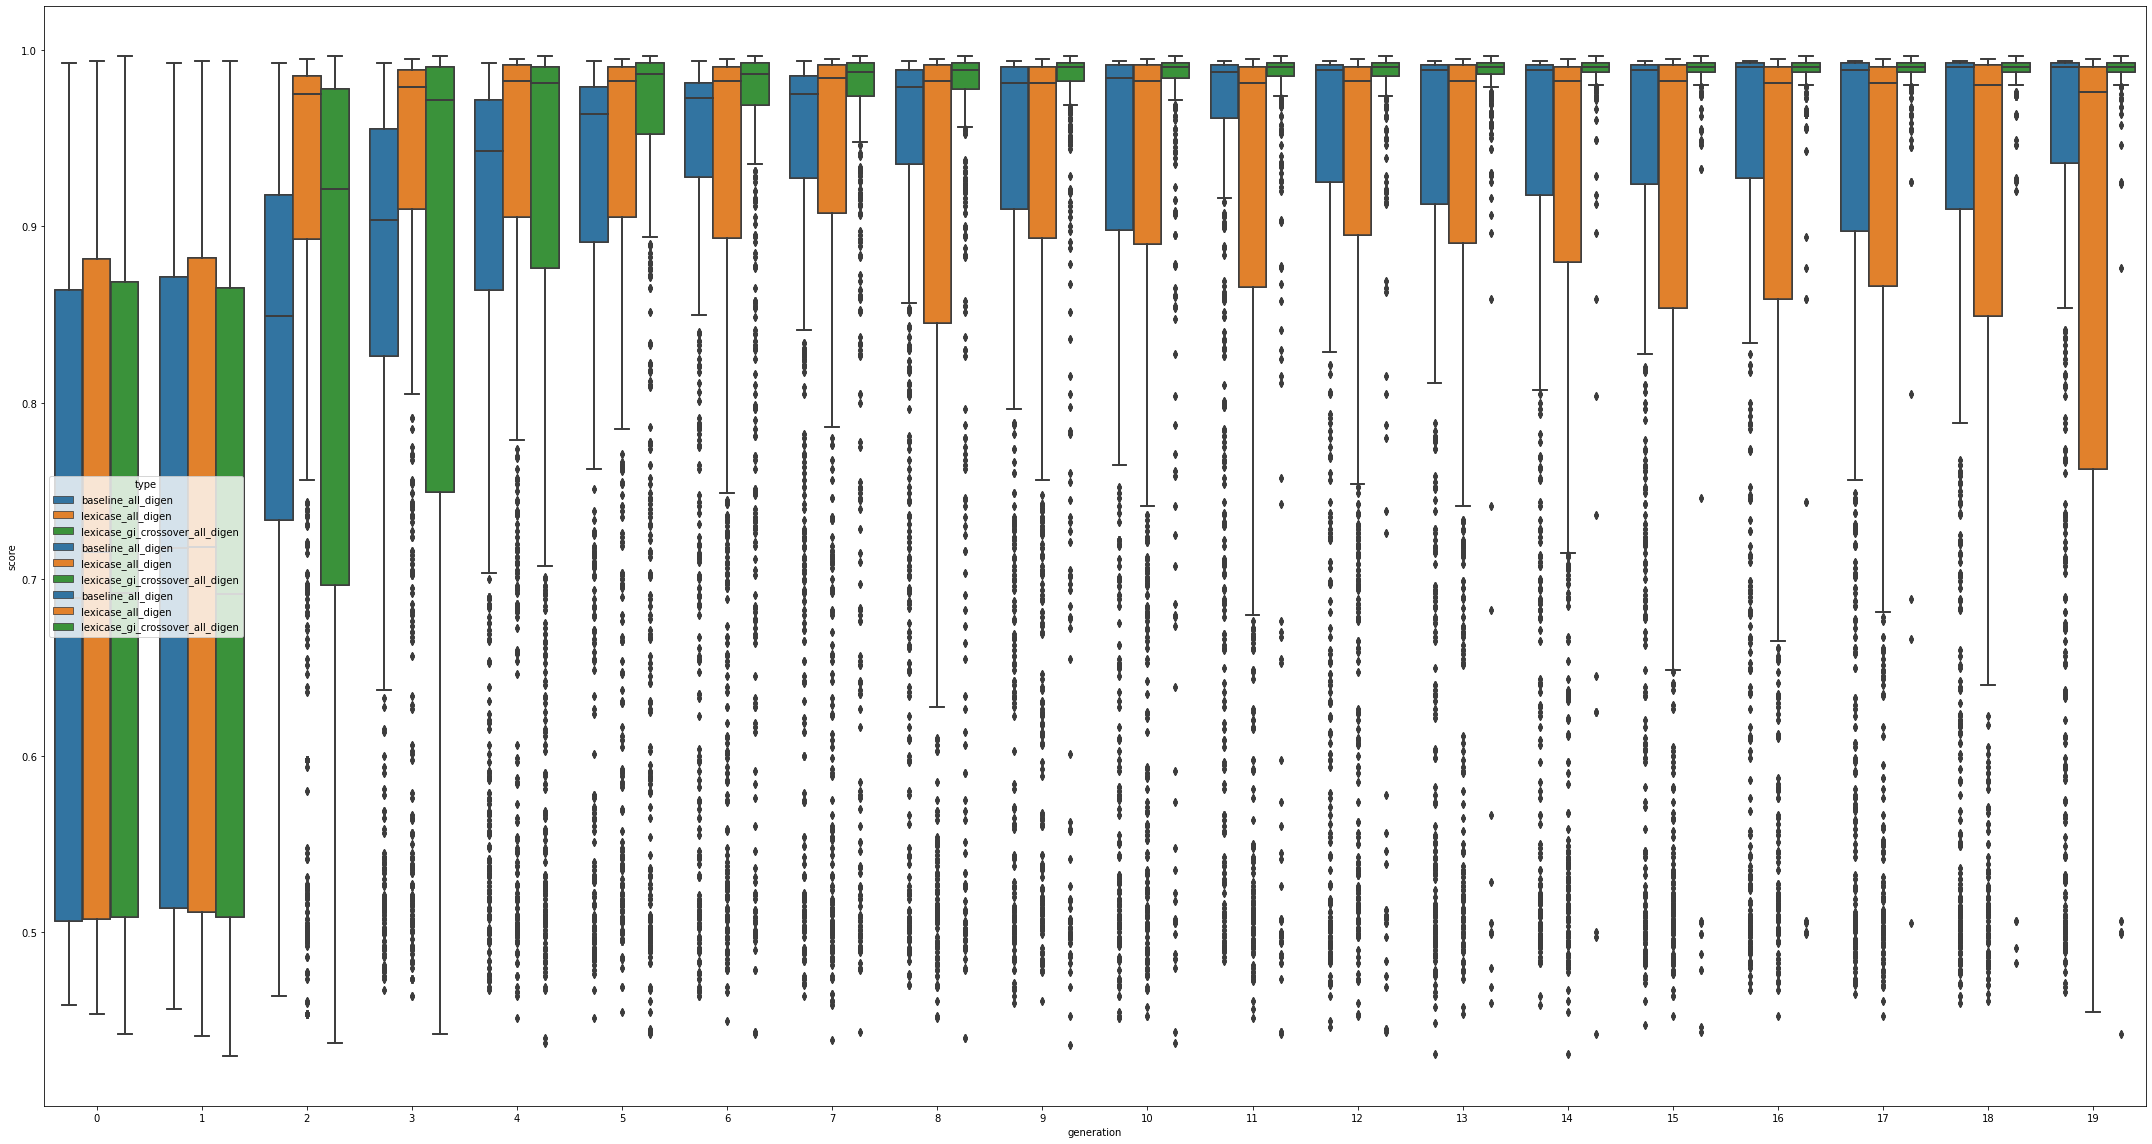

23


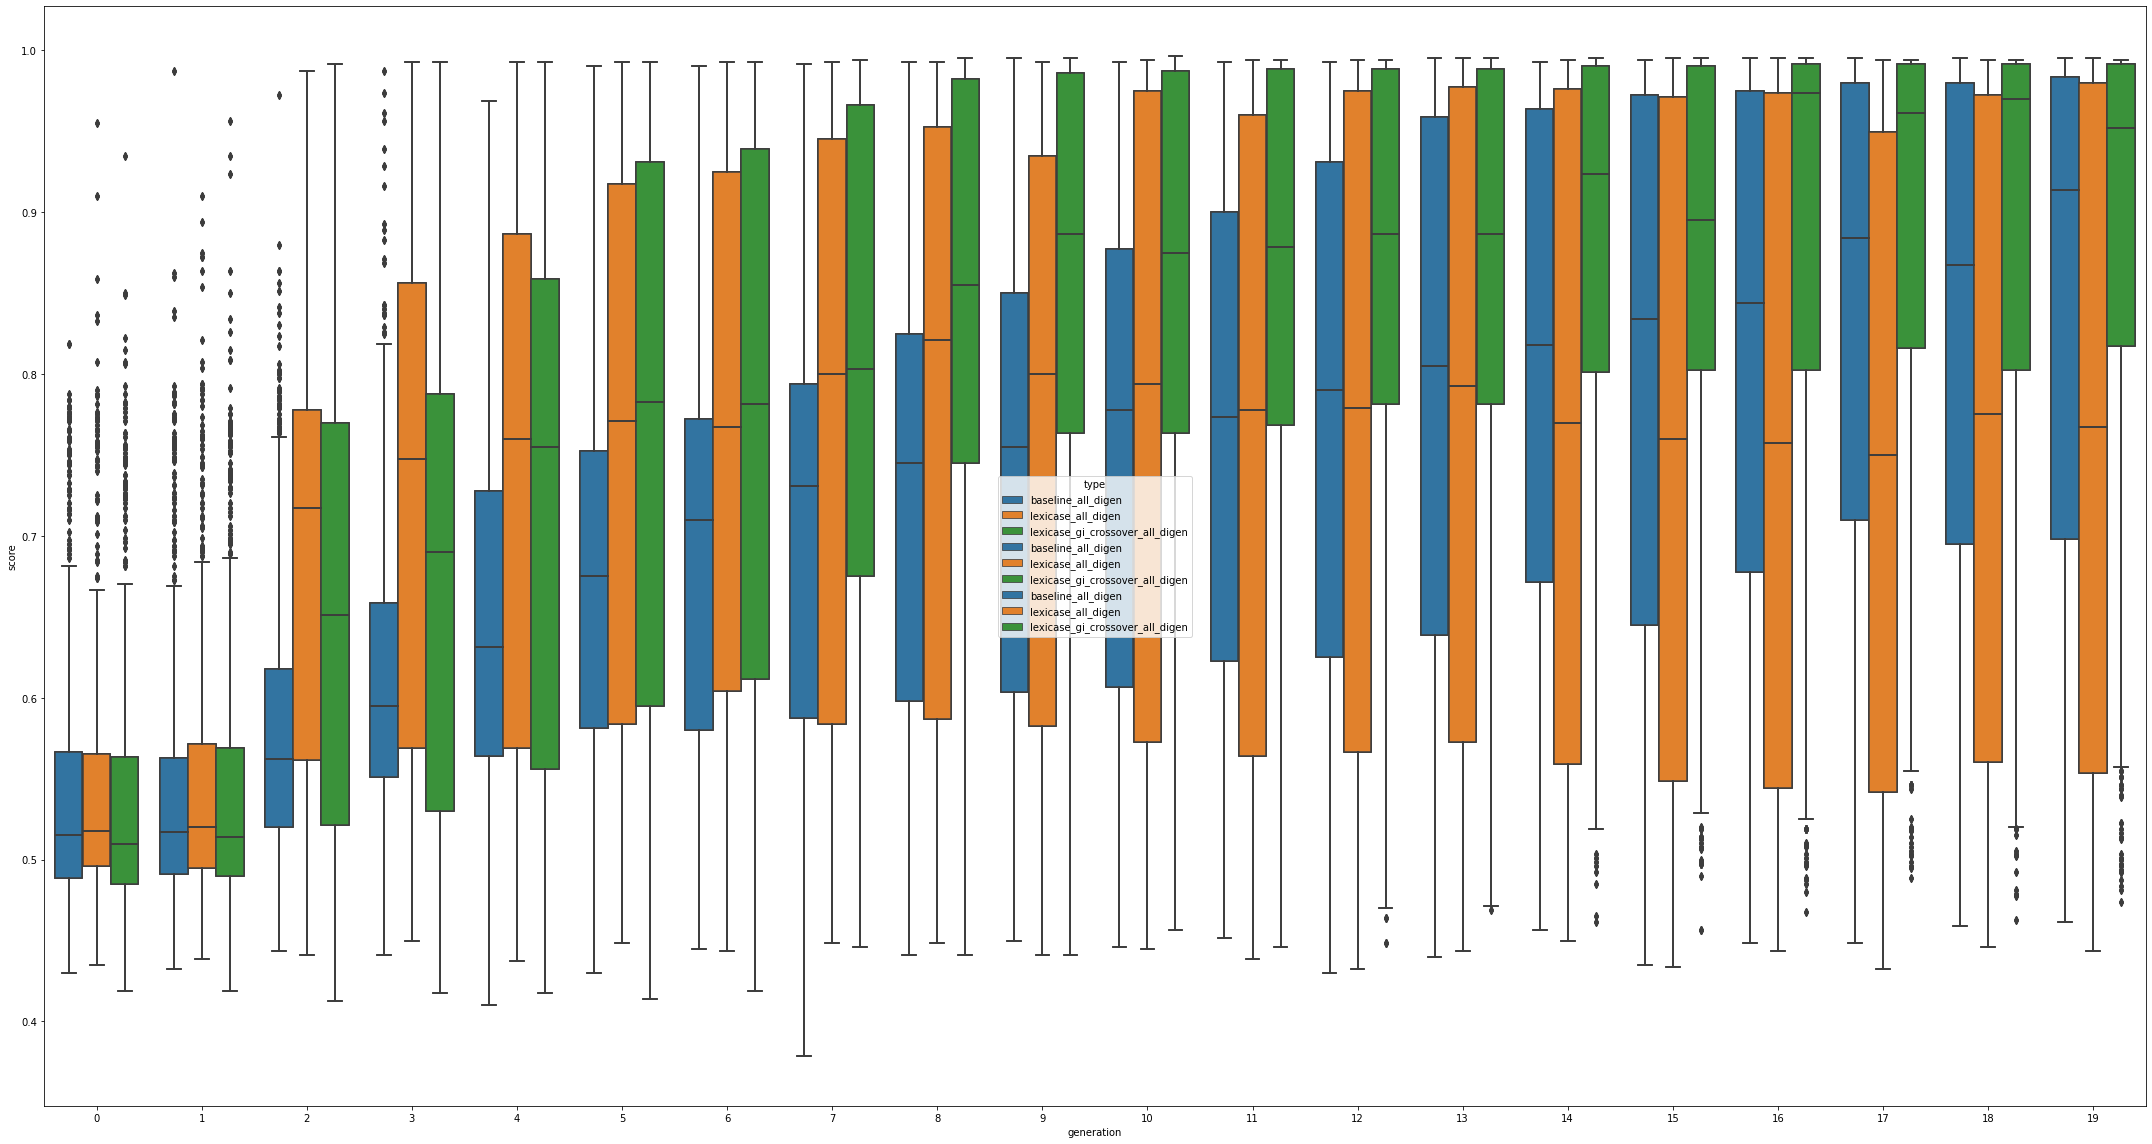

24


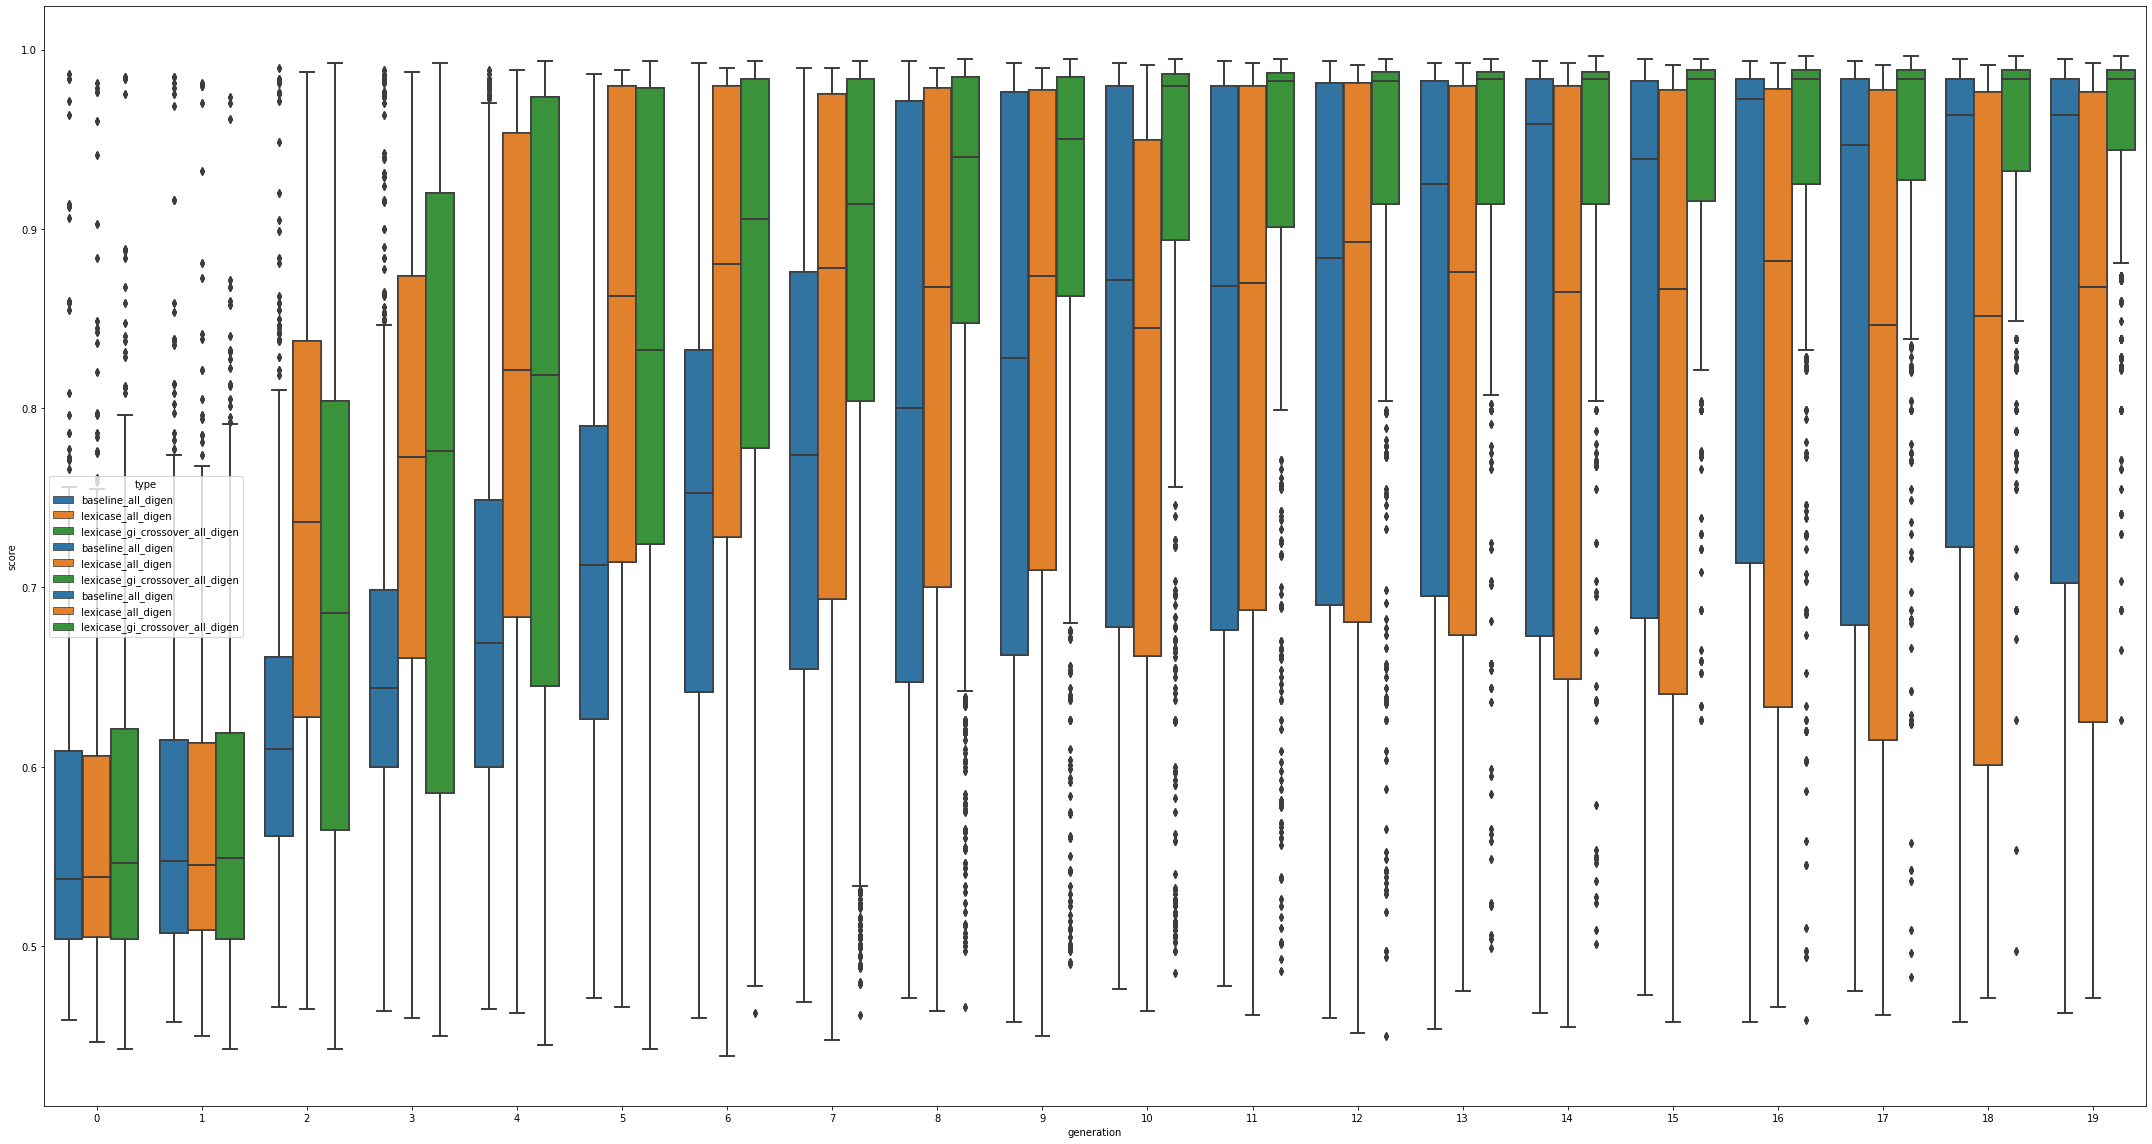

25


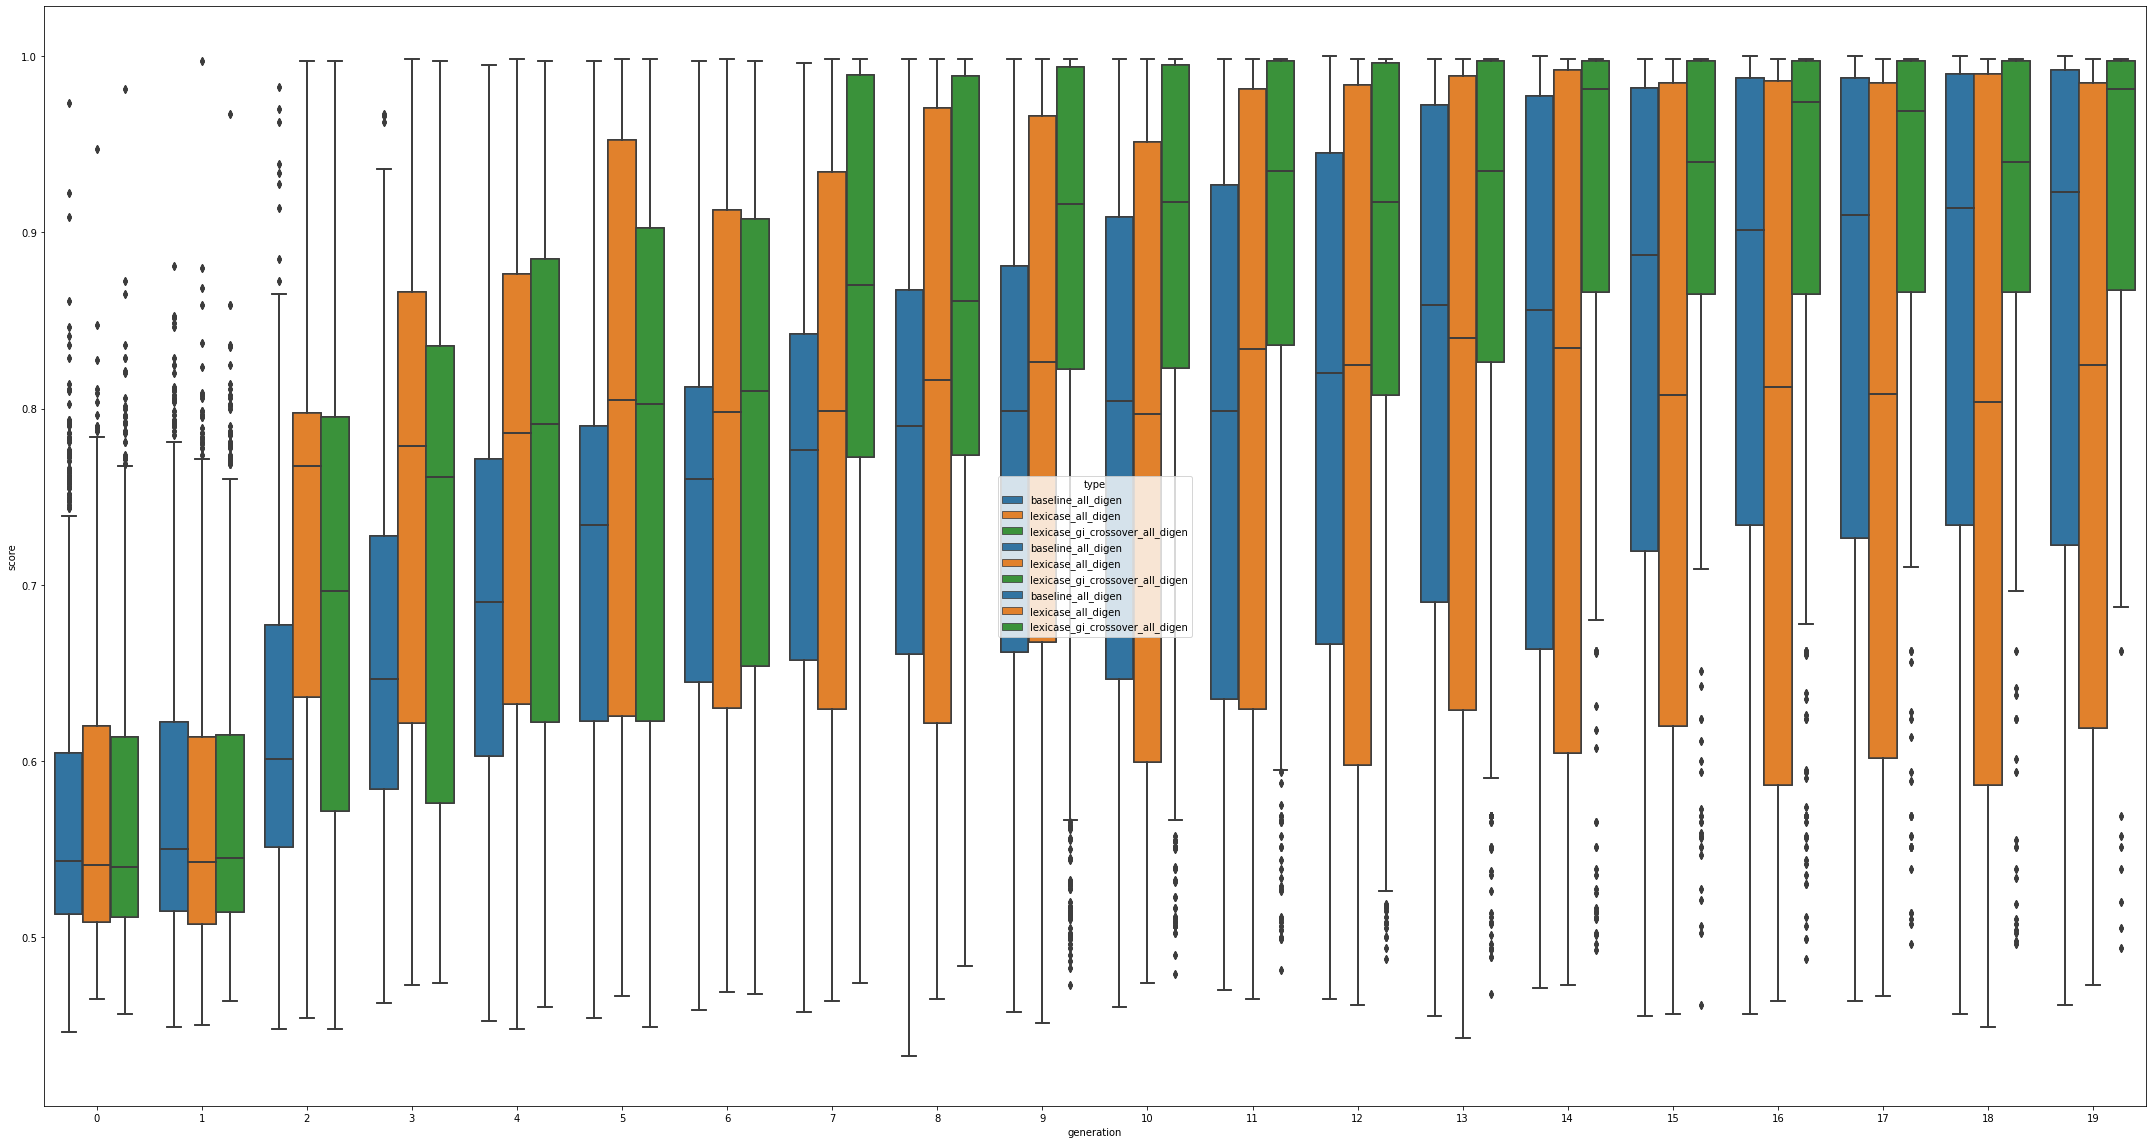

26


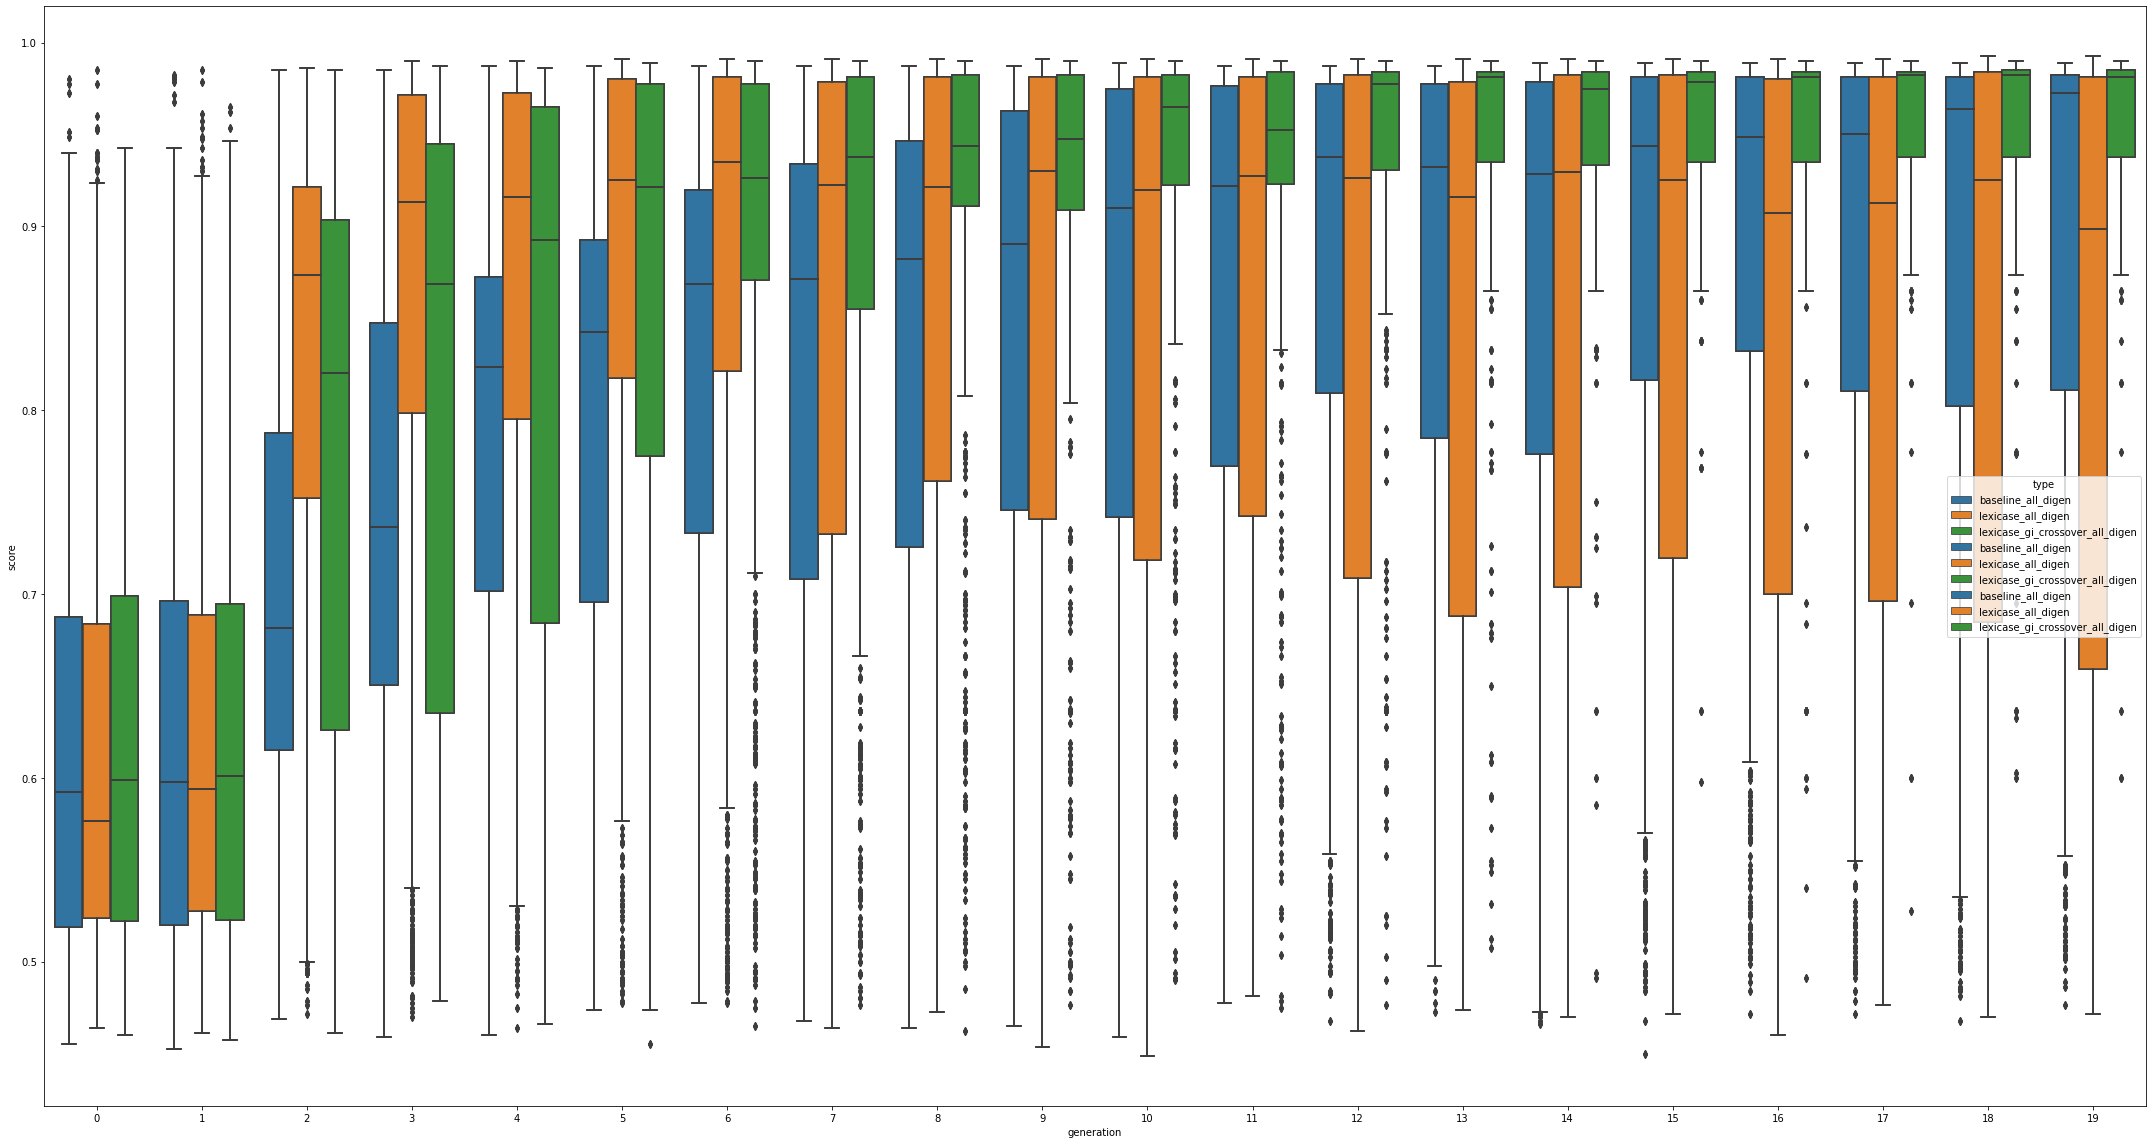

27


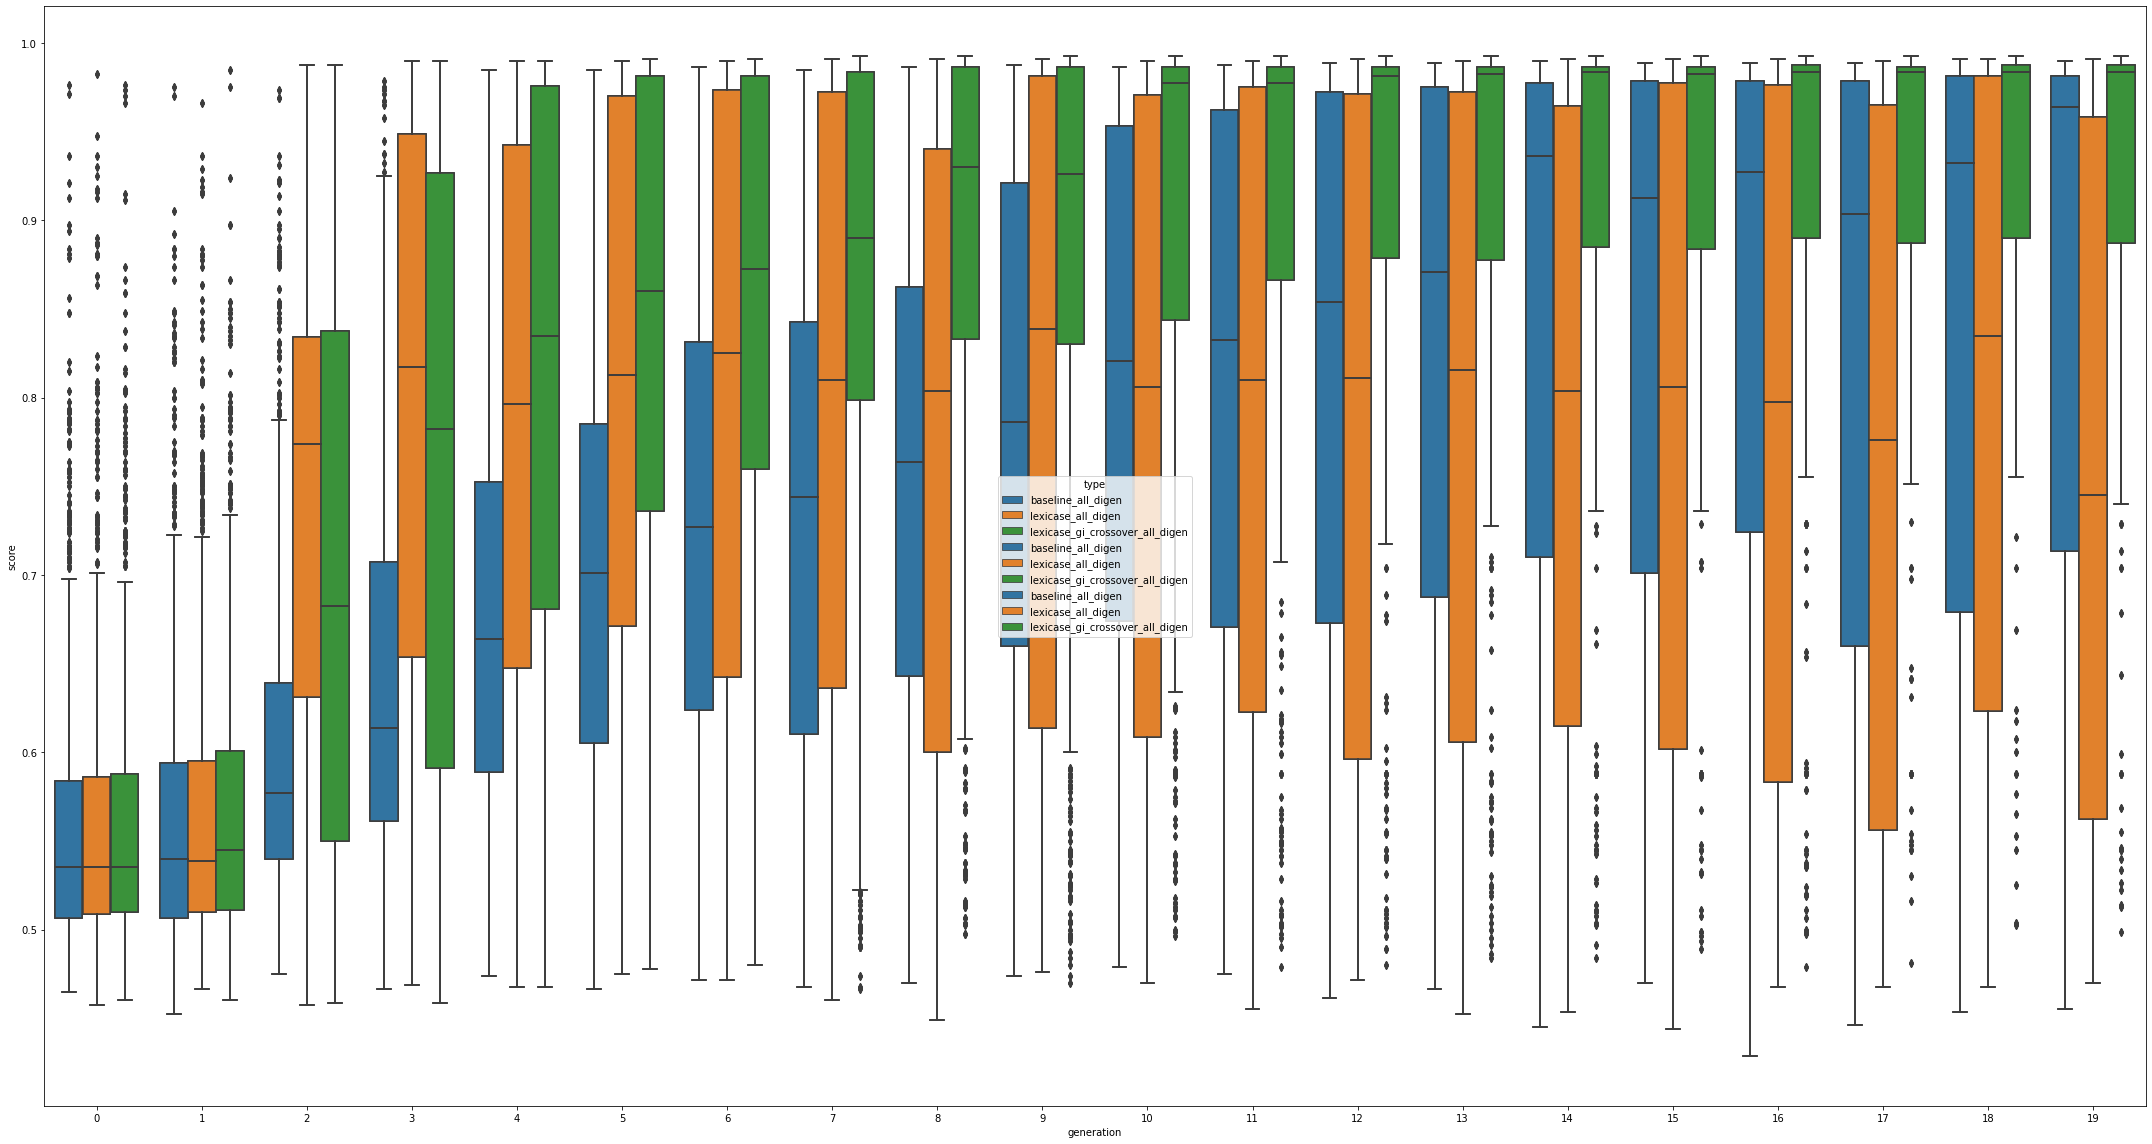

28


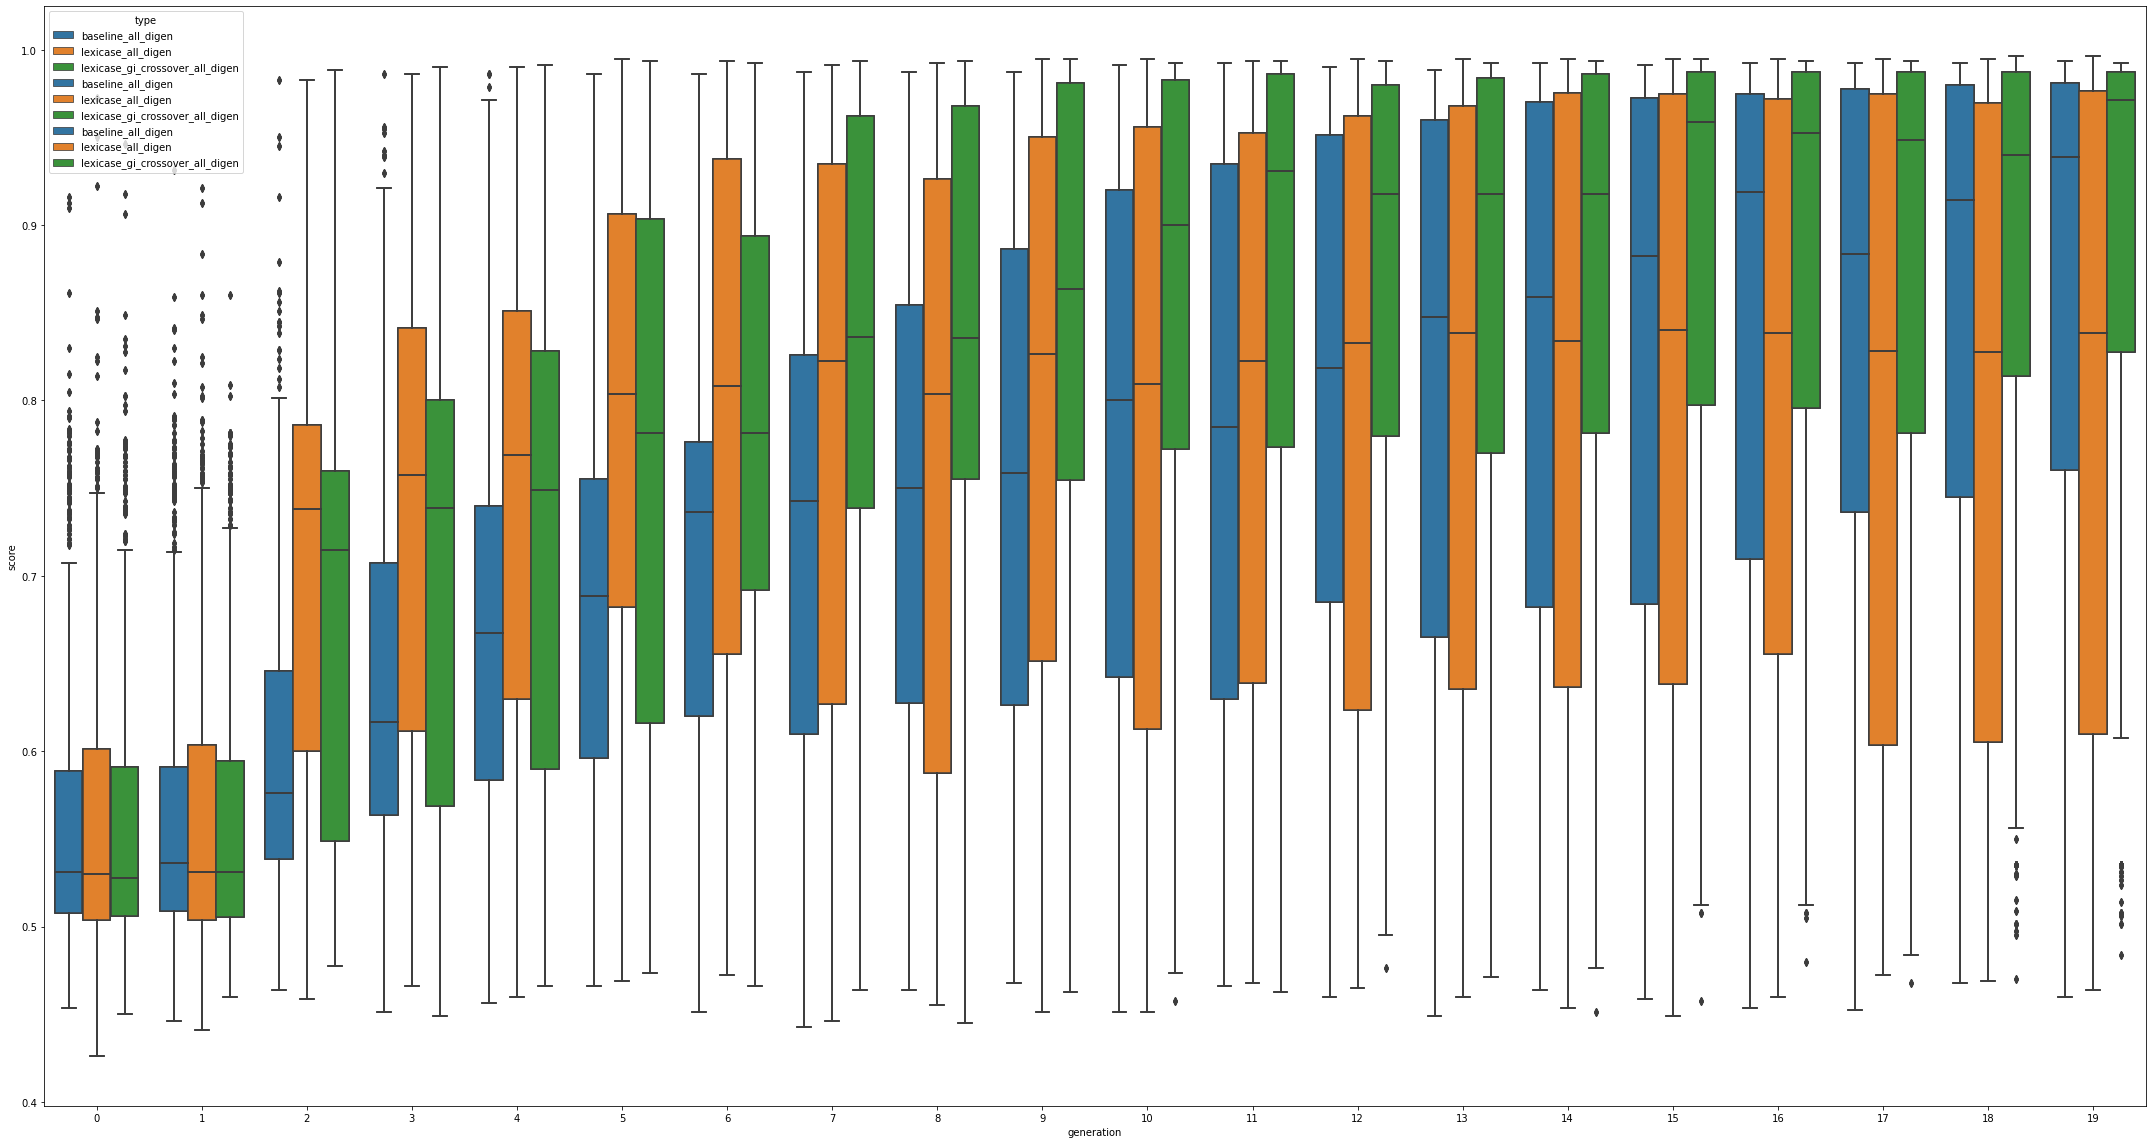

29


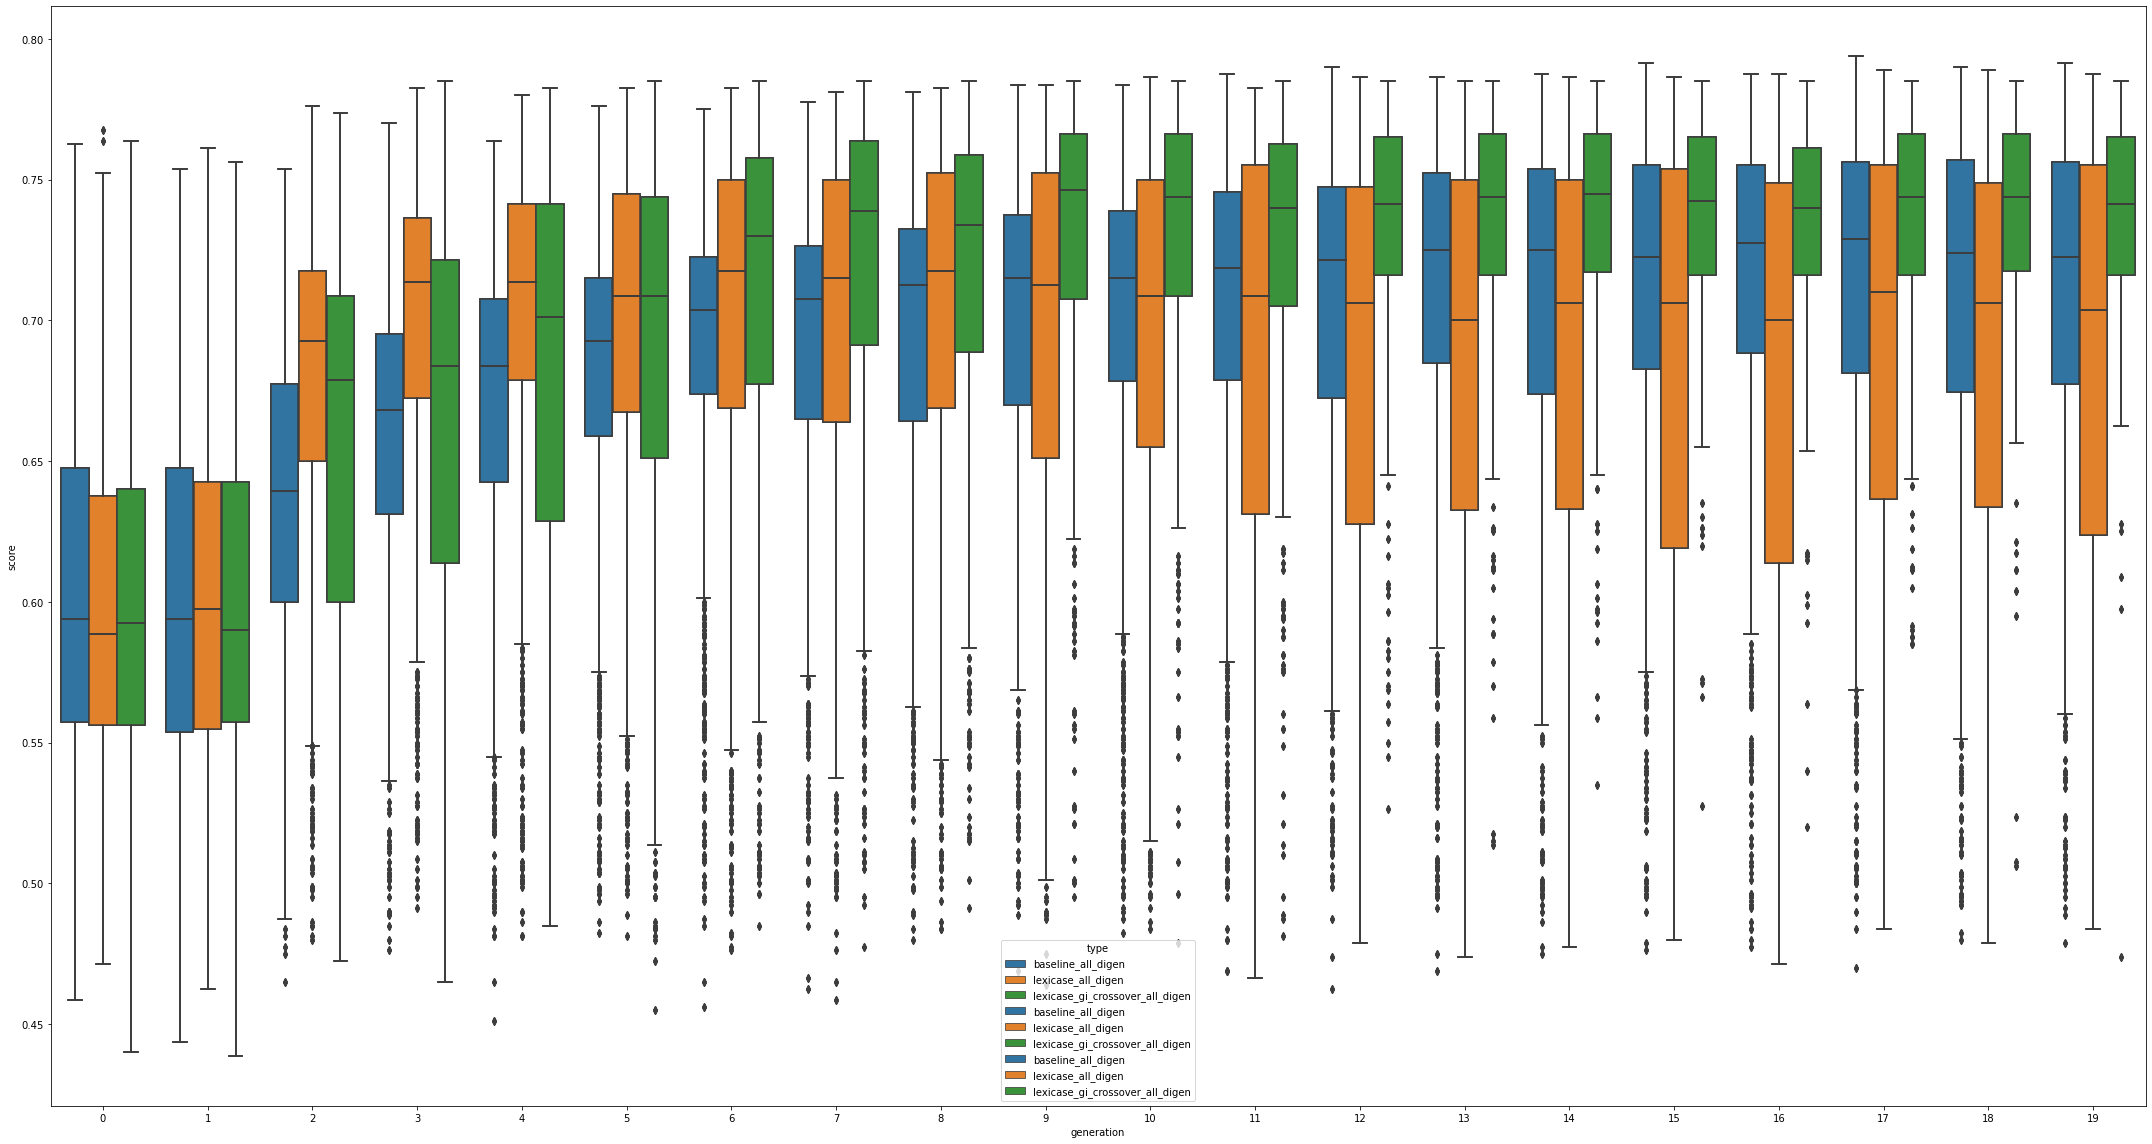

30


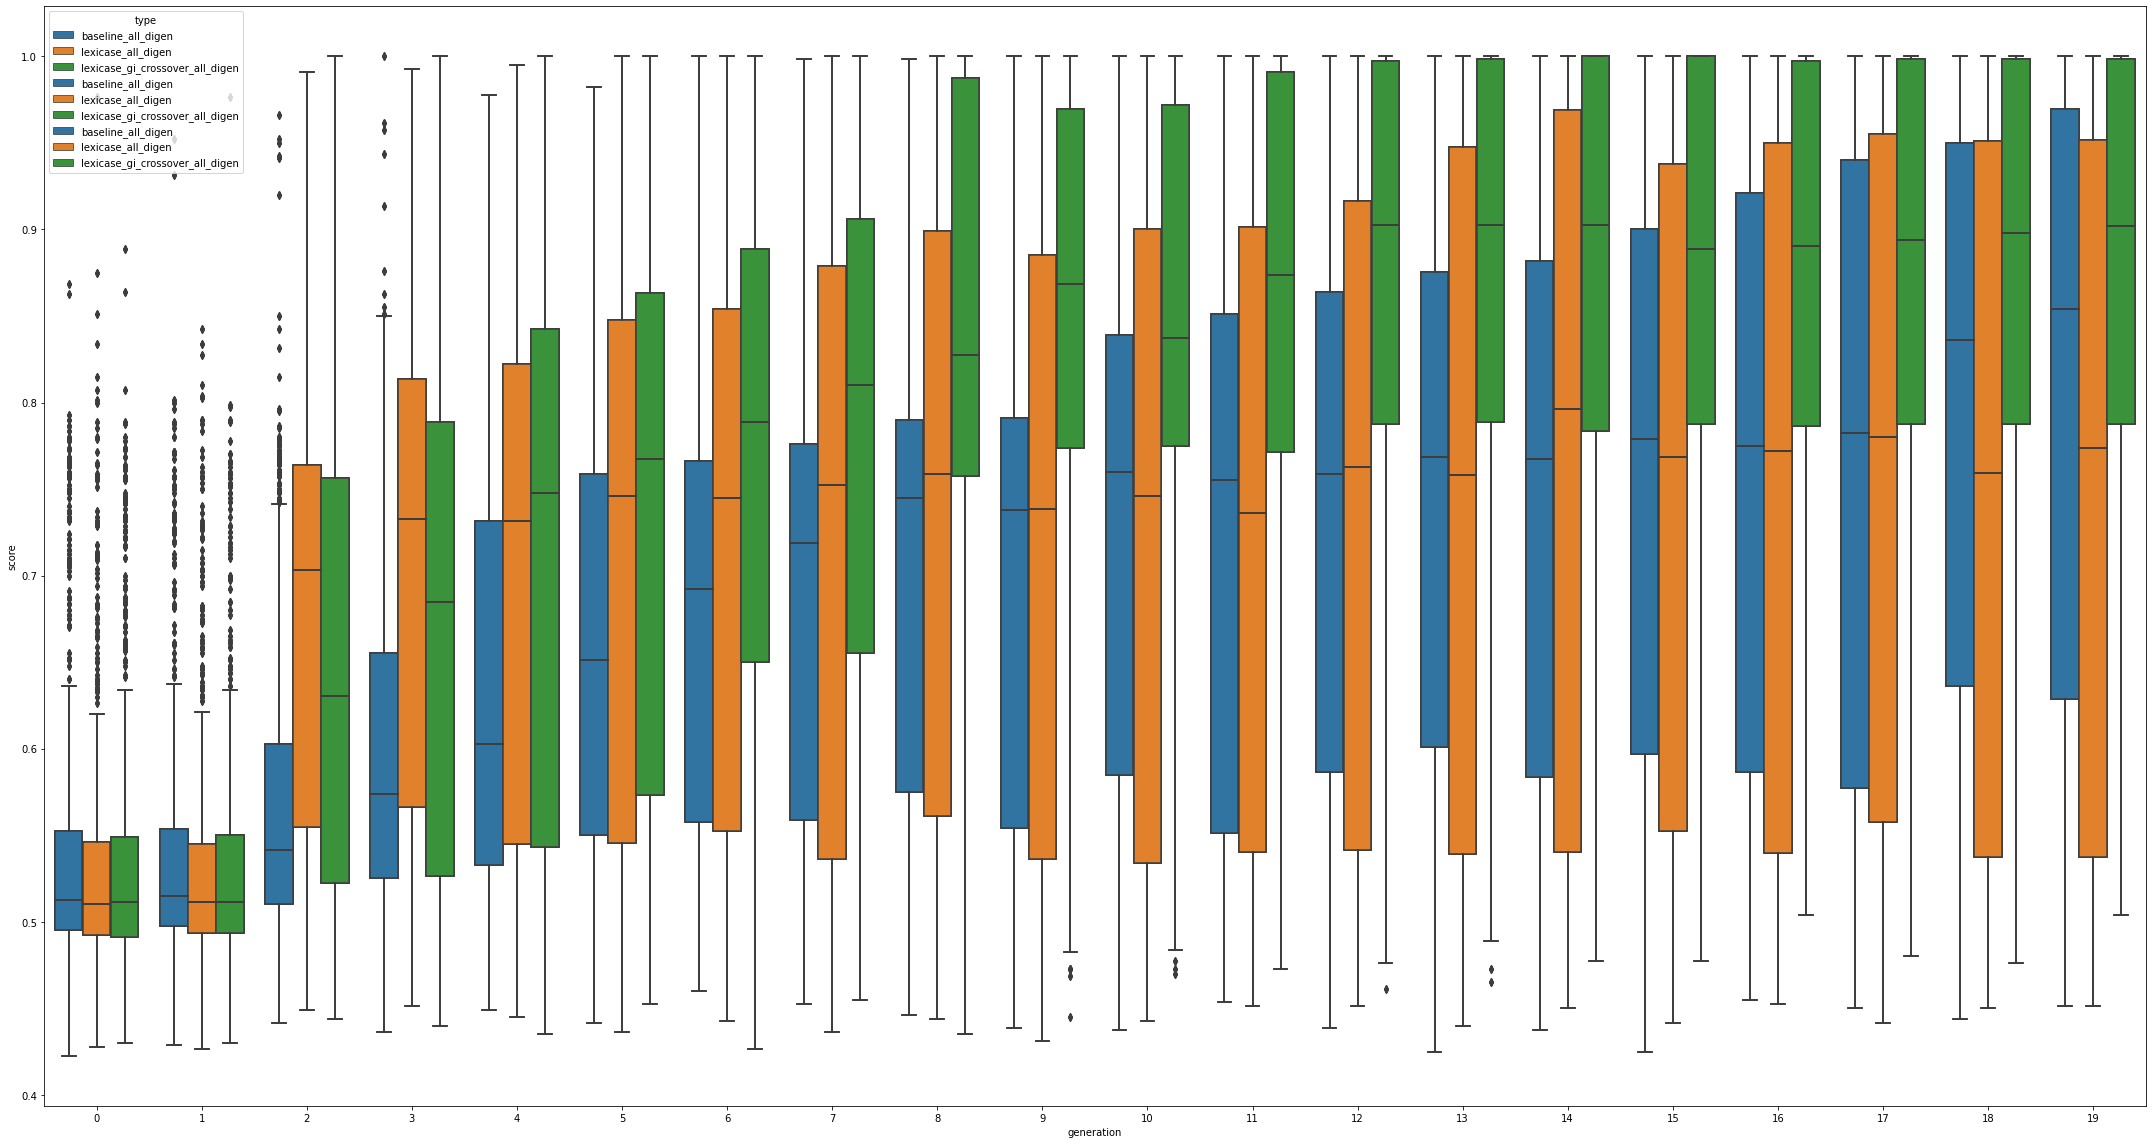

31


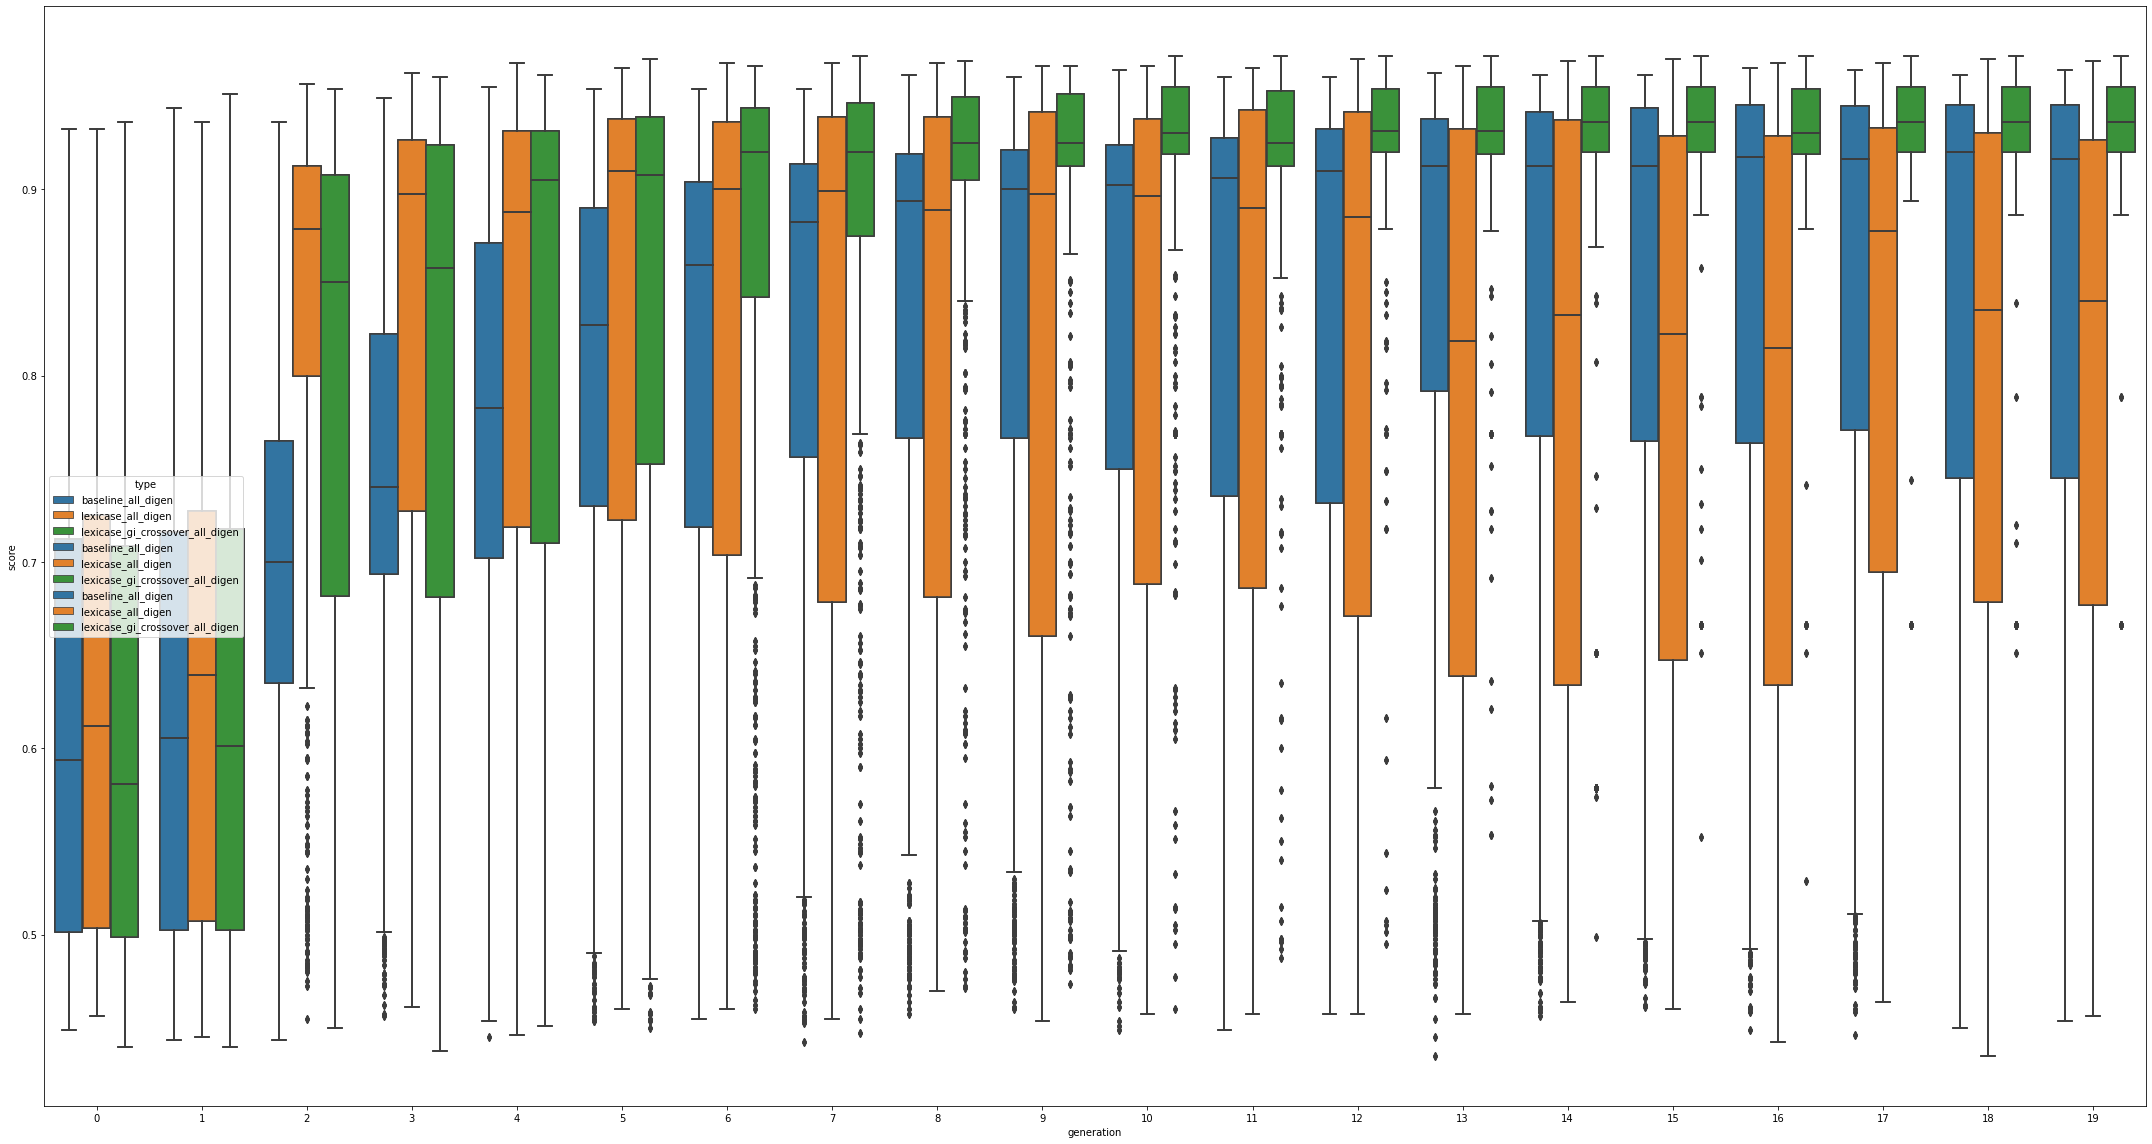

32


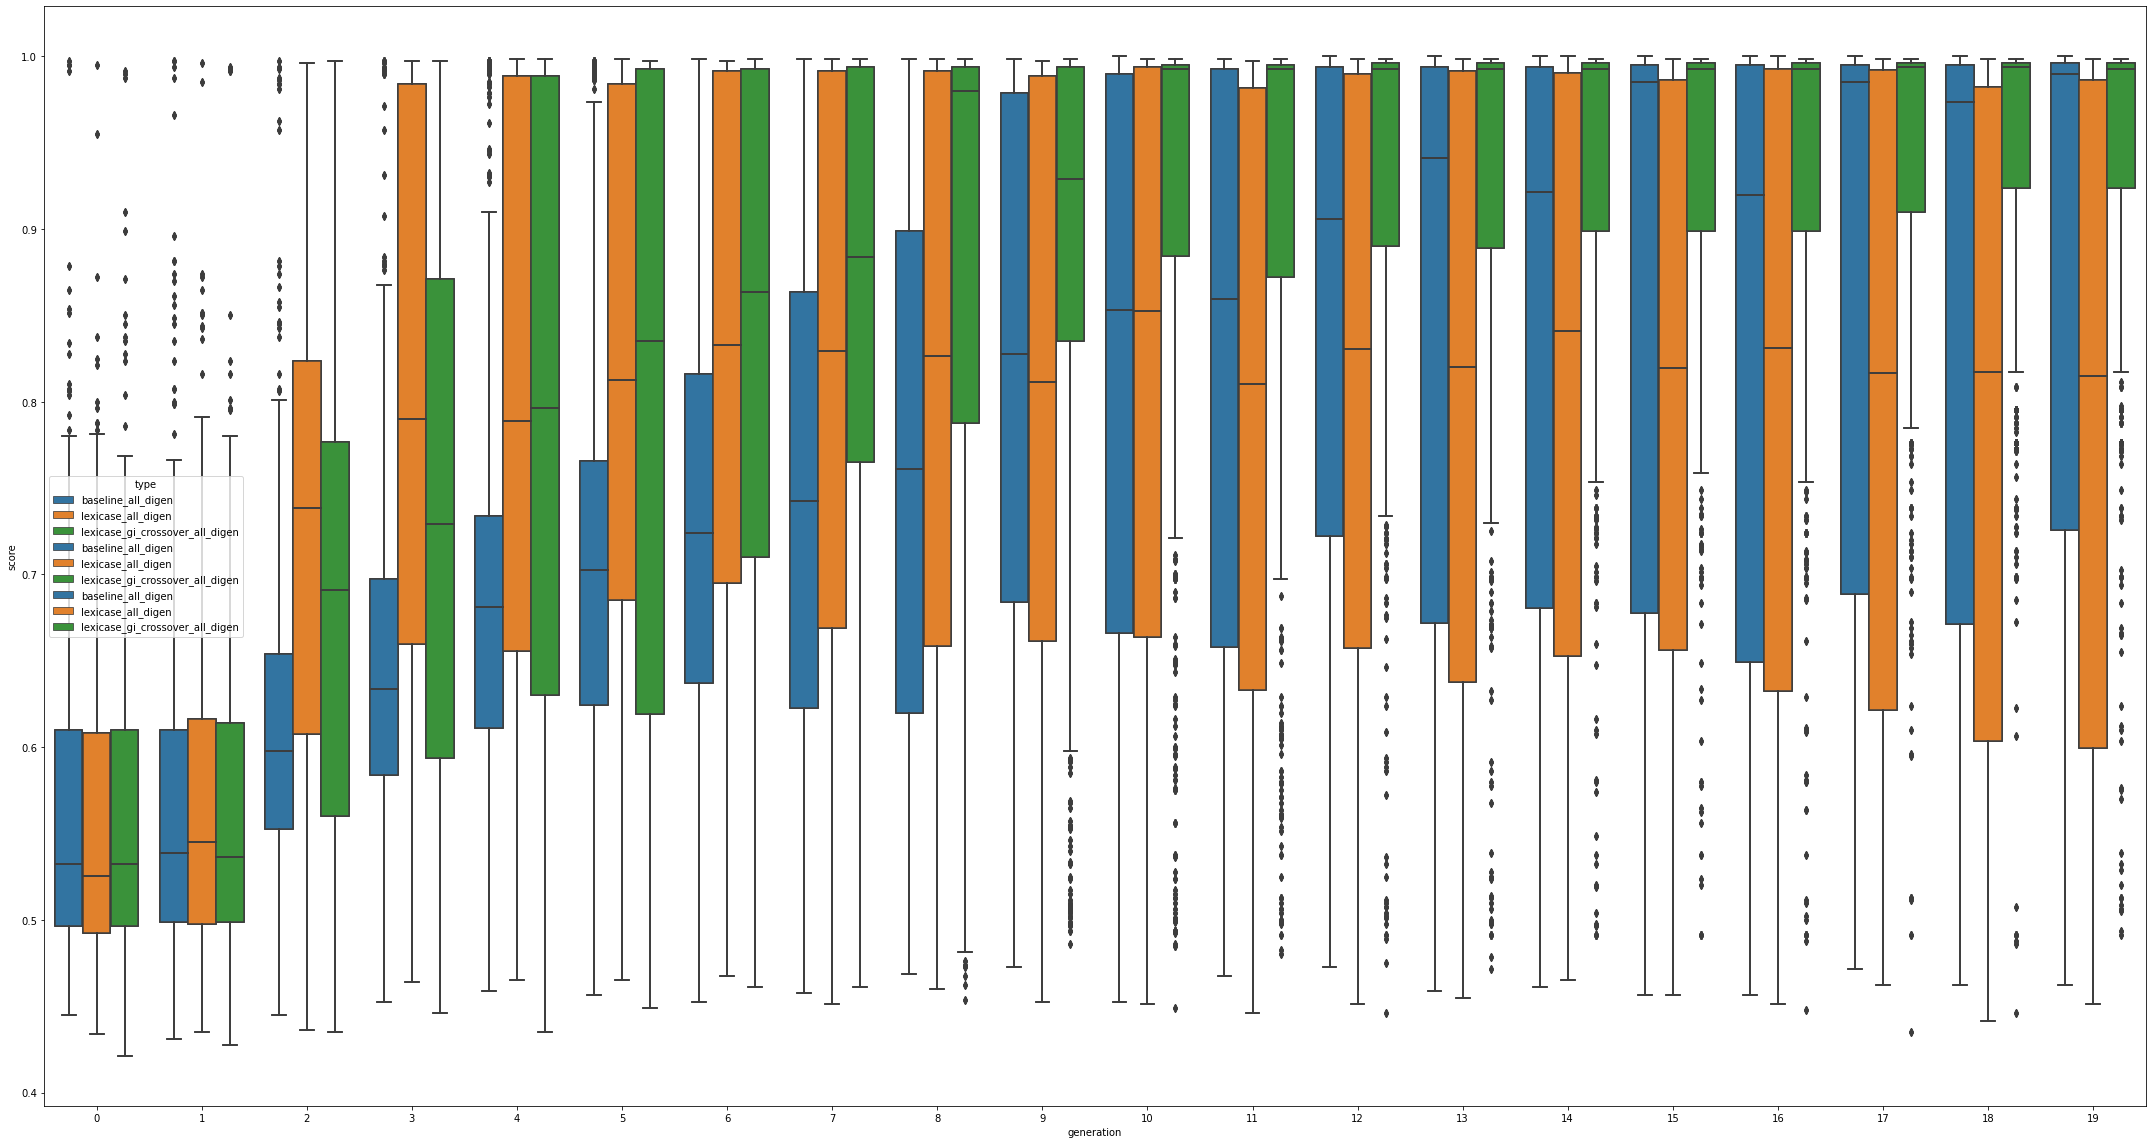

33


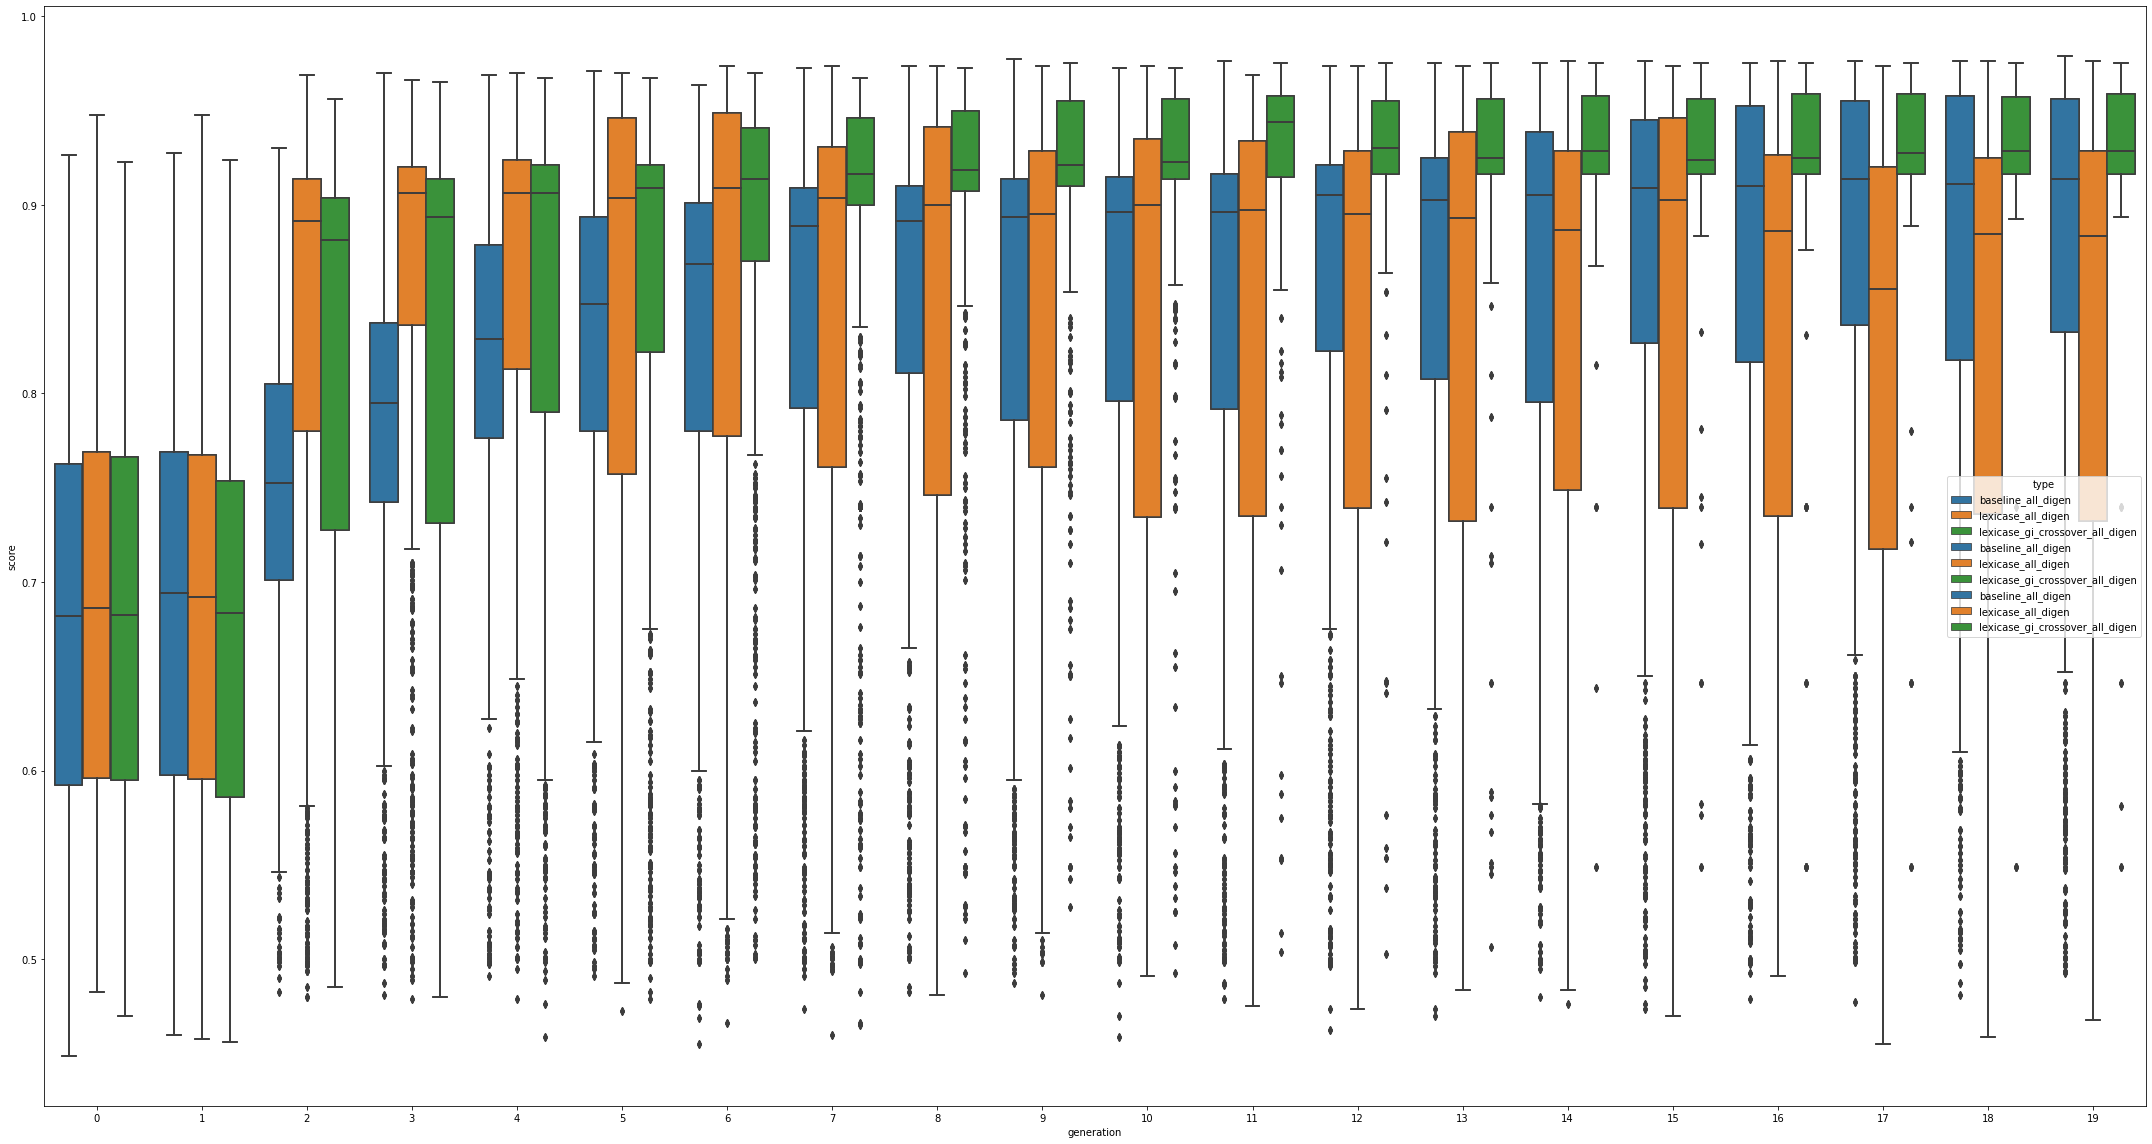

34


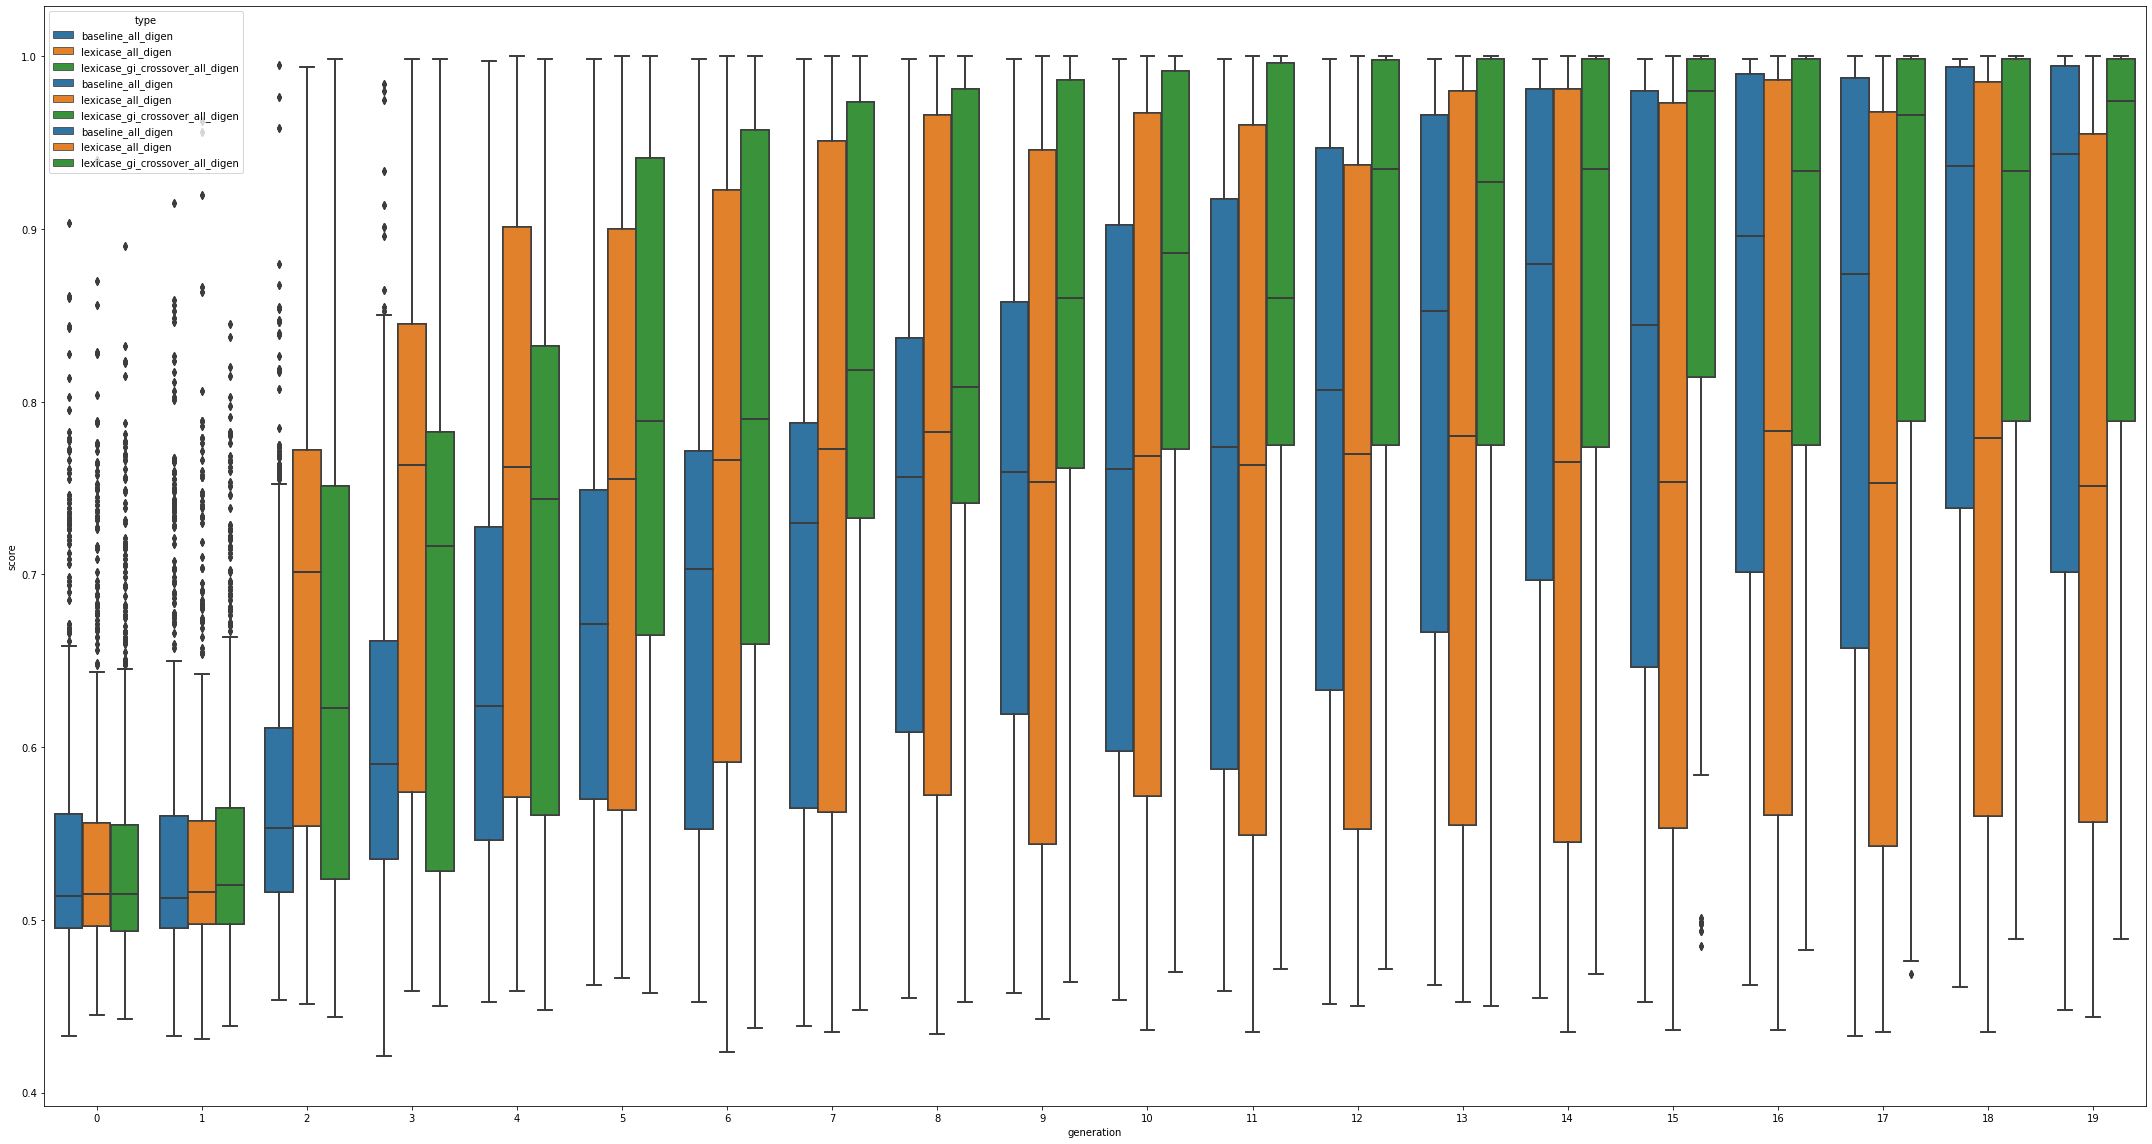

35


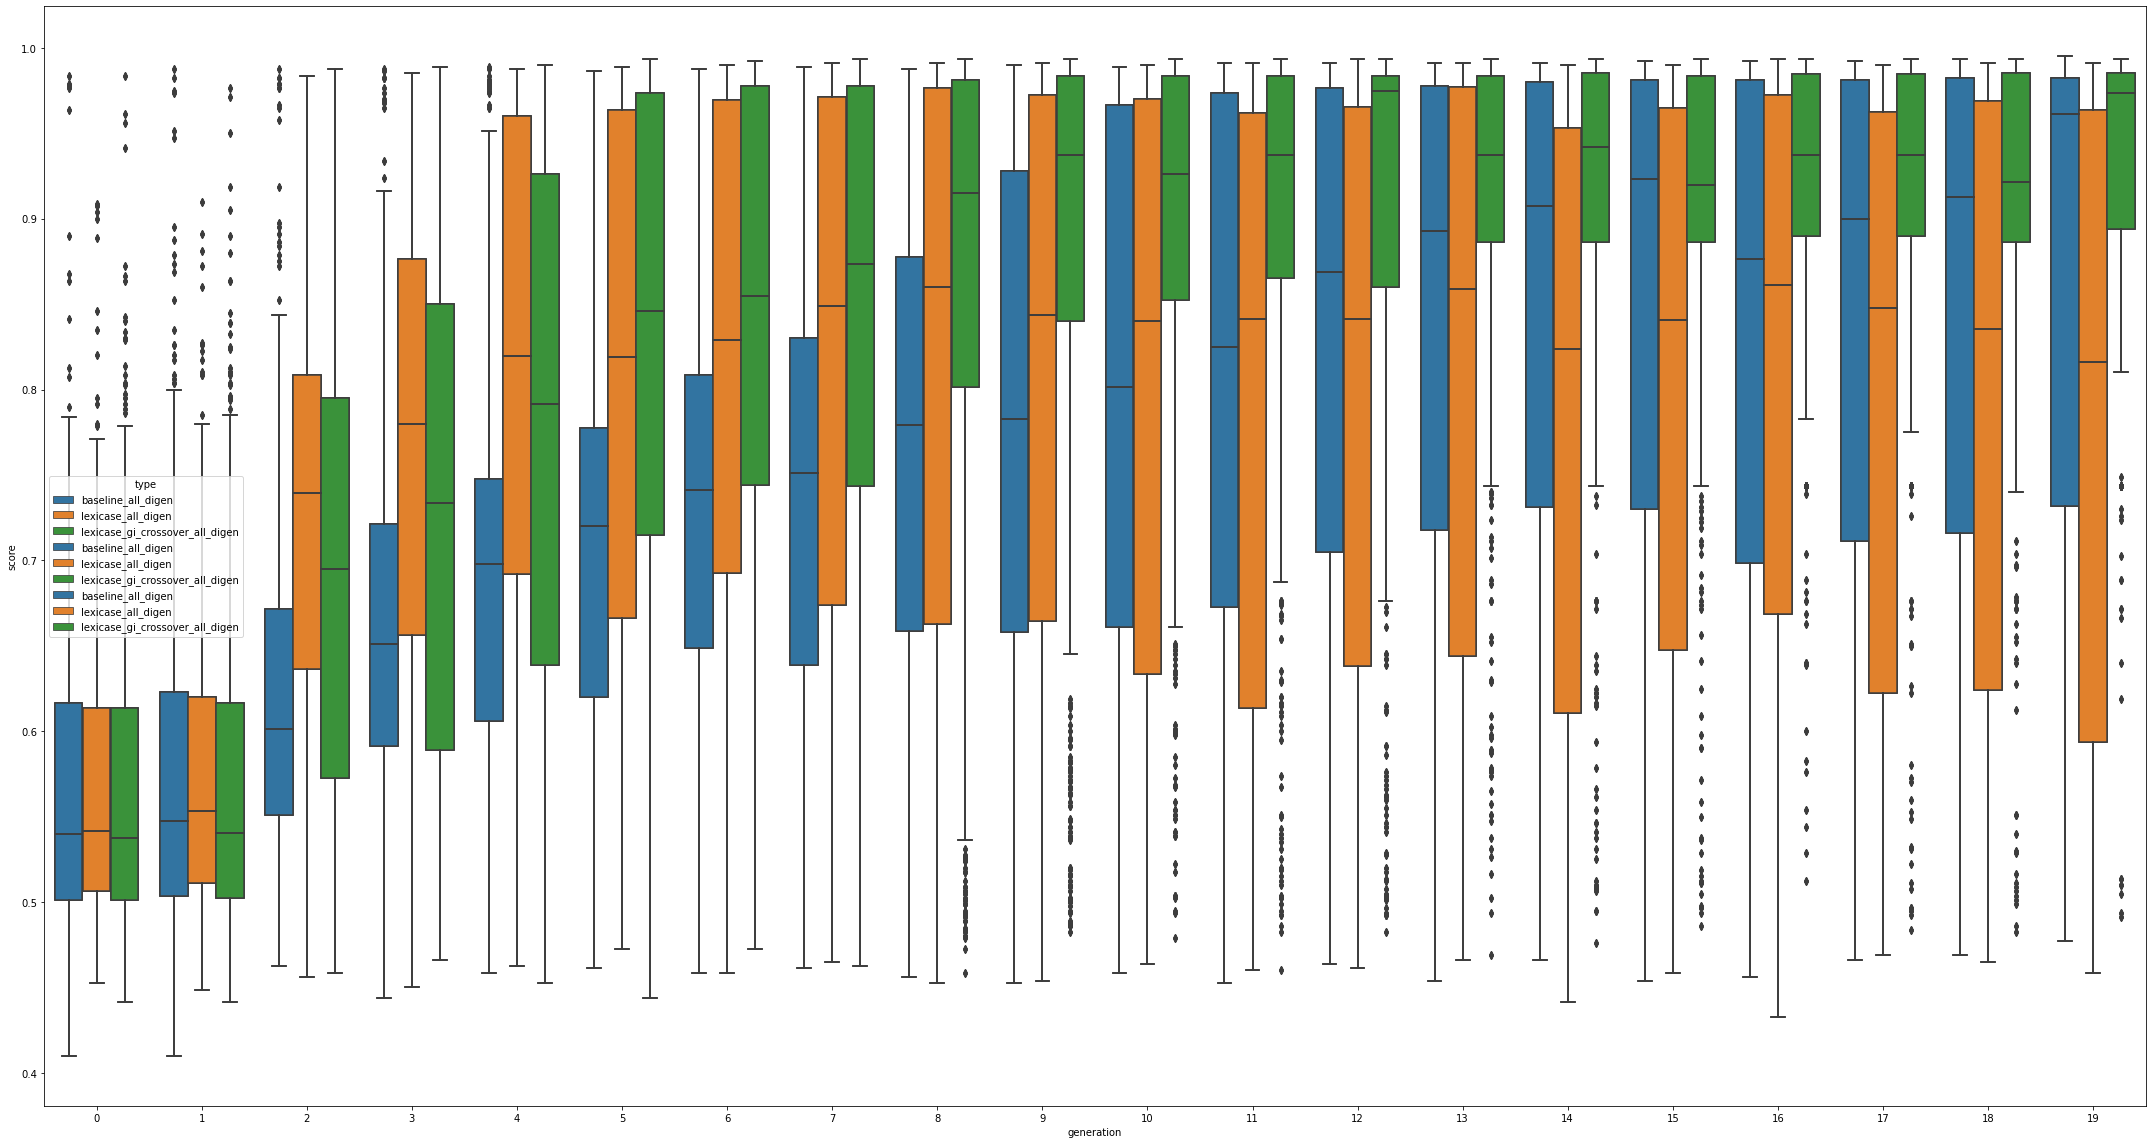

36


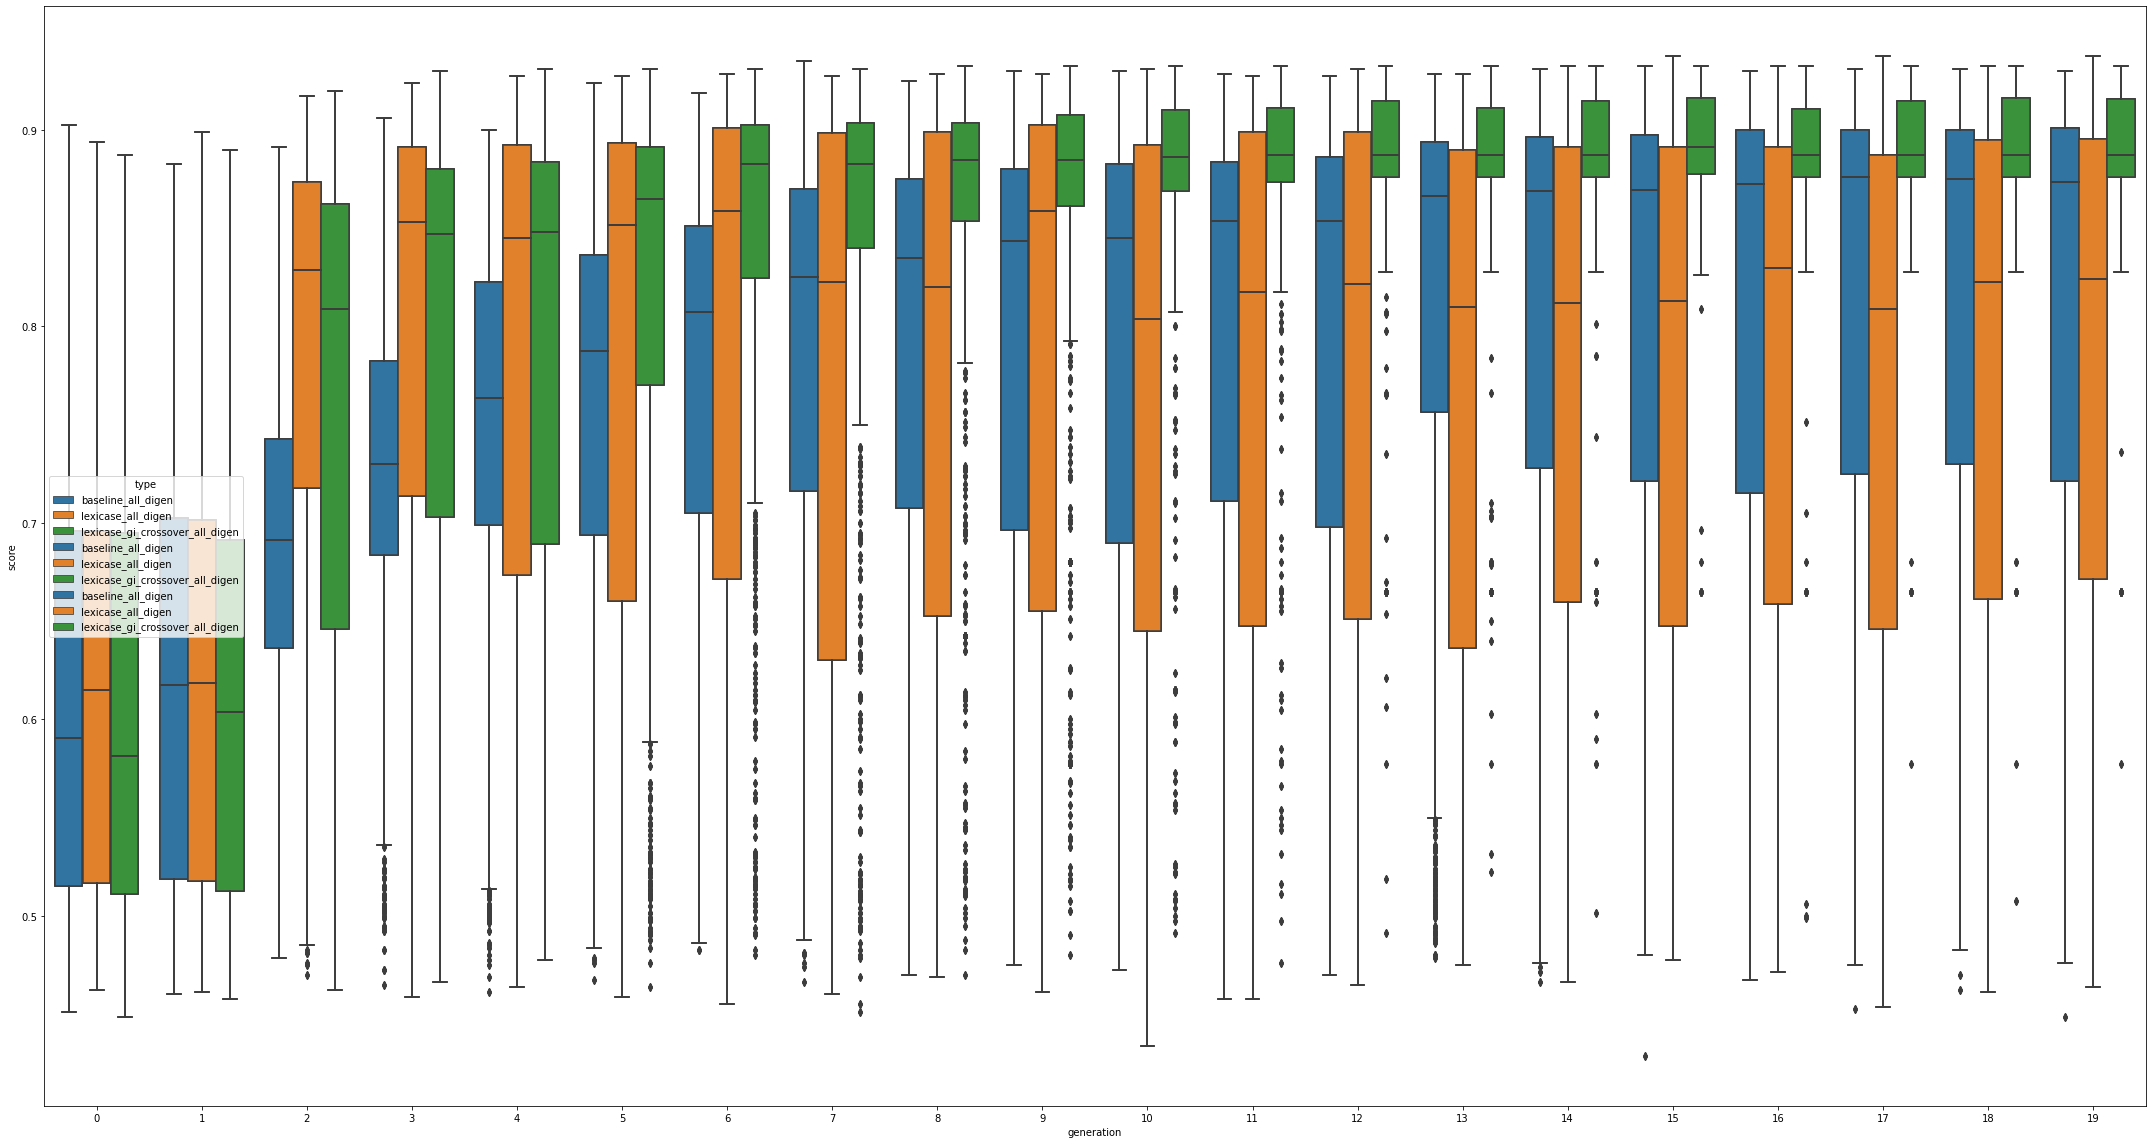

37


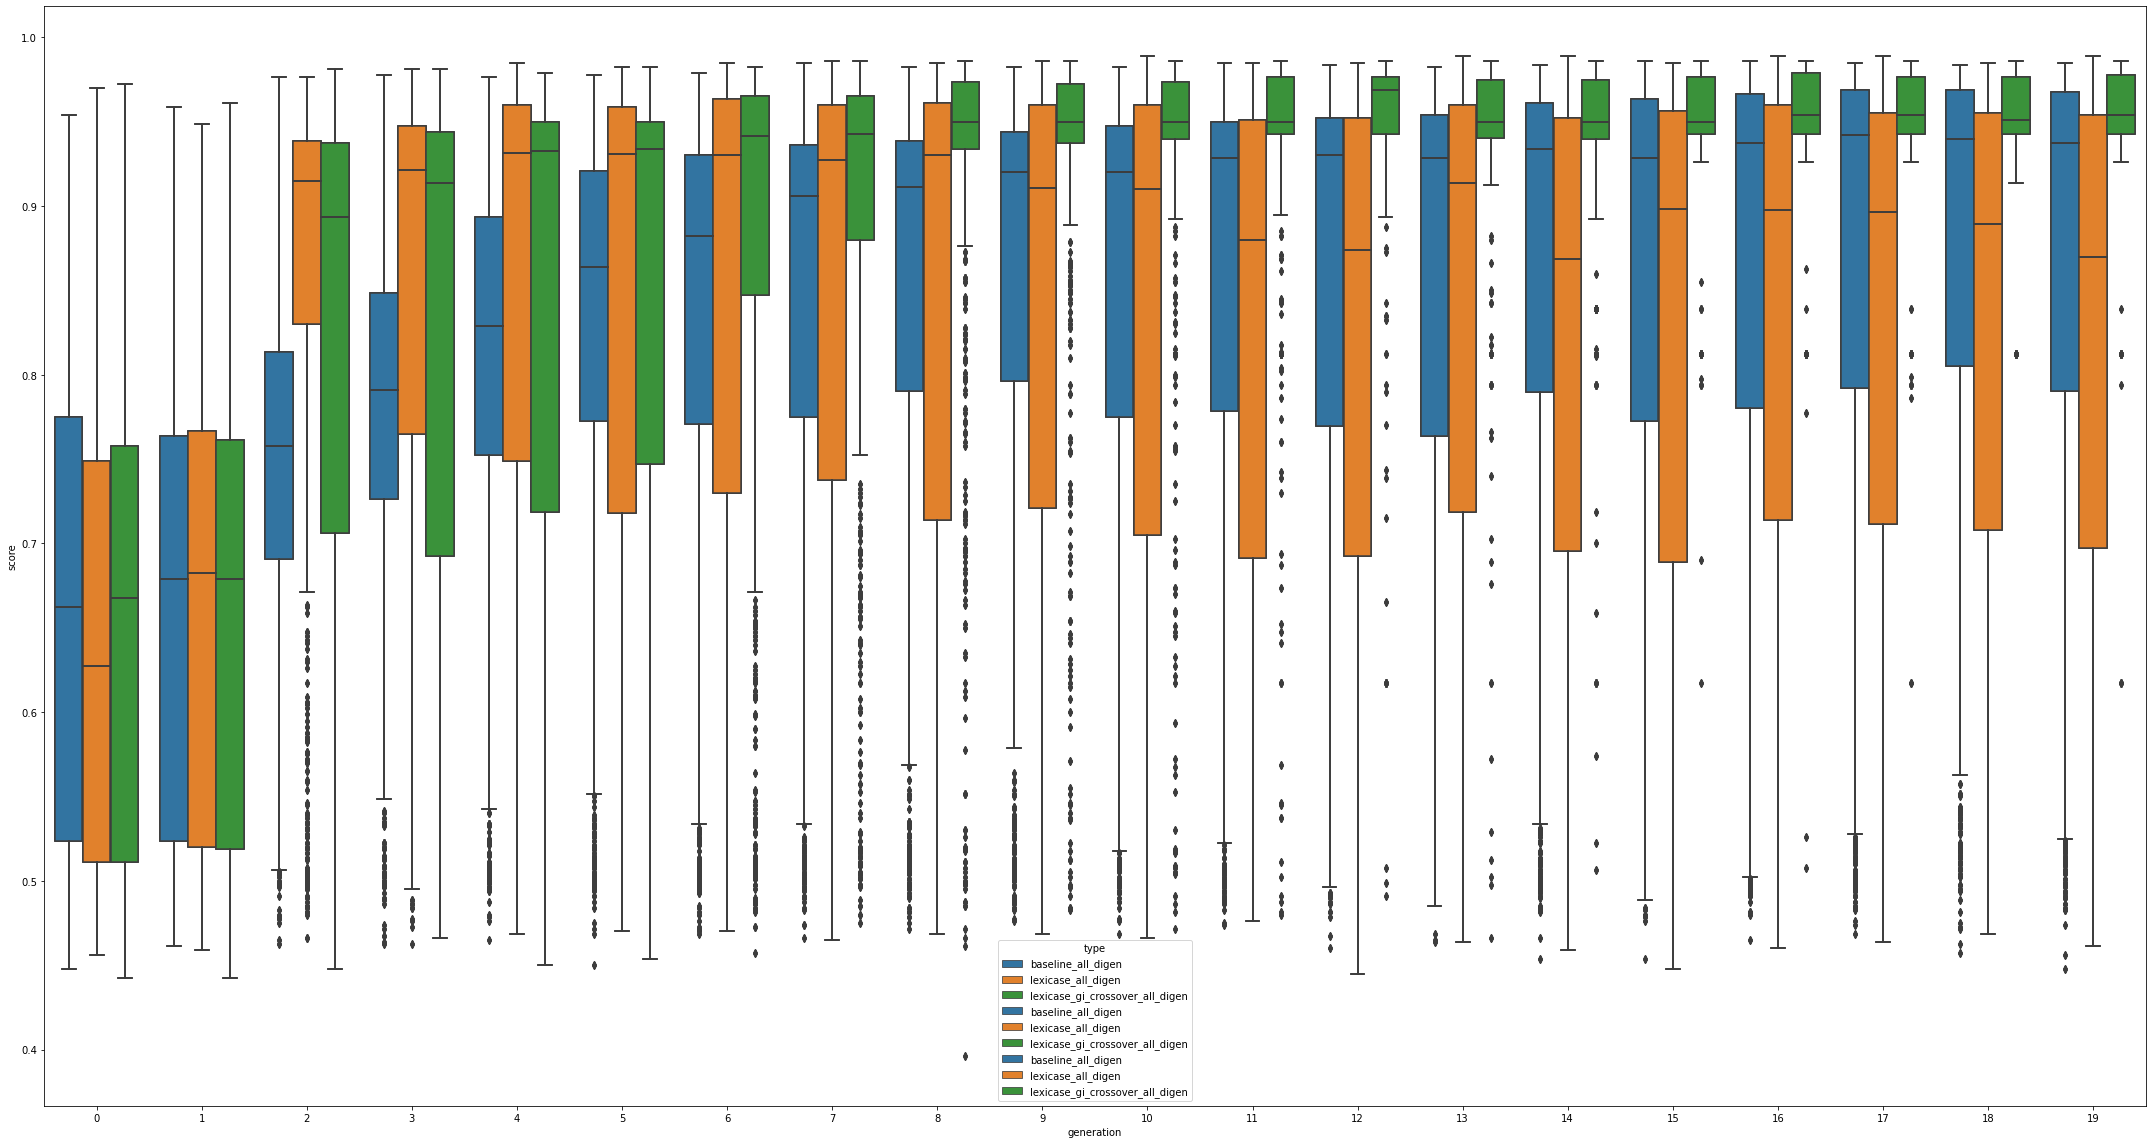

38


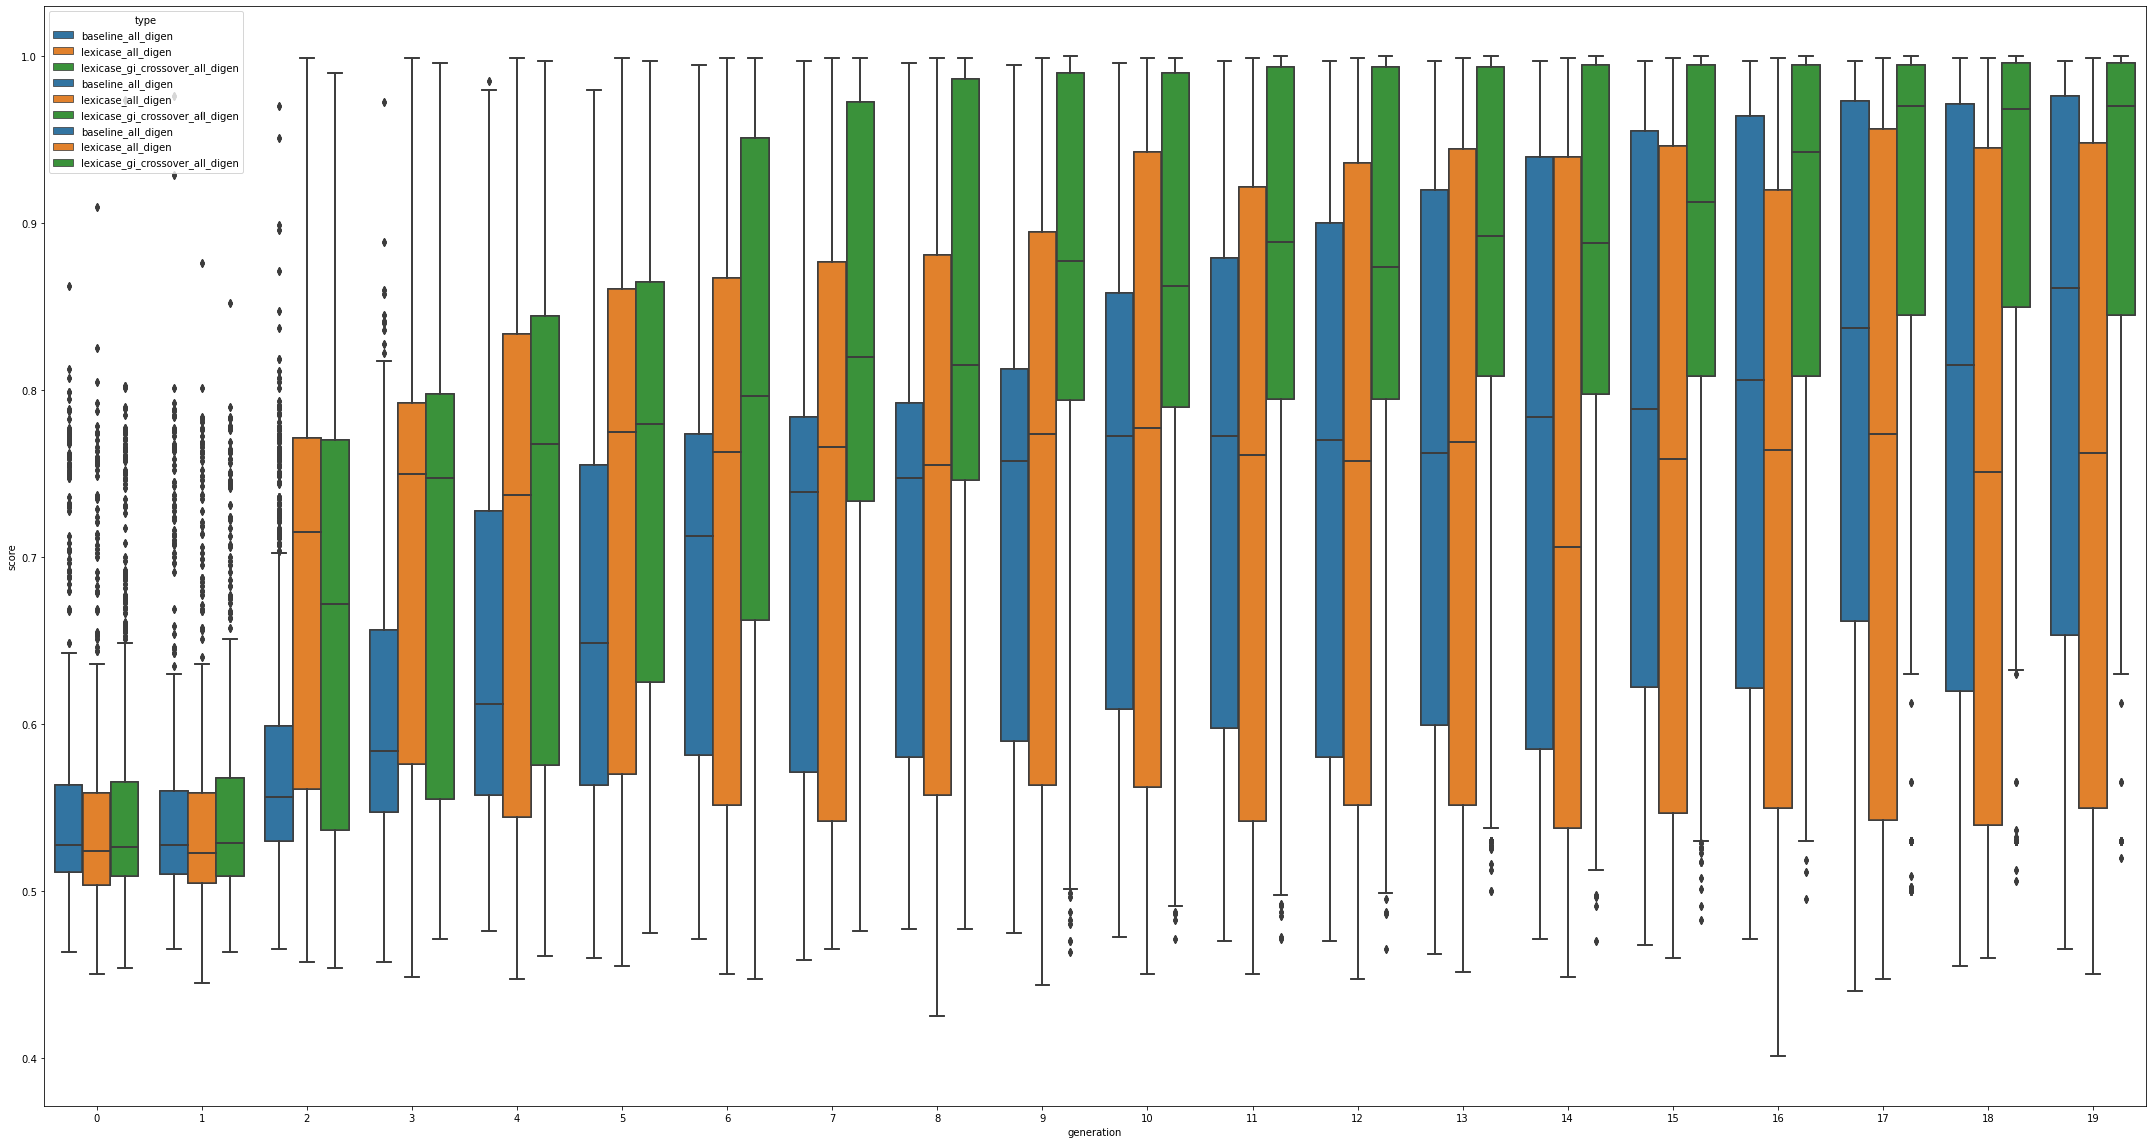

39


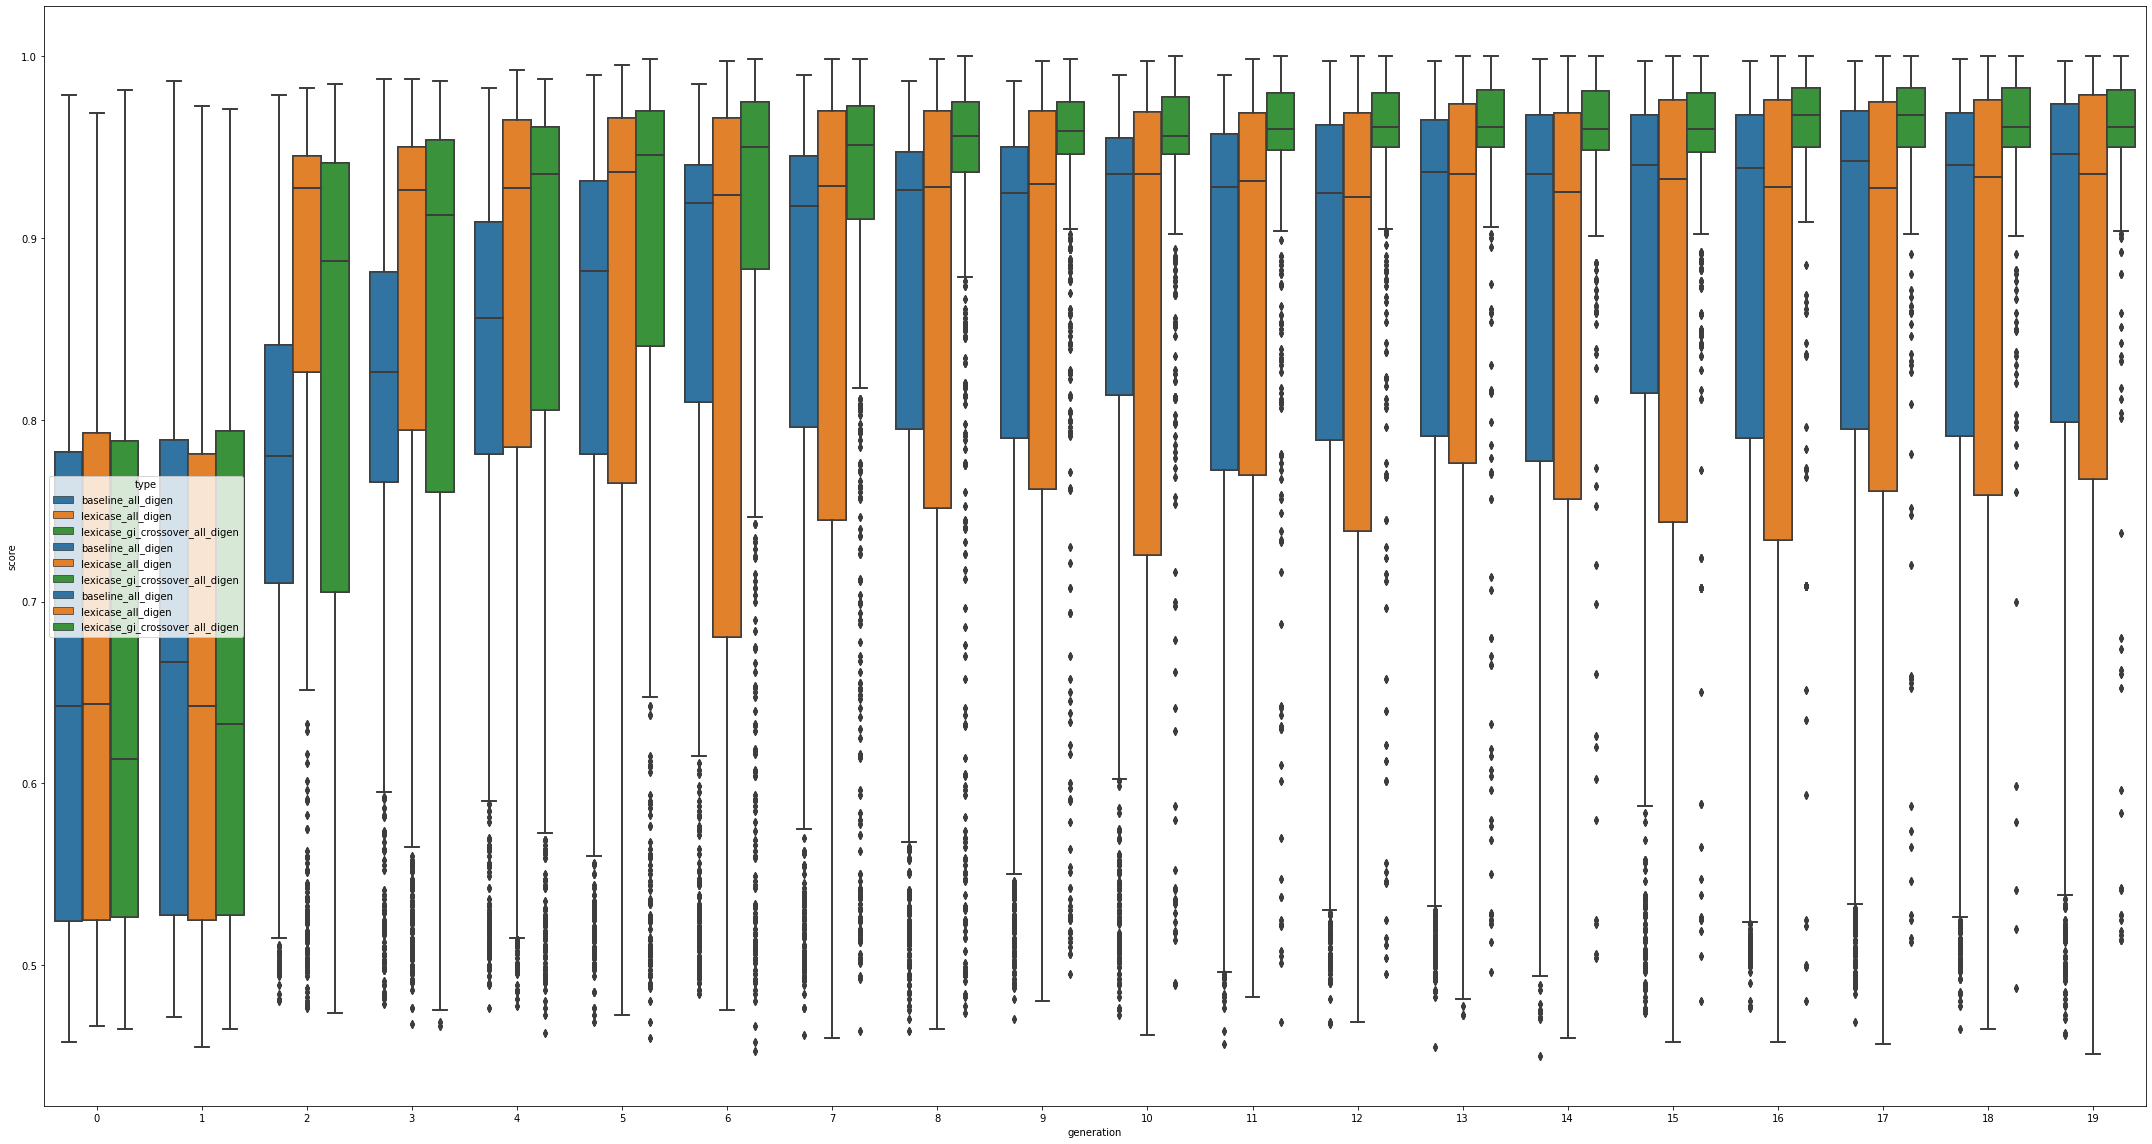

40


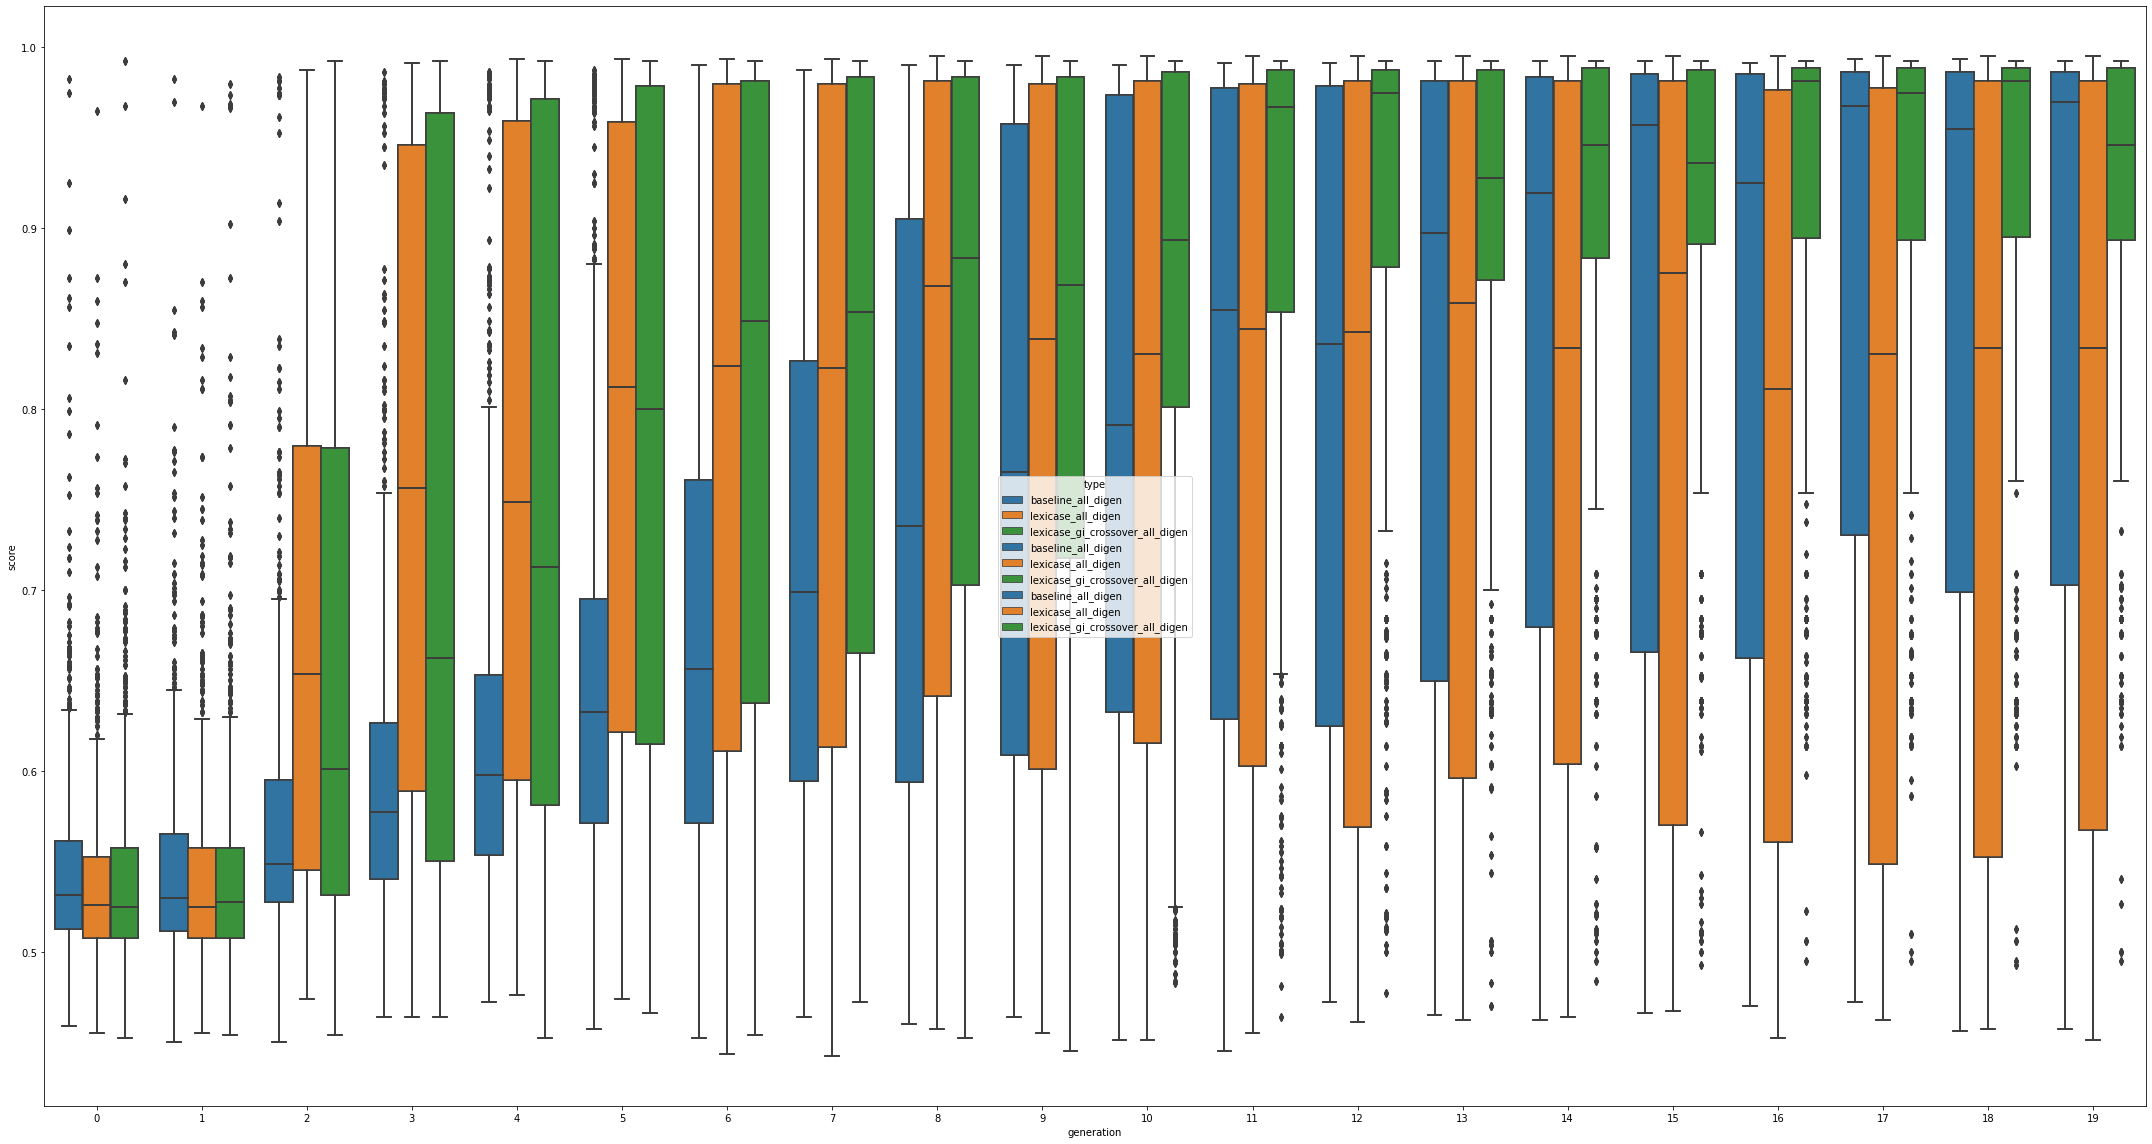

In [17]:
#get generation performance


from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics

plt.rcParams["figure.figsize"] = (30,16)


directoryevs = ["baseline_all_digen","lexicase_all_digen","lexicase_gi_crossover_all_digen"]

create_dirs("/Users/matsumoton/Git/meta_pop50_gen20_run15/gen_fitnesses")
upper_quantile_only = False

for j in range(1,41):
    print(j)
    ev = []
    for directoryev in directoryevs:
        temp_ev = []
        for i in range(15):
            ev_df_name = f"/Users/matsumoton/Git/results_pop50_gen20_run15_{directoryev}/gen_fitnesses/digen{j}_run_{i}_evolution_pop50_gen20.csv"
            if not exists(ev_df_name):
                continue
            fitness_df = pd.read_csv(ev_df_name, sep=',')
            fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
            if upper_quantile_only:
                high_quantile= []
                for g in range(0,10):
                    upper_quantile = np.quantile(fitness_df.loc[fitness_df['generation']==g,'score'],0.90)
                    high_quantile.append(fitness_df.loc[(fitness_df['generation']==g) & (fitness_df['score'] >= upper_quantile)])
                fitness_df = pd.concat(high_quantile)
                
            temp_ev.append(fitness_df)

        temp_ev = pd.concat(temp_ev)
        temp_ev["type"] = directoryev
        ev.append(temp_ev)
    frame_df = pd.concat(ev)
    frame_df = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]

    
    #median normalized
#    for i in range(0,15):
#        median_gen = statistics.median(frame_df.loc[(frame_df['type']=='baseline')&(frame_df['generation']==i)]['score'])
#        frame_df.loc[frame_df['generation']==i,'score']=frame_df.loc[frame_df['generation']==i]['score'].div(median_gen)
    '''
    high_quantile= []
    for i in range(0,15):
        for directoryev in directoryevs:
            upper_quantile = np.quantile(frame_df.loc[frame_df['generation']==i,'score'],0.9)
        
        high_quantile.append(frame_df.loc[(frame_df['generation']==i) & (frame_df['score'] >= upper_quantile)])
    frame_df = pd.concat(high_quantile)
    '''
    for directoryev in directoryevs:
        #seaborn.violinplot(x="generation",y="score",hue="type",data=frame_df, label = "type" if i == 0 else "")
        ax = sns.boxplot(x="generation",y="score",hue="type",data=frame_df)
        #ax = sns.swarmplot(x="generation",y="score",hue="type",data=frame_df,color=".25")

    #plt.show()
    
    plt.savefig(f"/Users/matsumoton/Git/meta_pop50_gen20_run15/gen_fitnesses/digen{j}_pop50_gen20_top_10gens.png")
    plt.show()


In [4]:
from sklearn.datasets import make_classification
test_matrix = X,Y = make_classification(n_samples=1000, n_features=50, n_informative=5, n_redundant=3, n_repeated=2, n_classes=3, n_clusters_per_class=3,flip_y=0,weights=[0.7,0.2,0.1], random_state=17)

from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from test_utils import extract_labels, get_optimizer, create_dirs

import sys

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8,random_state=5)

#digits = load_digits()
#X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,train_size=0.75, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# tpot = TPOTClassifier(verbosity=2, max_time_mins=5, population_size=40)
tpot = TPOTClassifier(verbosity=2, max_time_mins=50, population_size=40, generations=15) 
tpot.fit(X_train, y_train)


Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8575000000000002

Generation 2 - Current best internal CV score: 0.8646874999999999


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(RFE(RFE(input_matrix, criterion=gini, max_features=0.5, n_estimators=100, step=0.35000000000000003), criterion=entropy, max_features=0.45, n_estimators=100, step=0.1), bootstrap=False, criterion=gini, max_features=0.5, min_samples_leaf=1, min_samples_split=7, n_estimators=100)


AttributeError: 'TPOTClassifier' object has no attribute 'resource_logging'

AttributeError: 'TPOTClassifier' object has no attribute 'resource_logging'